In [1]:
suppressPackageStartupMessages(library(rstanarm))
suppressPackageStartupMessages(library(ggformula))
library(tibble)
suppressPackageStartupMessages(library(glue))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(modelr))
library(stringr)

In [2]:
# Set the maximum number of columns and rows to display
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
# Set the default plot size
options(repr.plot.width=18, repr.plot.height=12)

In [3]:
download_if_missing <- function(filename, url) {
    if (!file.exists(filename)) {
        dir.create(dirname(filename), showWarnings=FALSE, recursive=TRUE)
        download.file(url, destfile = filename, method="curl")
    }
}

In [4]:
# Workaround for modelr see
# https://github.com/tidyverse/modelr/issues/113

add_predictions <- function(data, model, var = "pred", type = NULL) {
  data[[var]] <- predict2(model, data, type = type)
  data
}

spread_predictions <- function(data, ..., type = NULL) {
  models <- tibble::lst(...)
  for (nm in names(models)) {
    data[[nm]] <- predict2(models[[nm]], data, type = type)
  }
  data
}

gather_predictions <- function(data, ..., .pred = "pred", .model = "model", type = NULL) {

  models <- tibble::lst(...)

  df <- purrr::map2(models, .pred, add_predictions, data = data, type = type)
  names(df) <- names(models)

  vctrs::vec_rbind(!!!df, .names_to = .model)
}

predict2 <- function(model, data, type = NULL) {
  if (is.null(type)) {
    stats::predict(model, newdata=data)
  } else {
    stats::predict(model, newdata=data, type = type)
  }
}

# Plotting linear and quadratic regressions

The folder [`Earnings`](https://github.com/avehtari/ROS-Examples/tree/master/Earnings/) has data on weight (in pounds), age (in years), and other information from a sample of American adults.
We create a new variable, `age10` = age/10, and fit the following regression predicting weight:

```
            Median   MAD_SD
(Intercept)  148.7     2.2
age10          1.8     0.5

Auxiliary parameter(s)
      Median   MAX_SD
sigma  34.5       0.6
```

## Sketching the model

With pen on paper, sketch a scatterplot of weights versus age (that is, weight on y-ais, age on x-axis) that is consistent with the above information, also drawing the fitted regression line.
Do this just given the information here and your general knowledge about adult heights and weights: do not download the data.

## Adding a quadratic term

Next, we define `age10_sq` $= (\rm{age}/10)^2$ and predict weight as a quadratic function of age:

```
            Median   MAD_SD
(Intercept)  108.0     5.7
age10         21.3     2.6
age10sq       -2.0     0.3

Auxiliary parameter(s)
      Median   MAX_SD
sigma  33.9       0.6
```

Draw this fitted curve on the graph you already sketched above

The datapoints here are a bit rough, they should get sparser, and slightly narrower, for `age10 > 8`, and the scale makes the trend hard to see.
But the point that comes through clearly is the variance is larger than the data!

![Hand drawn scatterplot](images/ros_12_1.jpeg)

### Checking with data

Let's compare my sketch to the actual data

In [5]:
filename <- "./data/Earnings/earnings.csv"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Earnings/data/earnings.csv')
earnings <- read.csv(filename, header=TRUE)

In [6]:
earnings <- earnings %>% mutate(age10 = age / 10, age10sq = age10^2)
fit_linear_earnings <- stan_glm(weight ~ age10, data=earnings, refresh=0)
fit_quadratic_earnings <- stan_glm(weight ~ age10 + age10sq, data=earnings, refresh=0)

The models are close to what is described above

In [7]:
fit_linear_earnings

stan_glm
 family:       gaussian [identity]
 formula:      weight ~ age10
 observations: 1789
 predictors:   2
------
            Median MAD_SD
(Intercept) 148.7    2.1 
age10         1.8    0.5 

Auxiliary parameter(s):
      Median MAD_SD
sigma 34.5    0.6  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [8]:
fit_quadratic_earnings

stan_glm
 family:       gaussian [identity]
 formula:      weight ~ age10 + age10sq
 observations: 1789
 predictors:   3
------
            Median MAD_SD
(Intercept) 108.1    5.7 
age10        21.3    2.6 
age10sq      -2.0    0.3 

Auxiliary parameter(s):
      Median MAD_SD
sigma 33.9    0.6  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [9]:
add_predictions <- function(data, model, var = "pred", type = NULL) {
  data[[var]] <- predict(model, newdata=data, type = type)
  data
}

In [10]:
earnings_predictions <- data.frame(age10 = seq(0, 10, by=0.1)) %>%
mutate(age10sq = age10^2) %>%
spread_predictions(fit_linear_earnings, fit_quadratic_earnings)

Generally my sketch contains many of the features of the data, and indeed it is hard to see the trend.
One thing I missed was some *very* high values of weight.

Warning message:
“Removed 27 rows containing missing values (geom_point).”


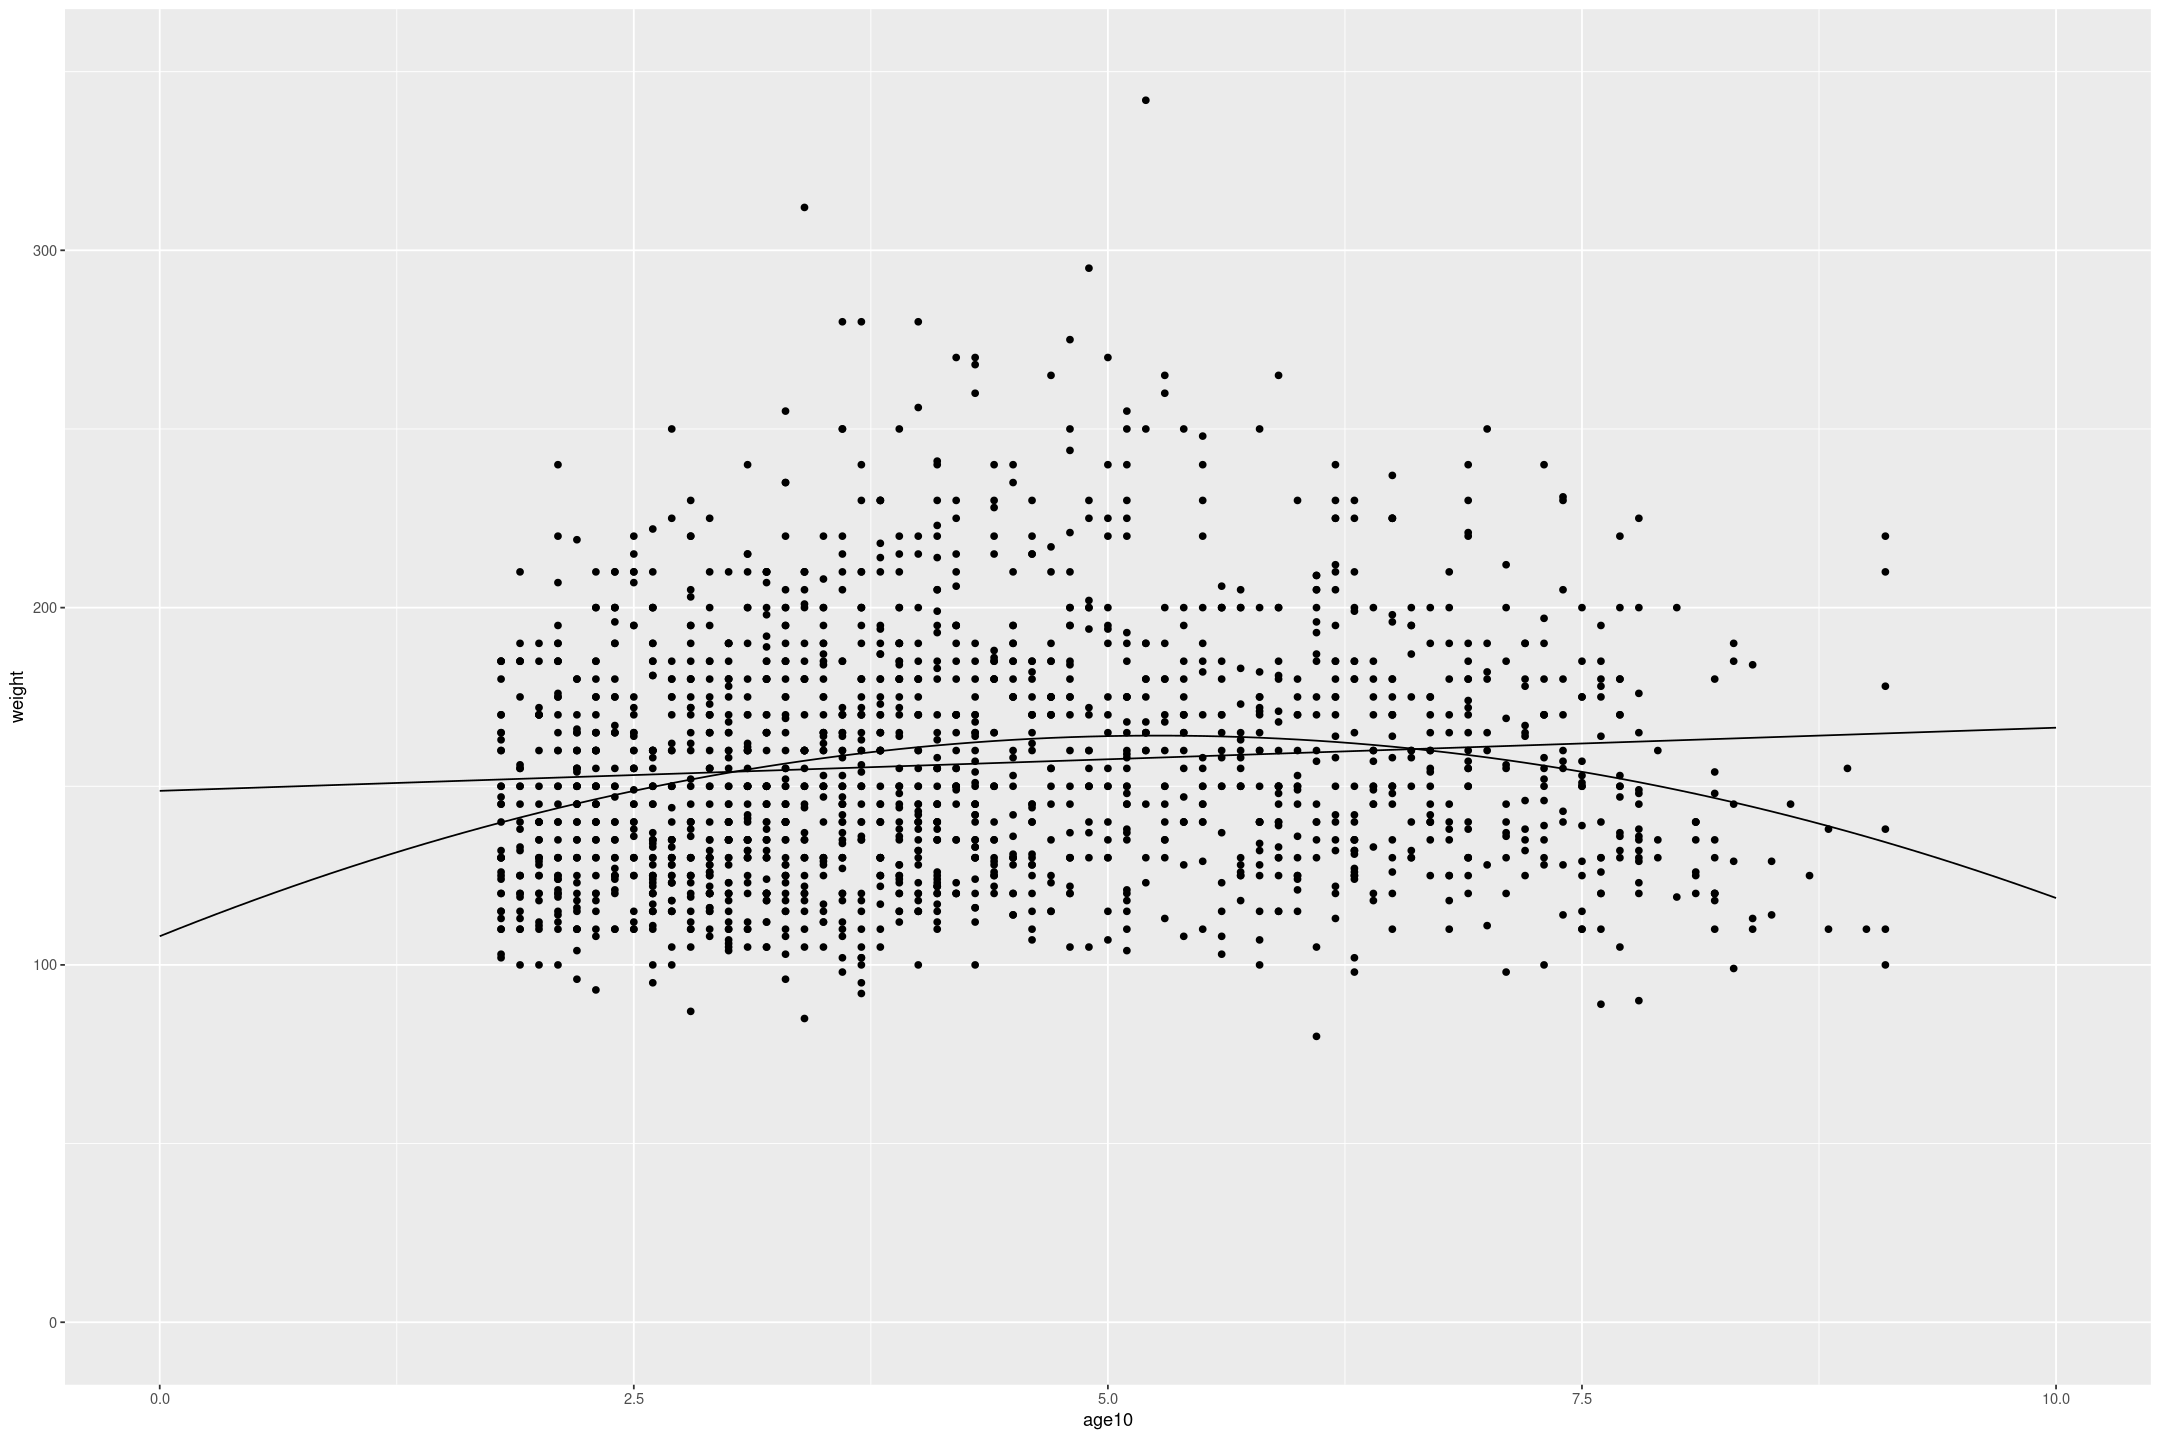

In [11]:
earnings %>%
gf_point(weight ~ age10) %>%
gf_line(fit_linear_earnings ~ age10, data=earnings_predictions) %>%
gf_line(fit_quadratic_earnings ~ age10, data=earnings_predictions) +
ylim(0, 350)

# Plotting regression with a continuous variable broken into categories

Continuing Exercise 12.1, we divide age into 4 categories and create corresponding inticator variable, `age18_29`, `age30_44`, `age45_64`, and `age65_up`. We then fit the following regression:

```
stan_glm(weight ~ age30_44 + age45_64 + age65_up, data=earnings)

             Median   MAD_SD
(Intercept)   147.8     1.6
age30_44TRUE    9.6     2.1
age45_64TRUE   16.6     2.3
age65_upTRUE    7.5     2.7

Auxiliary parameter(s)
      Median   MAX_SD
sigma  34.1       0.6
```

## Missing Indicator

Why did we not include an indicator for the youngest group, `age18_29`?

Because every person is in one of the age groups, then they would be linearly dependent with the constant term; the coefficients are non-identifiable and the model won't fit.

We could add `age18_29` and remove the intercept, but a similar problem will occur if we add other categorical variables, and so the default is to drop the lowest,

## Sketch the graph

Using the same axes and scale as in your graph for Exercise 12.1, sketch with pen on paper the scatterplot, along with the above regression function, which will be discontinuous.

![Sketch of graph](images/ros_12_2.jpeg)

### Check with data

In [12]:
age_grouper <- function(age) {
    cut(age,
        breaks=c(18, 30, 45, 65, Inf), 
        labels=c("18_29", "30_44", "45_64", "65_up"),
        right=FALSE,
        # To prevent stanarm from being clever with ordered regression
        ordered=FALSE)
}

earnings <- earnings %>%
mutate(age_group = age_grouper(age))

fit_group_earnings <- stan_glm(weight ~ age_group, data=earnings, refresh=0)
fit_group_earnings

stan_glm
 family:       gaussian [identity]
 formula:      weight ~ age_group
 observations: 1789
 predictors:   4
------
               Median MAD_SD
(Intercept)    147.7    1.6 
age_group30_44   9.6    2.1 
age_group45_64  16.6    2.3 
age_group65_up   7.6    2.6 

Auxiliary parameter(s):
      Median MAD_SD
sigma 34.1    0.6  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [13]:
earnings_predictions <- data.frame(age=seq(18,100,by=0.05)) %>%
mutate(age10=age/10) %>%
mutate(age_group = age_grouper(age)) %>%
spread_predictions(fit_group_earnings)

Again broadly right, with similar caveats to 12.1.

Warning message:
“Removed 27 rows containing missing values (geom_point).”


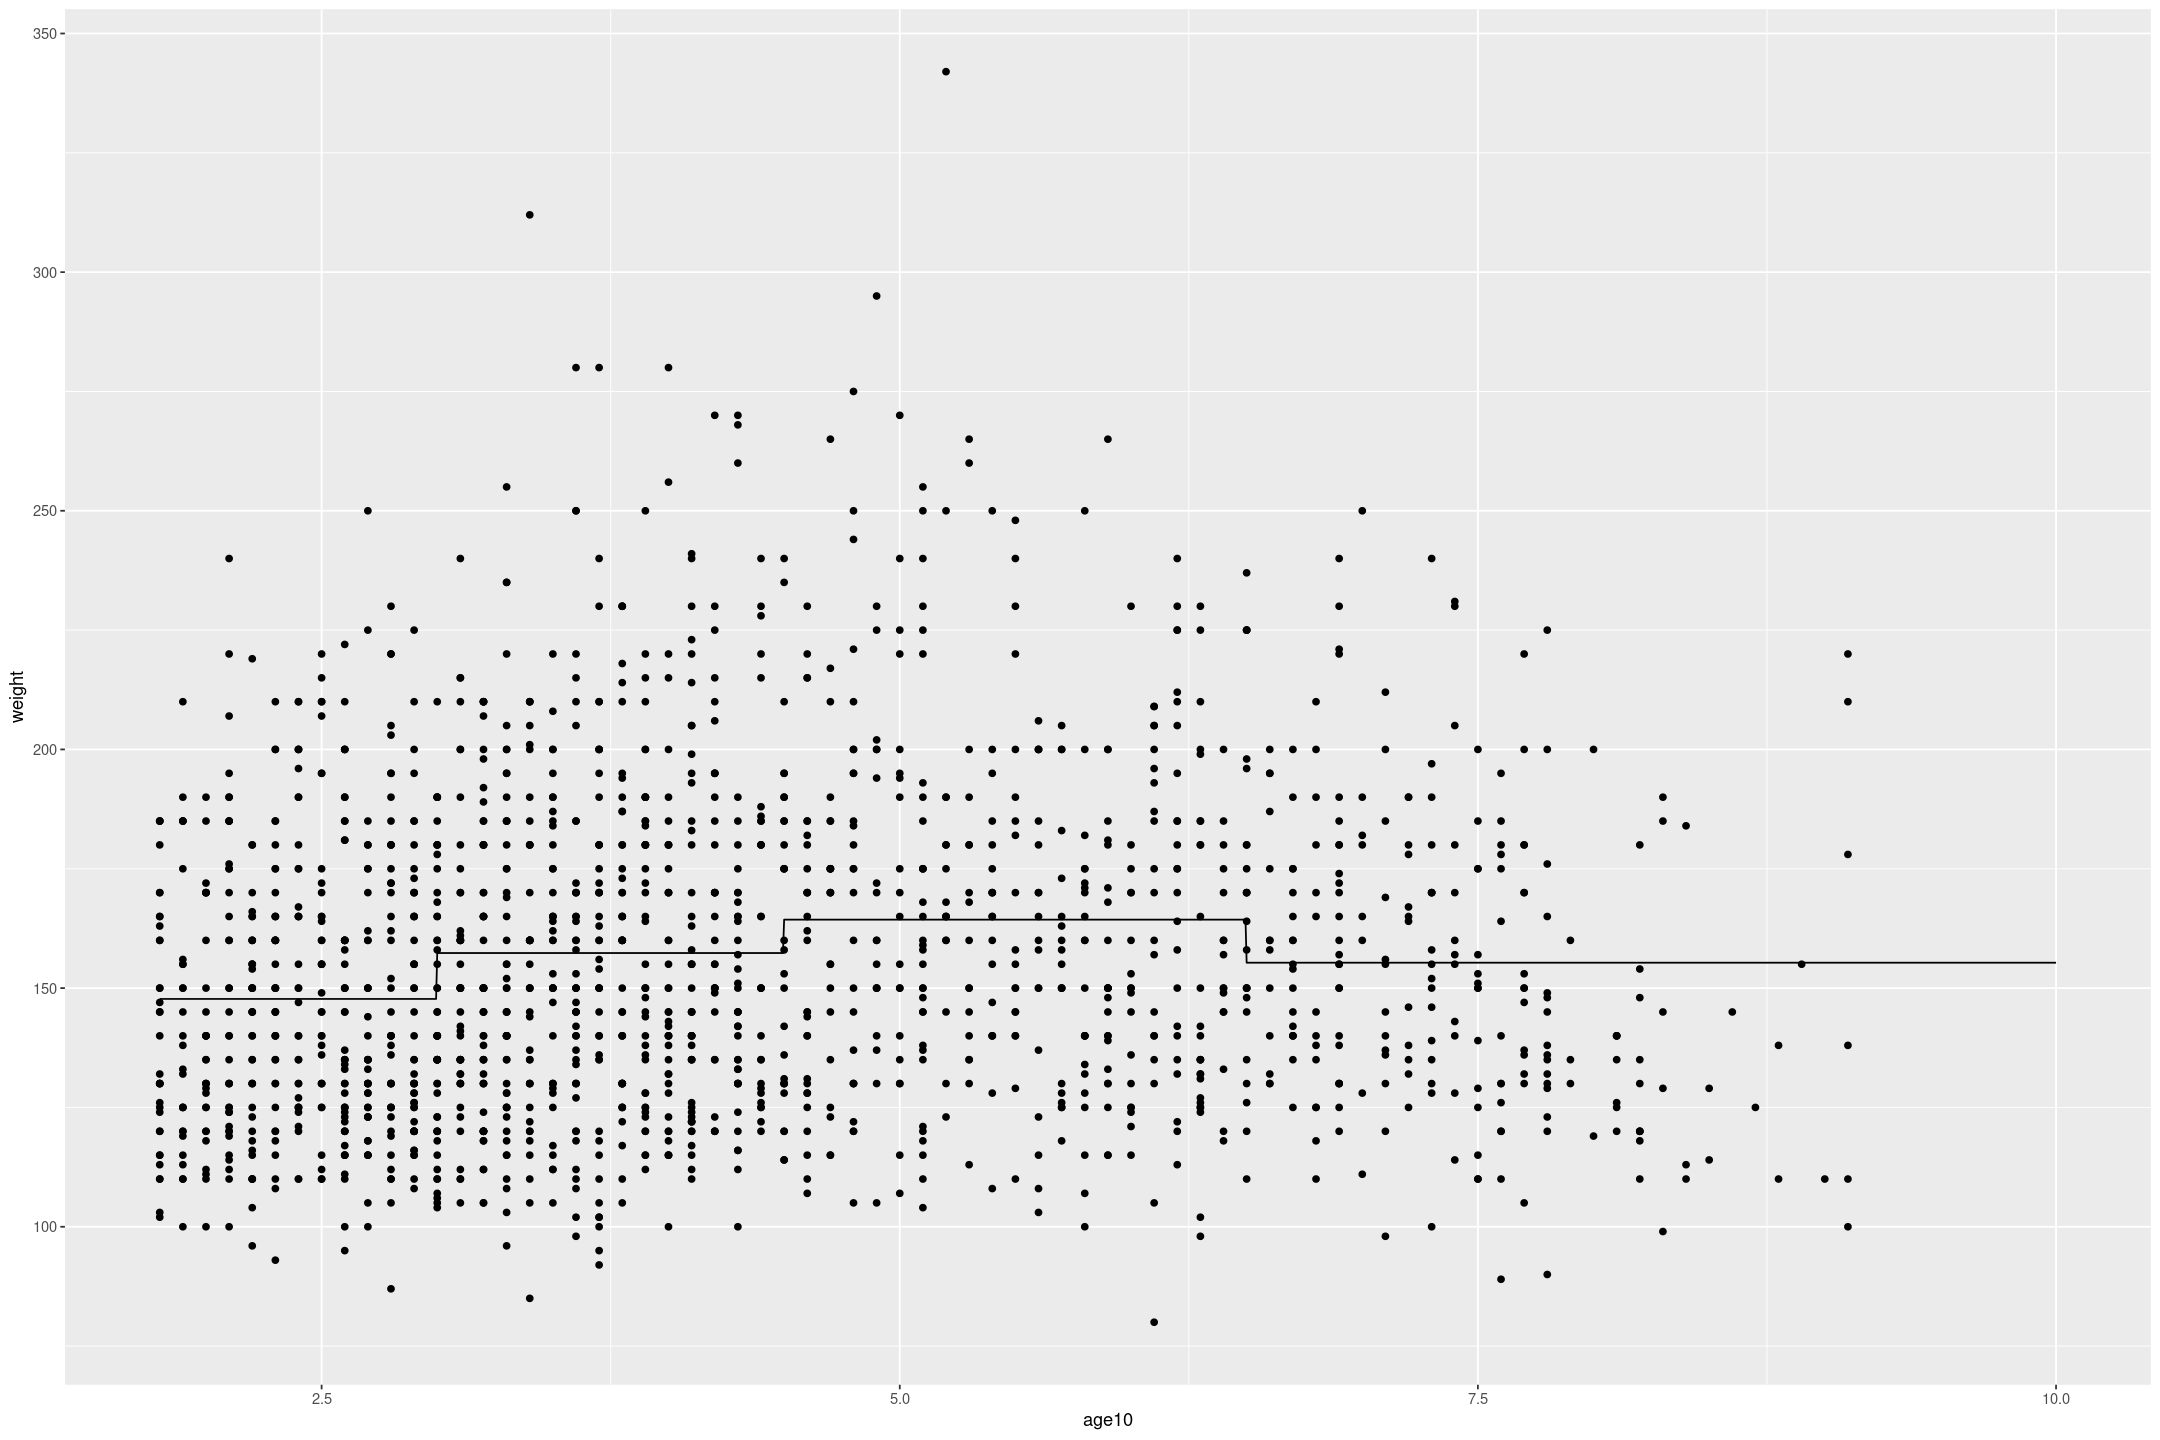

In [14]:
earnings %>%
gf_point(weight ~ age10) %>%
gf_line(fit_group_earnings ~ age10, data=earnings_predictions)

# Scale of regression coefficients

A regression was fit to data from different countries, predicting the rate of civil conflicts given a set of geographic and political predictors.
Here are the estimated coefficients and their z-scores (coefficient divided by standard error), given to three decimal places.

|  | Estimate | z-score |
| --- | --- | --- |
| Intercept | -3.814 | -20.178 |
| Conflict before 2000 | 0.020 | 1.861 |
| Distance to border | 0.000 | 0.450 |
| Distance to capital | 0.000 | 1.629 |
| Population | 0.000 | 2.482 |
| % mountainous | 1.641 | 8.518 |
| % irrigated | -0.027 | -1.663 |
| GDP per capita | -0.000 | -3.589 |

Why are the coefficients for distance to border, distance to capital, population, and GDP per capita so small?

Consider % irrigated, it must be a value between 0 and 100. So given the estimate of -0.027, the most it could feasibly impact a prediction of rate of civil conflict is by 2.7.

Now consider population, this will vary by orders of magnitude between countries. Small countries will have millions of people or less, and large countries will have hundreds of millions of people.
After standardising it has a marginally larger z-score estimate than % irrigated, but if a change in population of 10 million increases the rate of civil conflict by, say 5, then the coefficient will be 5e-7.

Similarly the distance to border, and distance to capital is likely hundreds or thousands of kilometers, and varies substantially by country.
And GDP per capita could range from tens to thousands of dollars.

So even though all the factors have a similar z-score coefficient, because distance to border, distance to capital, population and GDP per capita vary by a large amount thier estimates must be very small.

# Coding a predictor as both cateogical and continuous

A linear regression is fit on a group of employed adults, predicting their physical flexibility given age.
Flexibility is defined on a 0-30 scale based on measurements from a series of stretching tasts.
Your model includes age in categories (under 30, 30-44, 45-59, 60+) and also age as a linear predictor.
Sketch a graph of flexibility vs. age, showing what the fitted regression might look like.

One thing that isn't great about this sketch is the discontinuities between age gaps - they're possible, but shouldn't happen every gap.

The insight here is the continuous predictor can capture the variation within an age group, and the categorical predictors can set level shifts between groups.

![Sketch](images/ros_12_4.jpeg)

## Checking with a simulation

For the sake of argument let's come up with some non-linear curve for how flexibility changes with age.

In [15]:
age_grouper <- function(age) {
    cut(age,
        breaks=c(18, 30, 45, 59, Inf), 
        labels=c("18_29", "30_44", "45_59", "60_up"),
        right=FALSE,
        # To prevent stanarm from being clever with ordered regression
        ordered=FALSE)
}


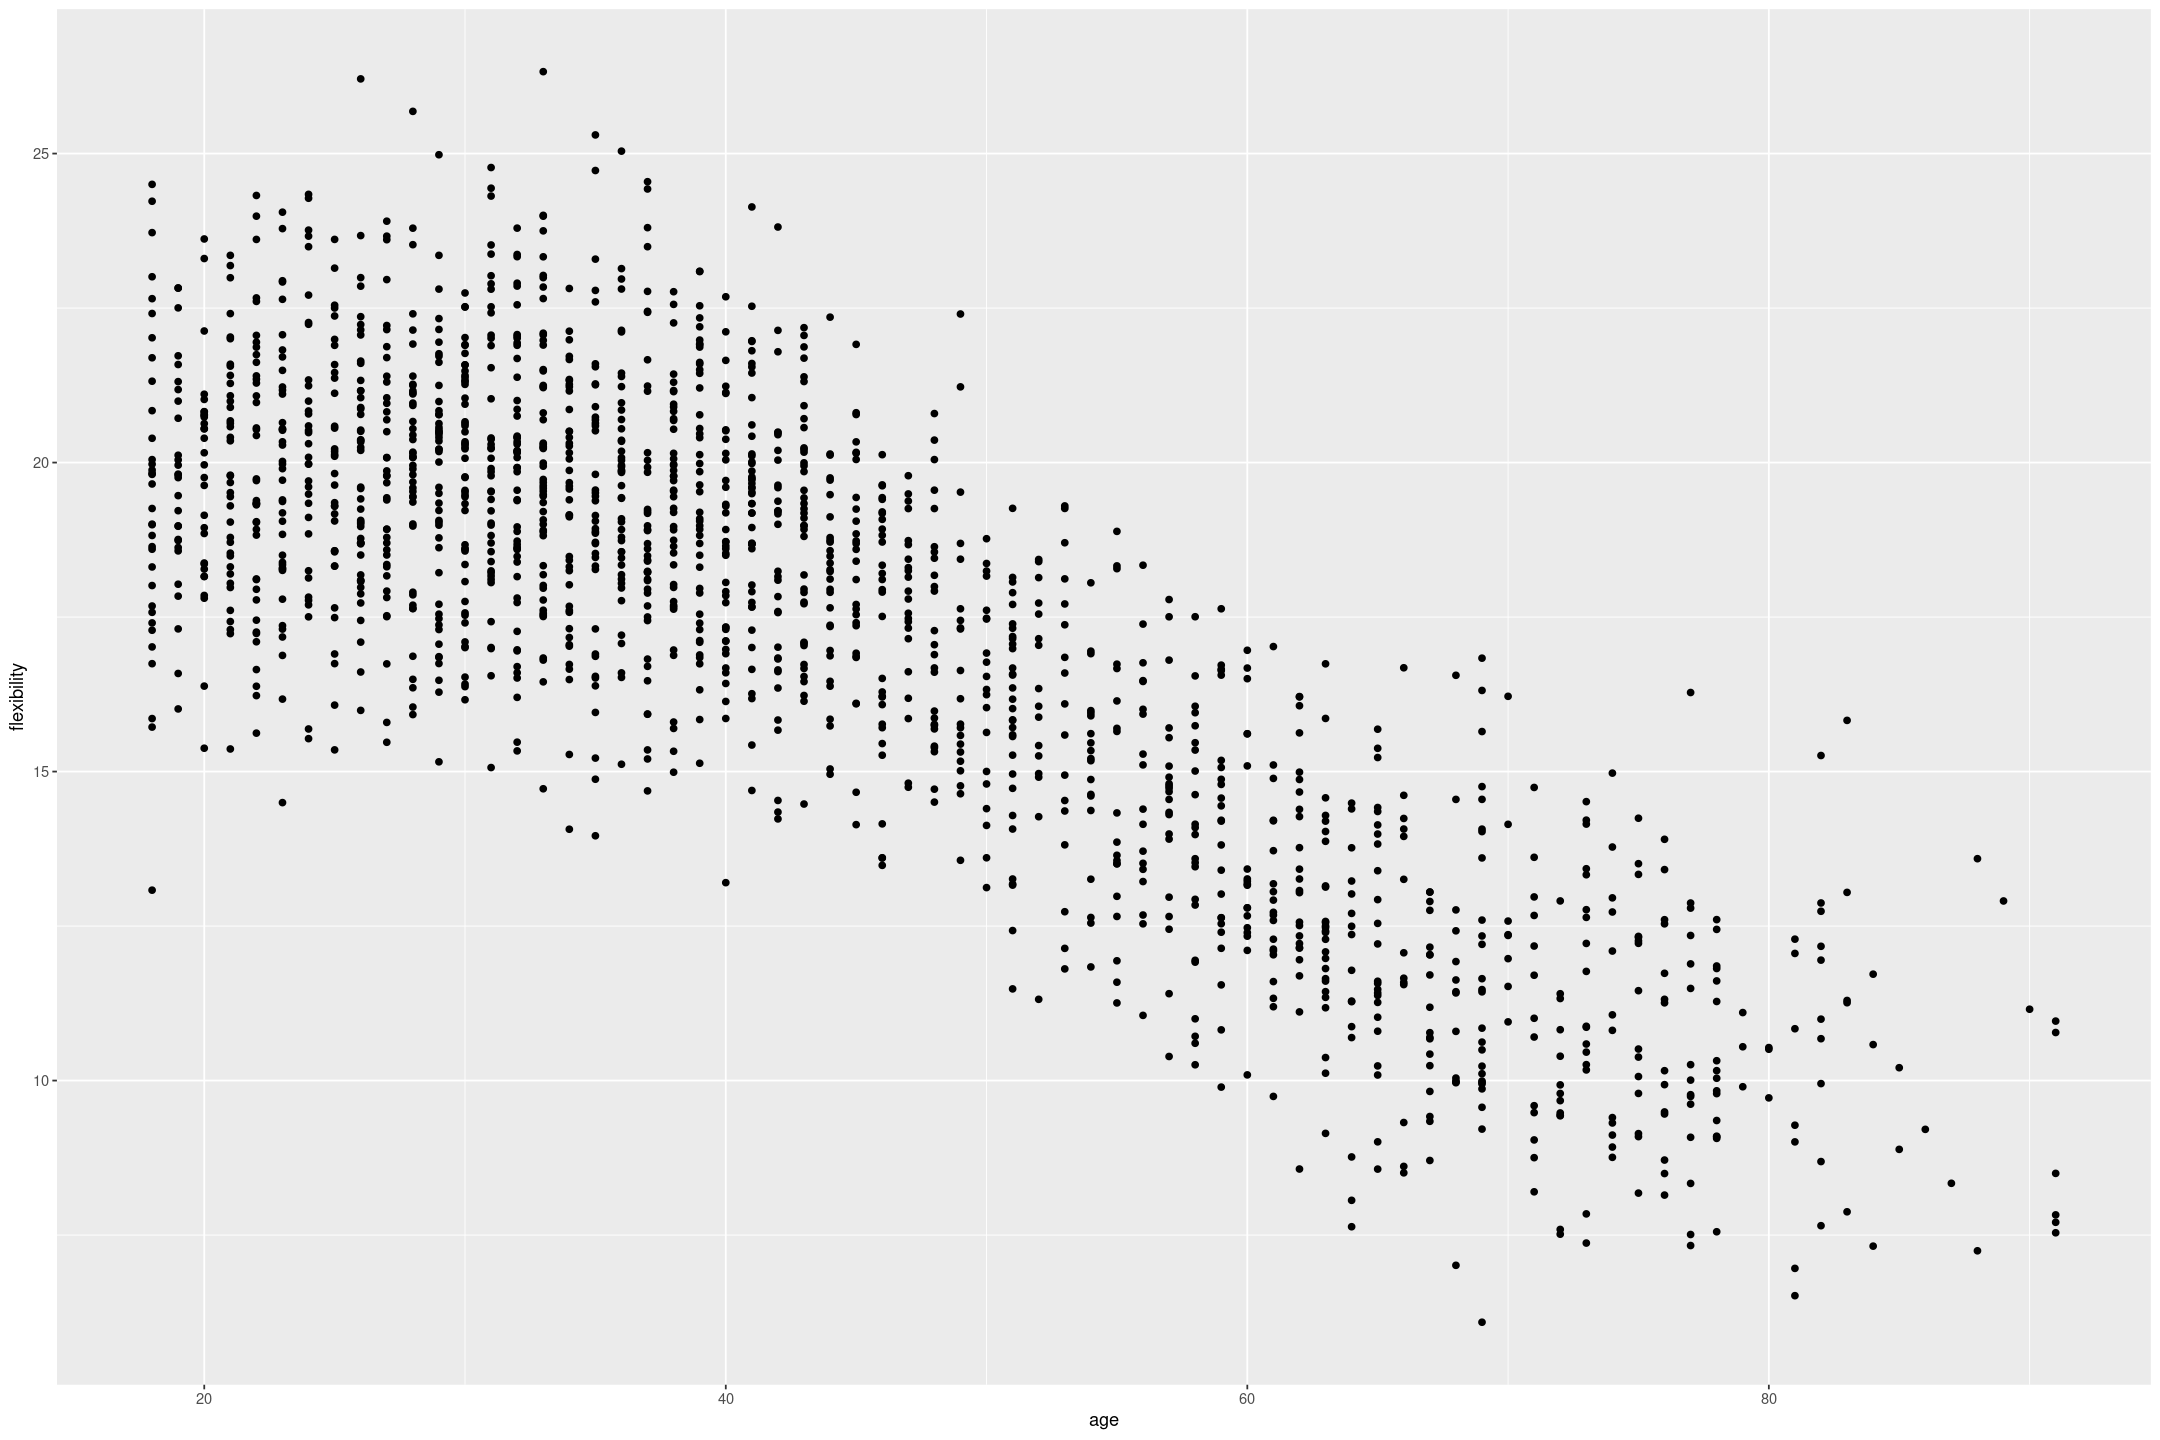

In [16]:
flexibility <- data.frame(age=earnings$age) %>%
mutate(flexibility = 10 + 10/(1 + exp(2*(sqrt(age)-sqrt(55)))) + 2*rnorm(nrow(earnings)),
       age_group = age_grouper(age))

flexibility %>%
gf_point(flexibility ~ age)

In [17]:
(flexibility_model <- stan_glm(flexibility ~ age + age_group, data=flexibility, refresh=0))

stan_glm
 family:       gaussian [identity]
 formula:      flexibility ~ age + age_group
 observations: 1816
 predictors:   5
------
               Median MAD_SD
(Intercept)    23.0    0.3  
age            -0.1    0.0  
age_group30_44  1.2    0.2  
age_group45_59 -0.1    0.3  
age_group60_up -2.1    0.5  

Auxiliary parameter(s):
      Median MAD_SD
sigma 2.1    0.0   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

As predicted we actually do see one of these counterintuitive discontinuities because we're trying to fit a single slope across all the regions (and it's likely fitting more to the tail of 60+ where there are distant points with large influence).

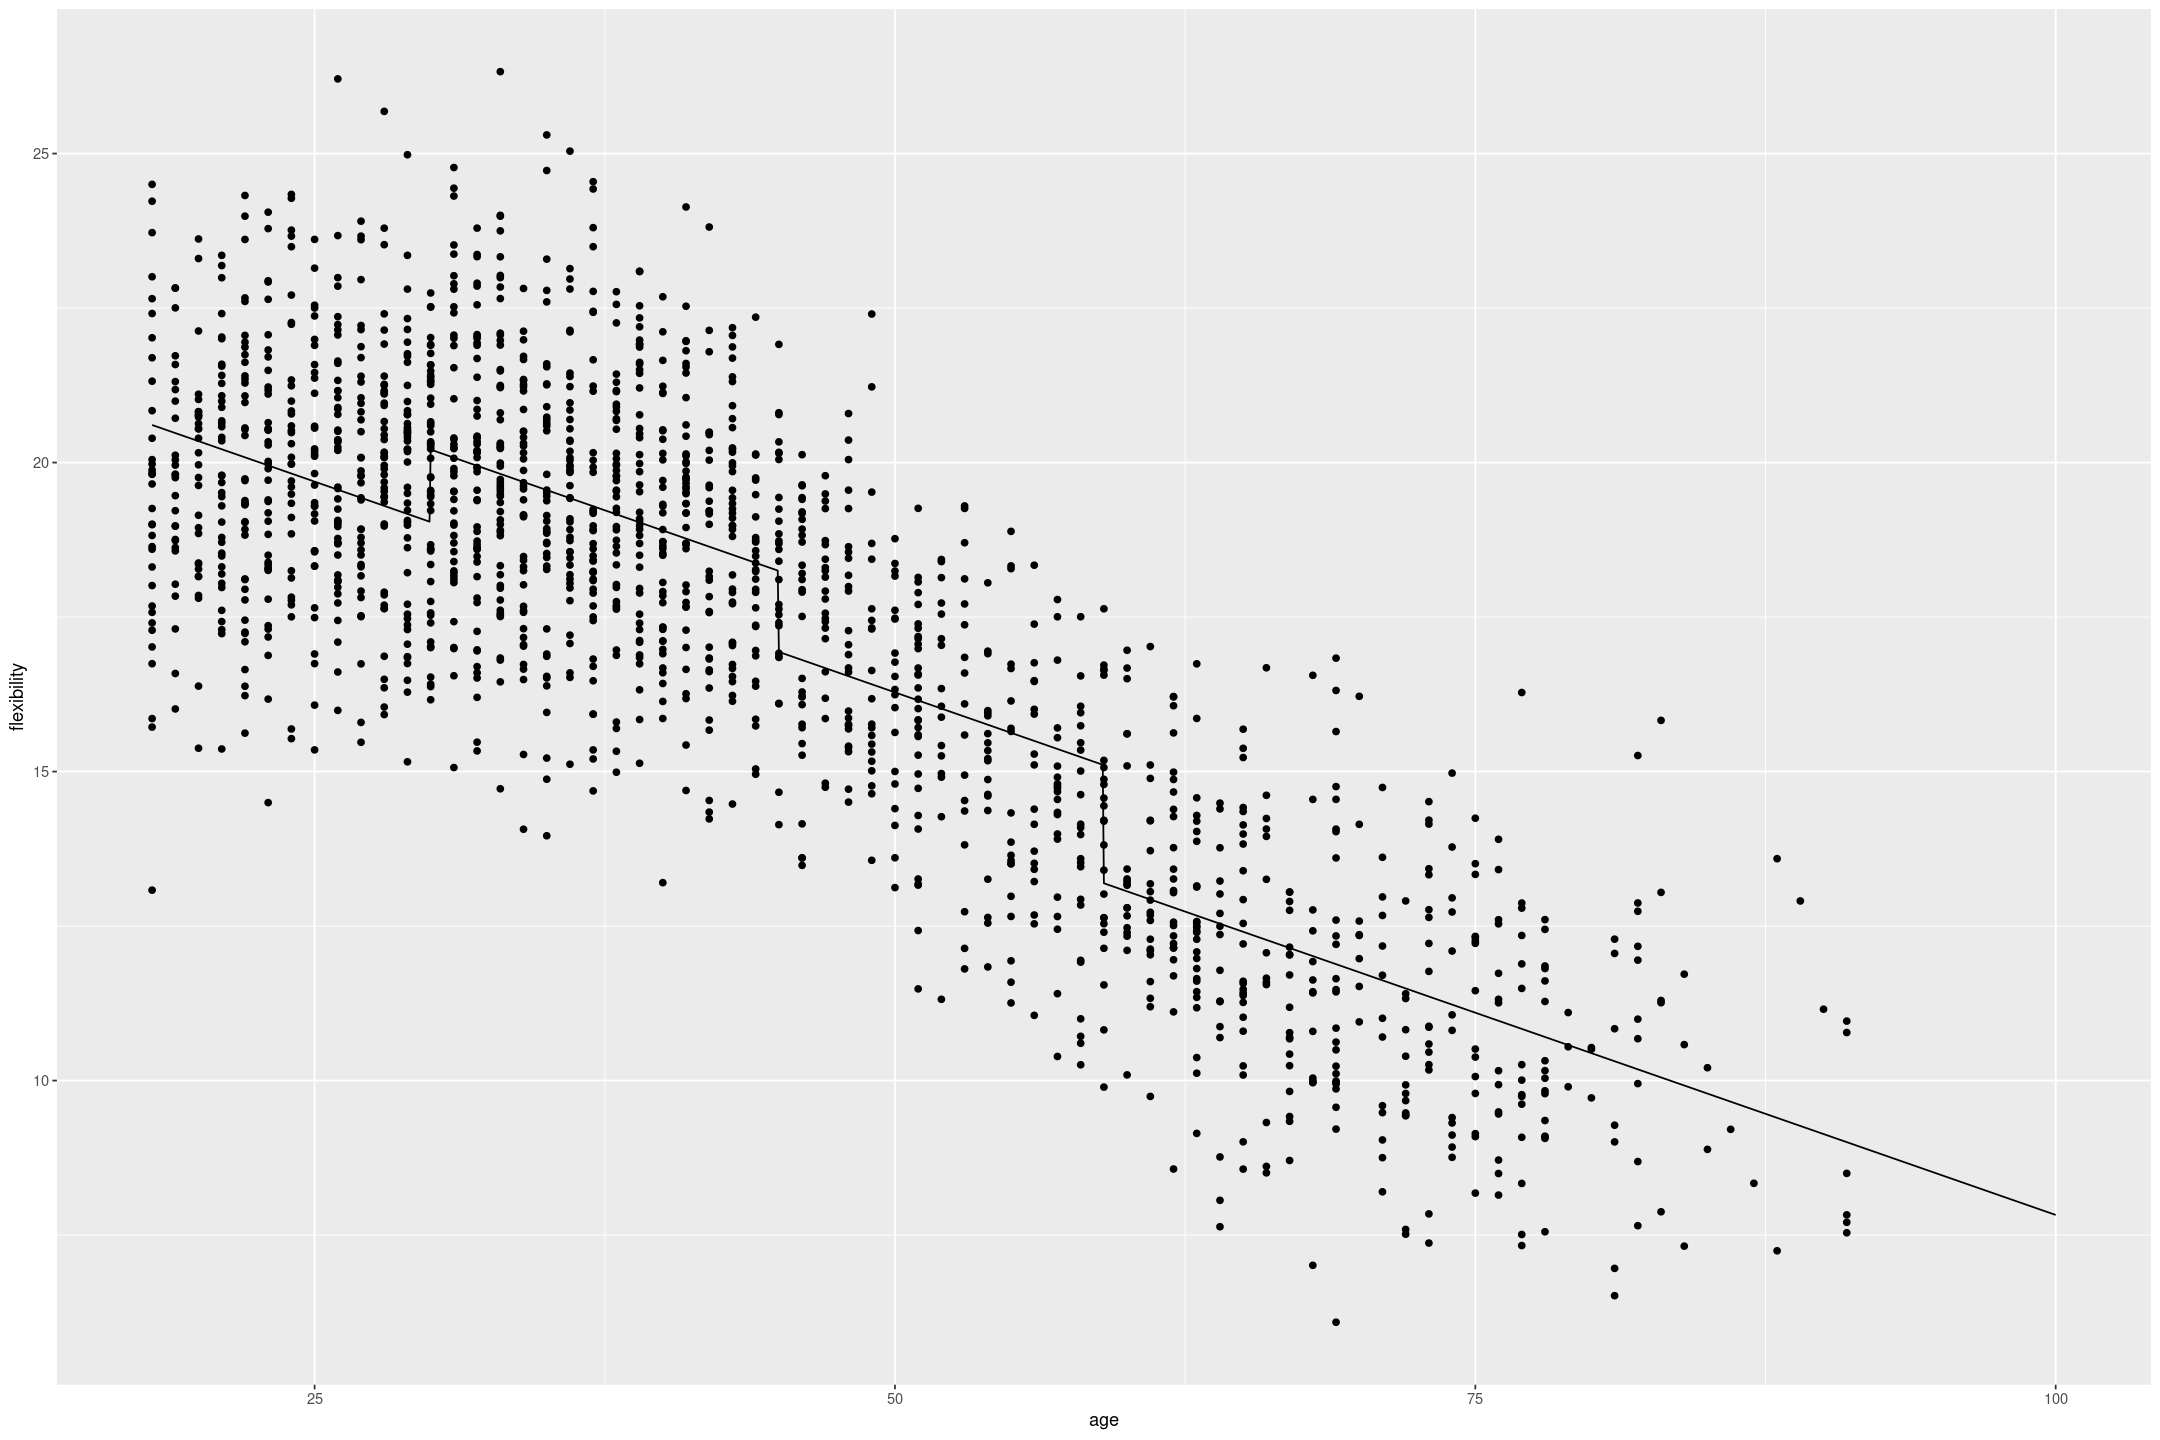

In [18]:
flexibility %>%
gf_point(flexibility ~ age) %>%
gf_line(pred ~ age, data=data.frame(age=seq(18, 100, by=0.05)) %>% mutate(age_group = age_grouper(age)) %>% add_predictions(flexibility_model))

# Logarithmic transformation and regression

Consider the following regression:

$$ \log(\rm{weight}) = - 3.8 + 2.1 \log(\rm{height}) + \rm{error}, $$

with errors that have standard deviation 0.25.
Weights are in pounds and heights are in inches.

## Fill in the blanks

Approximately 68% of people will heave weights within a factor of **exp(-0.25)=0.78** and **exp(0.25)=1.3** of their predicted values from the regression.

## Sketch

Using a pen and paper, sketch the regression line and scaterrplot or log(weight) versus log(height) that make sense and are consistent with the fitted model.
Be sure to label the axes of your graph.

This required a bit of prior calculation remembering a couple of facts:

* 1 kg ~ 2.2 lbs
* 1 inch ~ 2.5cm
* e^3 ~ 20
* ln(2) ~ 0.69

Heights are around 160-200cm. Using the above approximations gives 

* 160cm ~ 64"
* 200cm ~ 80"

And

$$ \ln(64) = \ln(2^6) = 6 \ln(2) \approx 6 \times 0.7 = 4.2 $$

$$ \ln(80) = \ln(2^2 * 20) = 2 \ln(2) + \ln(20) \approx 2 \times 0.7 + 3 = 4.4 $$

Putting in 4.2-4.4 in the equation $ \log(\rm{weight}) = - 3.8 + 2.1 \log(\rm{height}) $, gives log weights in the range 5-5.4.

Checking this:
$$ e^5.1 \,{\rm lbs} = e^3 \times \left(e^{0.7}\right)^3 \,{\rm lbs} \approx 20 * 8 \,{\rm lbs} = 160 \,{\rm lbs}$$

And $$ 160 \,\rm{lbs} = 160 / 2.2 \,{\rm kg} \approx 75 {\rm kg} $$

which is in the right ballpark for a lower end weight (and multiplying by 1.3, getting around 100kg is also a reasonable upper end weight).

With these ranges in mind I can make a sketch:

![Sketch](images/ros_12_5.jpeg)

### Checking against simulated data

My diagram is pretty reasonable, except (again) for not having enough large outliers.

Warning message:
“geom_abline(): Ignoring `mapping` because `slope` and/or `intercept` were provided.”


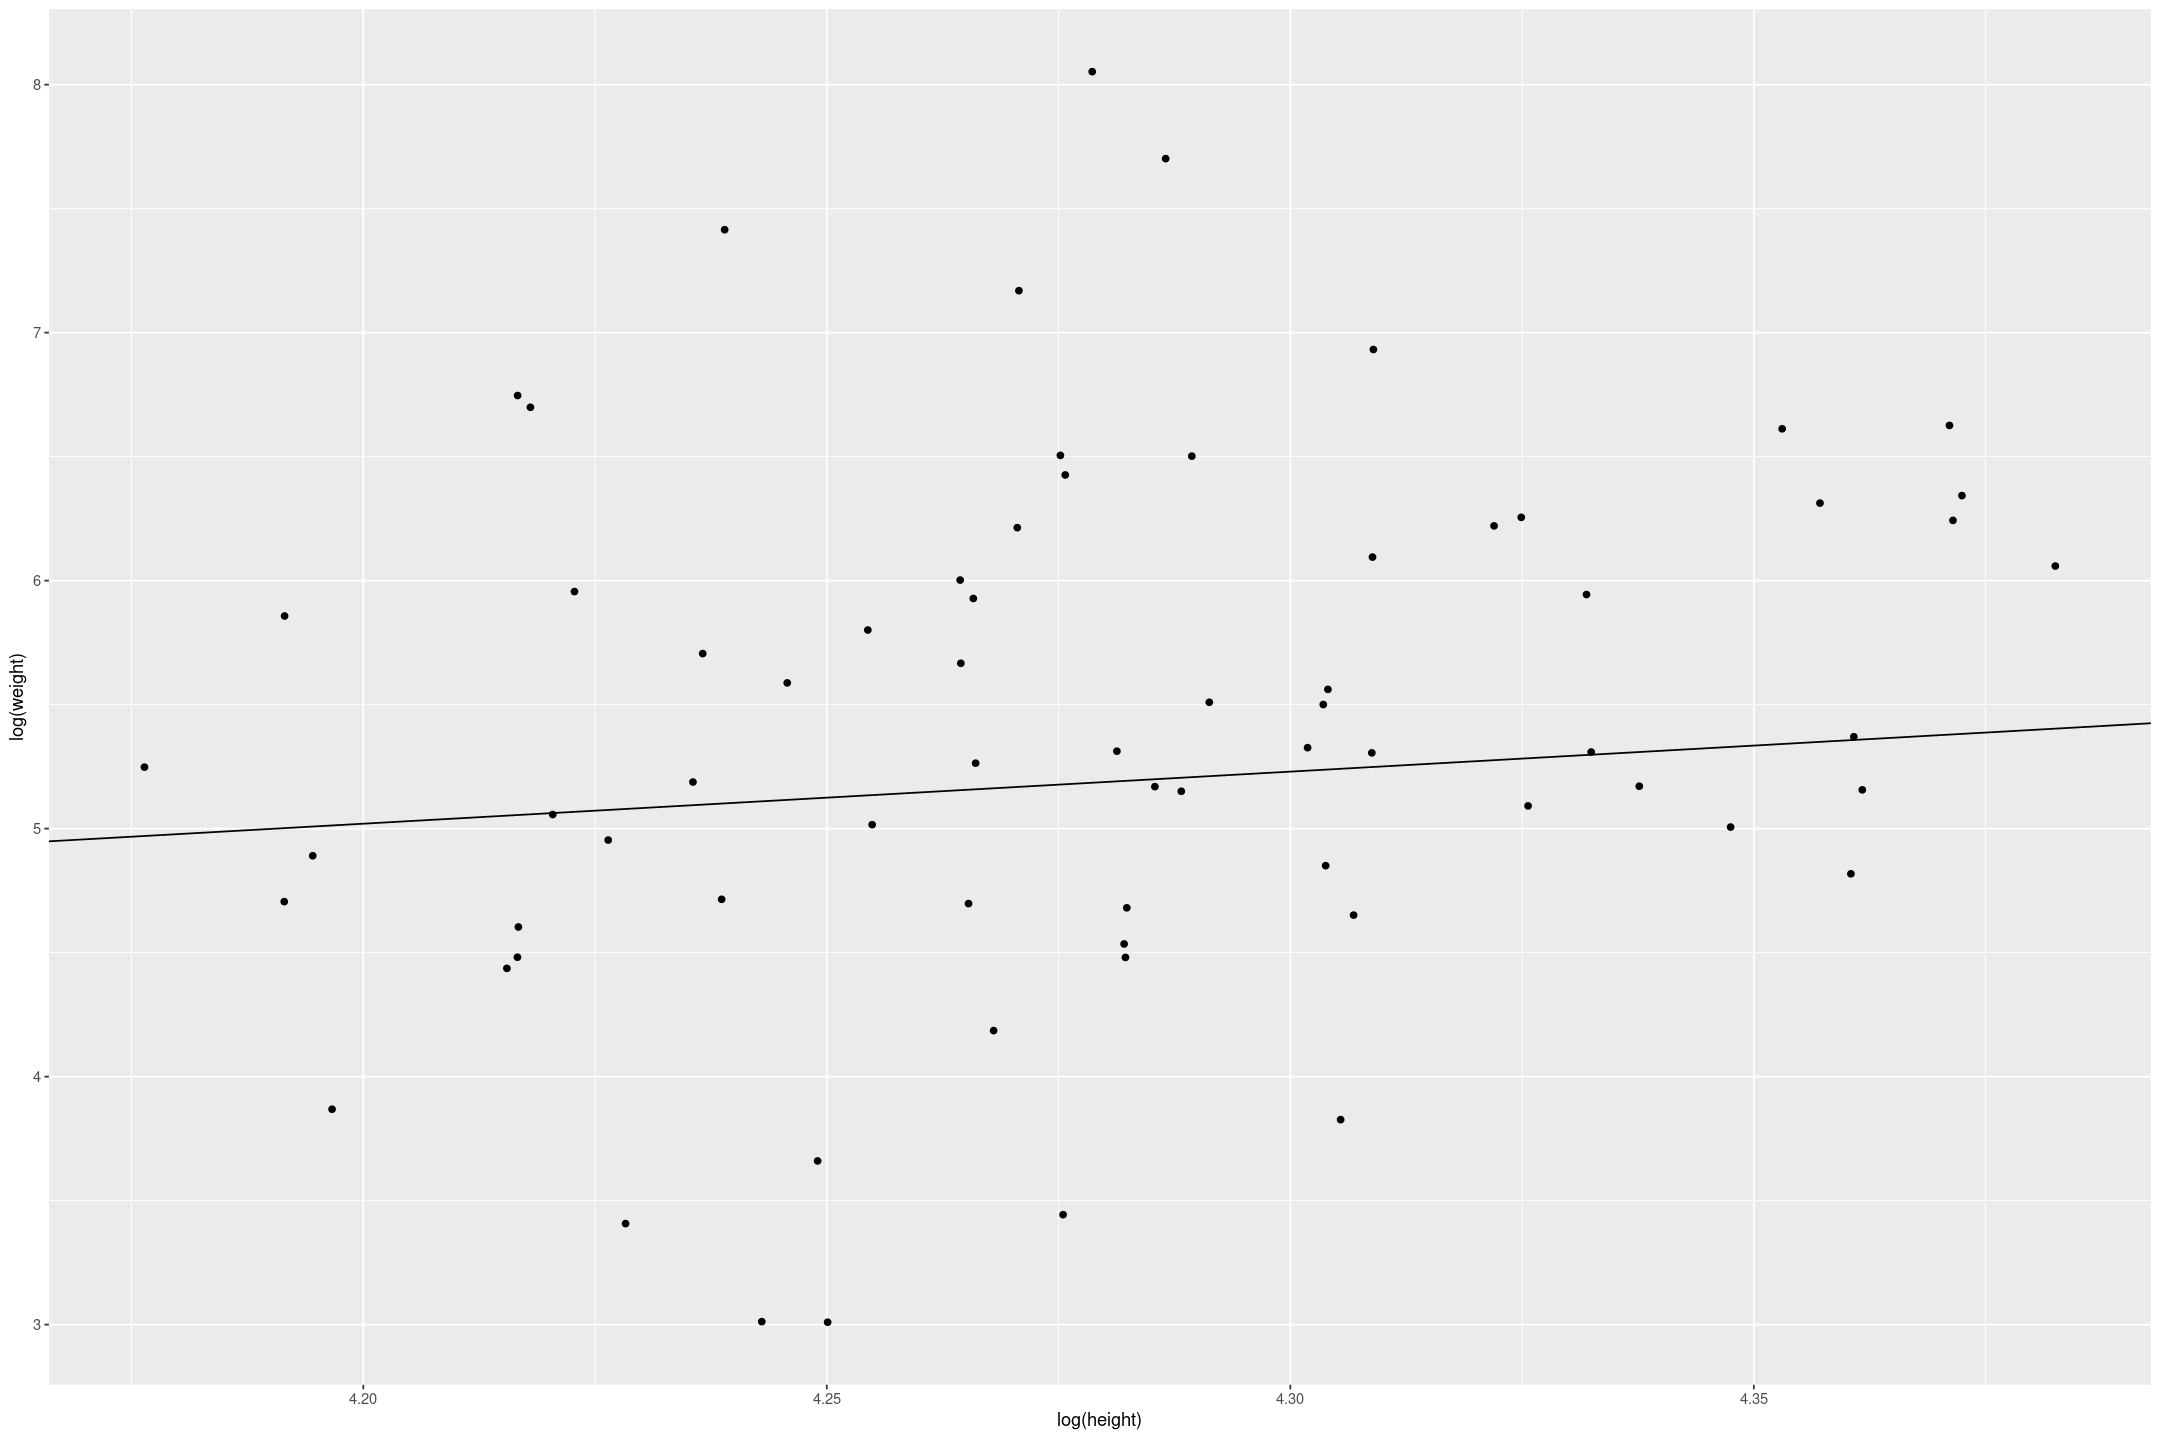

In [19]:
n <- 70
data.frame(height = rnorm(n,72,4)) %>%
mutate(weight = exp(-3.8 + 2.1 * log(height) + rnorm(n, 0.25))) %>%
gf_point(log(weight) ~ log(height)) %>%
gf_abline(intercept=-3.8, slope=2.1)

# Logarithmic transformations

The folder [`Pollution`](https://github.com/avehtari/ROS-Examples/tree/master/Pollution/) contains mortality rates and various environmental factors from 60 U.S. metropolitan areas (see [McDonald and Schwing, 1973](https://www.tandfonline.com/doi/abs/10.1080/00401706.1973.10489073)).
For this exercise we shall model mortality rate given nitric oxides, sulfur dioxide, and hydrocarbons as inputs.
This model is an extreme oversimplification, as it combines all sources of mortality and does not adjust for crucial factors such as age and smoking.
We use it to illustrate log transformations in regression.

In [20]:
filename <- "./data/Polution/pollution.csv"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Pollution/data/pollution.csv')
pollution <- read.csv(filename, header=TRUE)

In [21]:
nrow(pollution)

[1] 60

In [22]:
pollution %>% head()

,prec,jant,jult,ovr65,popn,educ,hous,dens,nonw,wwdrk,poor,hc,nox,so2,humid,mort
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,36,27,71,8.1,3.34,11.4,81.5,3243,8.8,42.6,11.7,21,15,59,59,921.870
2,35,23,72,11.1,3.14,11.0,78.8,4281,3.5,50.7,14.4,8,10,39,57,997.875
3,44,29,74,10.4,3.21,9.8,81.6,4260,0.8,39.4,12.4,6,6,33,54,962.354
4,47,45,79,6.5,3.41,11.1,77.5,3125,27.1,50.2,20.6,18,8,24,56,982.291
5,43,35,77,7.6,3.44,9.6,84.6,6441,24.4,43.7,14.3,43,38,206,55,1071.289
6,53,45,80,7.7,3.45,10.2,66.8,3325,38.5,43.1,25.5,30,32,72,54,1030.380


## Linearity in Nitric Oxides

Create a scatterplot of mortality rate versus level of nitric oxides.
Do you think linear regression will fit these data well?
Fit the regression and evaluate a residual plot from the regression.

A linear regression would not fit these data at all well, a small increase in nitric oxides tends to correlate with a very large increase in mortality (except for some suspicious points with unusually high nitric oxide).

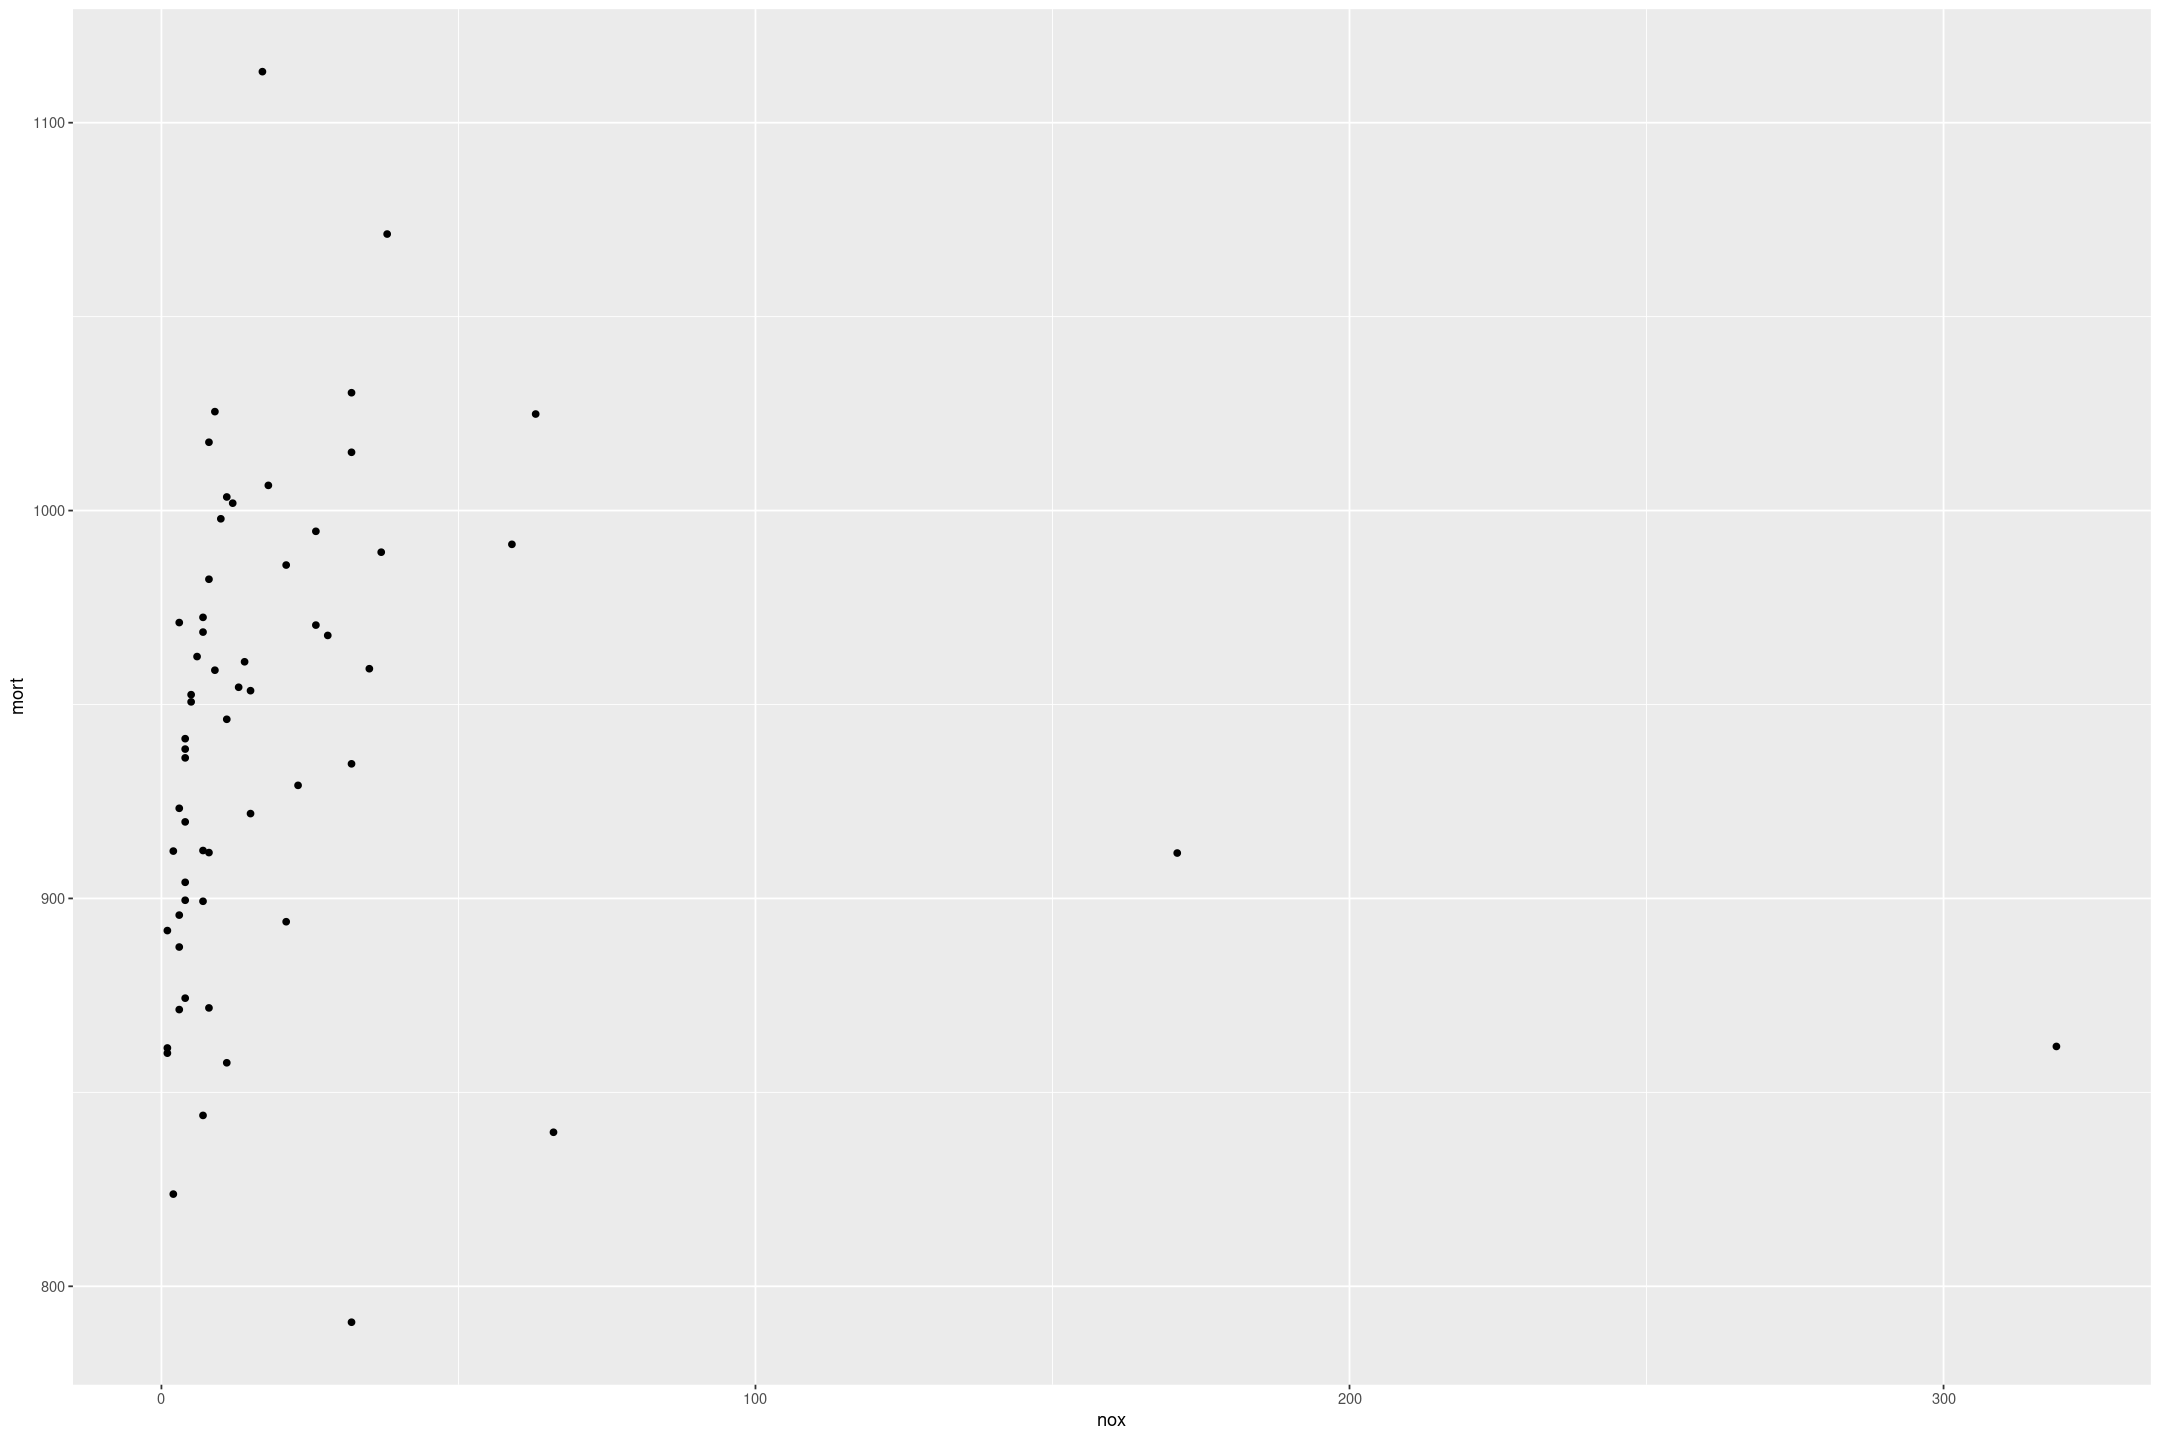

In [23]:
pollution %>%
gf_point(mort ~ nox)

In [24]:
(model_mort_linear_nox <- stan_glm(mort ~ nox, data=pollution, refresh=0))

stan_glm
 family:       gaussian [identity]
 formula:      mort ~ nox
 observations: 60
 predictors:   2
------
            Median MAD_SD
(Intercept) 942.7    8.9 
nox          -0.1    0.2 

Auxiliary parameter(s):
      Median MAD_SD
sigma 63.0    5.8  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

The residuals are very large and scattered.

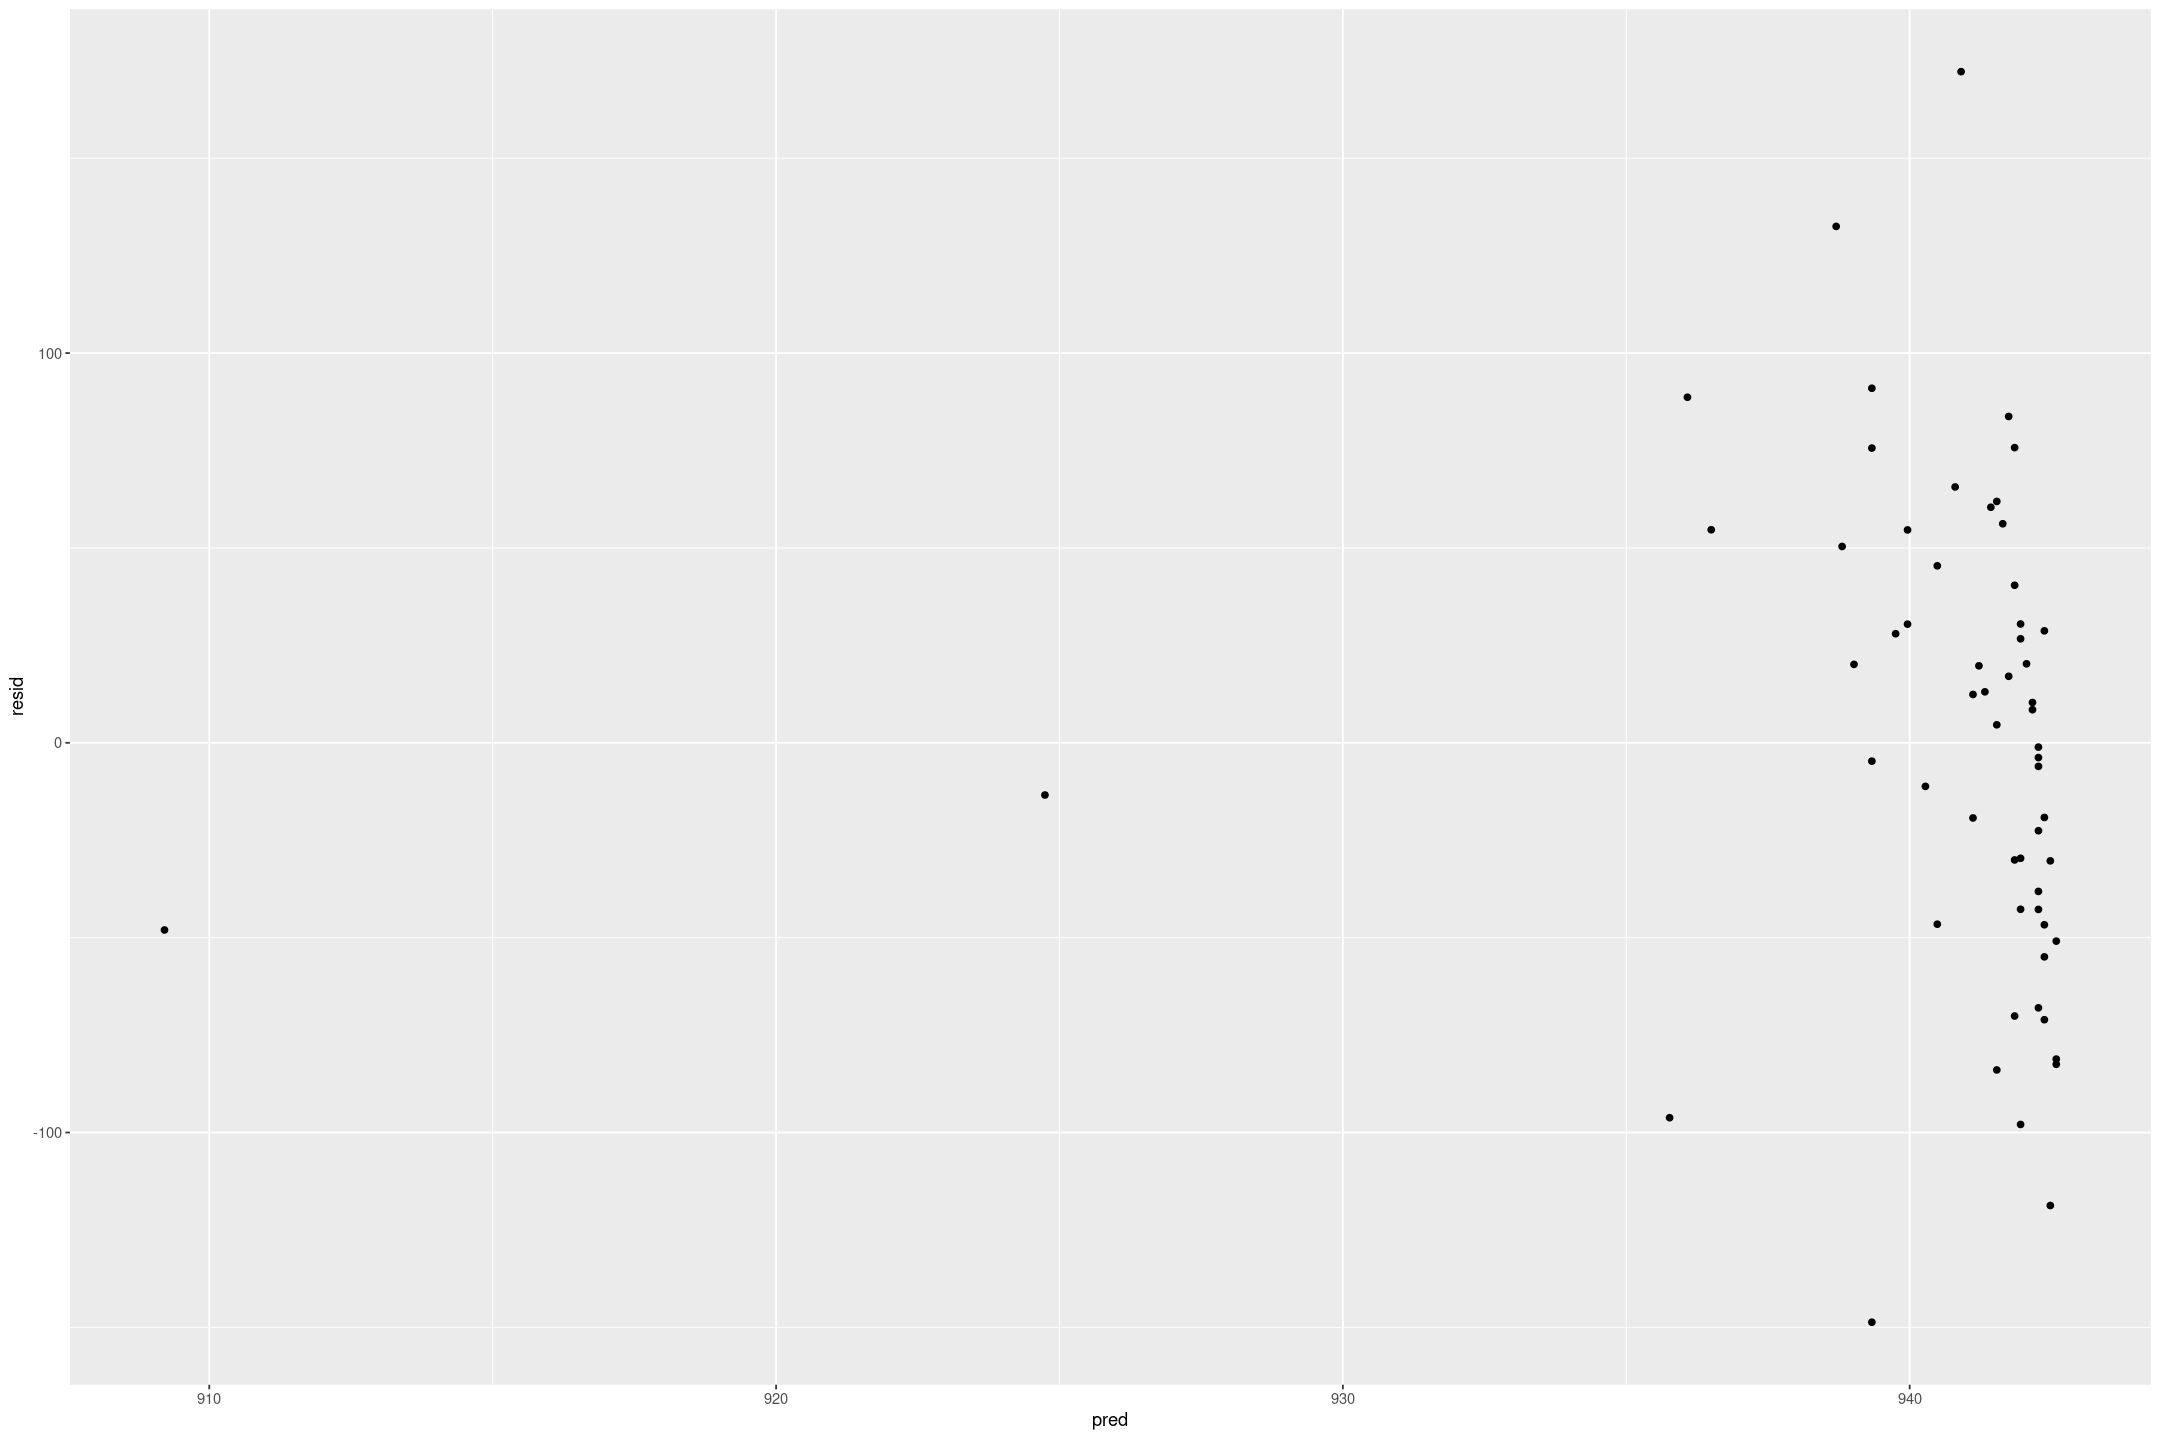

In [25]:
pollution %>%
add_residuals(model_mort_linear_nox) %>%
add_predictions(model_mort_linear_nox) %>%
gf_point(resid ~ pred)

## Transforming the data

Find an appropriate transformation that will result in data more appropriate for linear regression.
Fit a regression to the transformed data and evaluate the new residual plot.

Taking the log of Nitrous Oxides looks like it will create a much better model.
It's not immediately clear to me whether mortality should be scaled in a similar way.

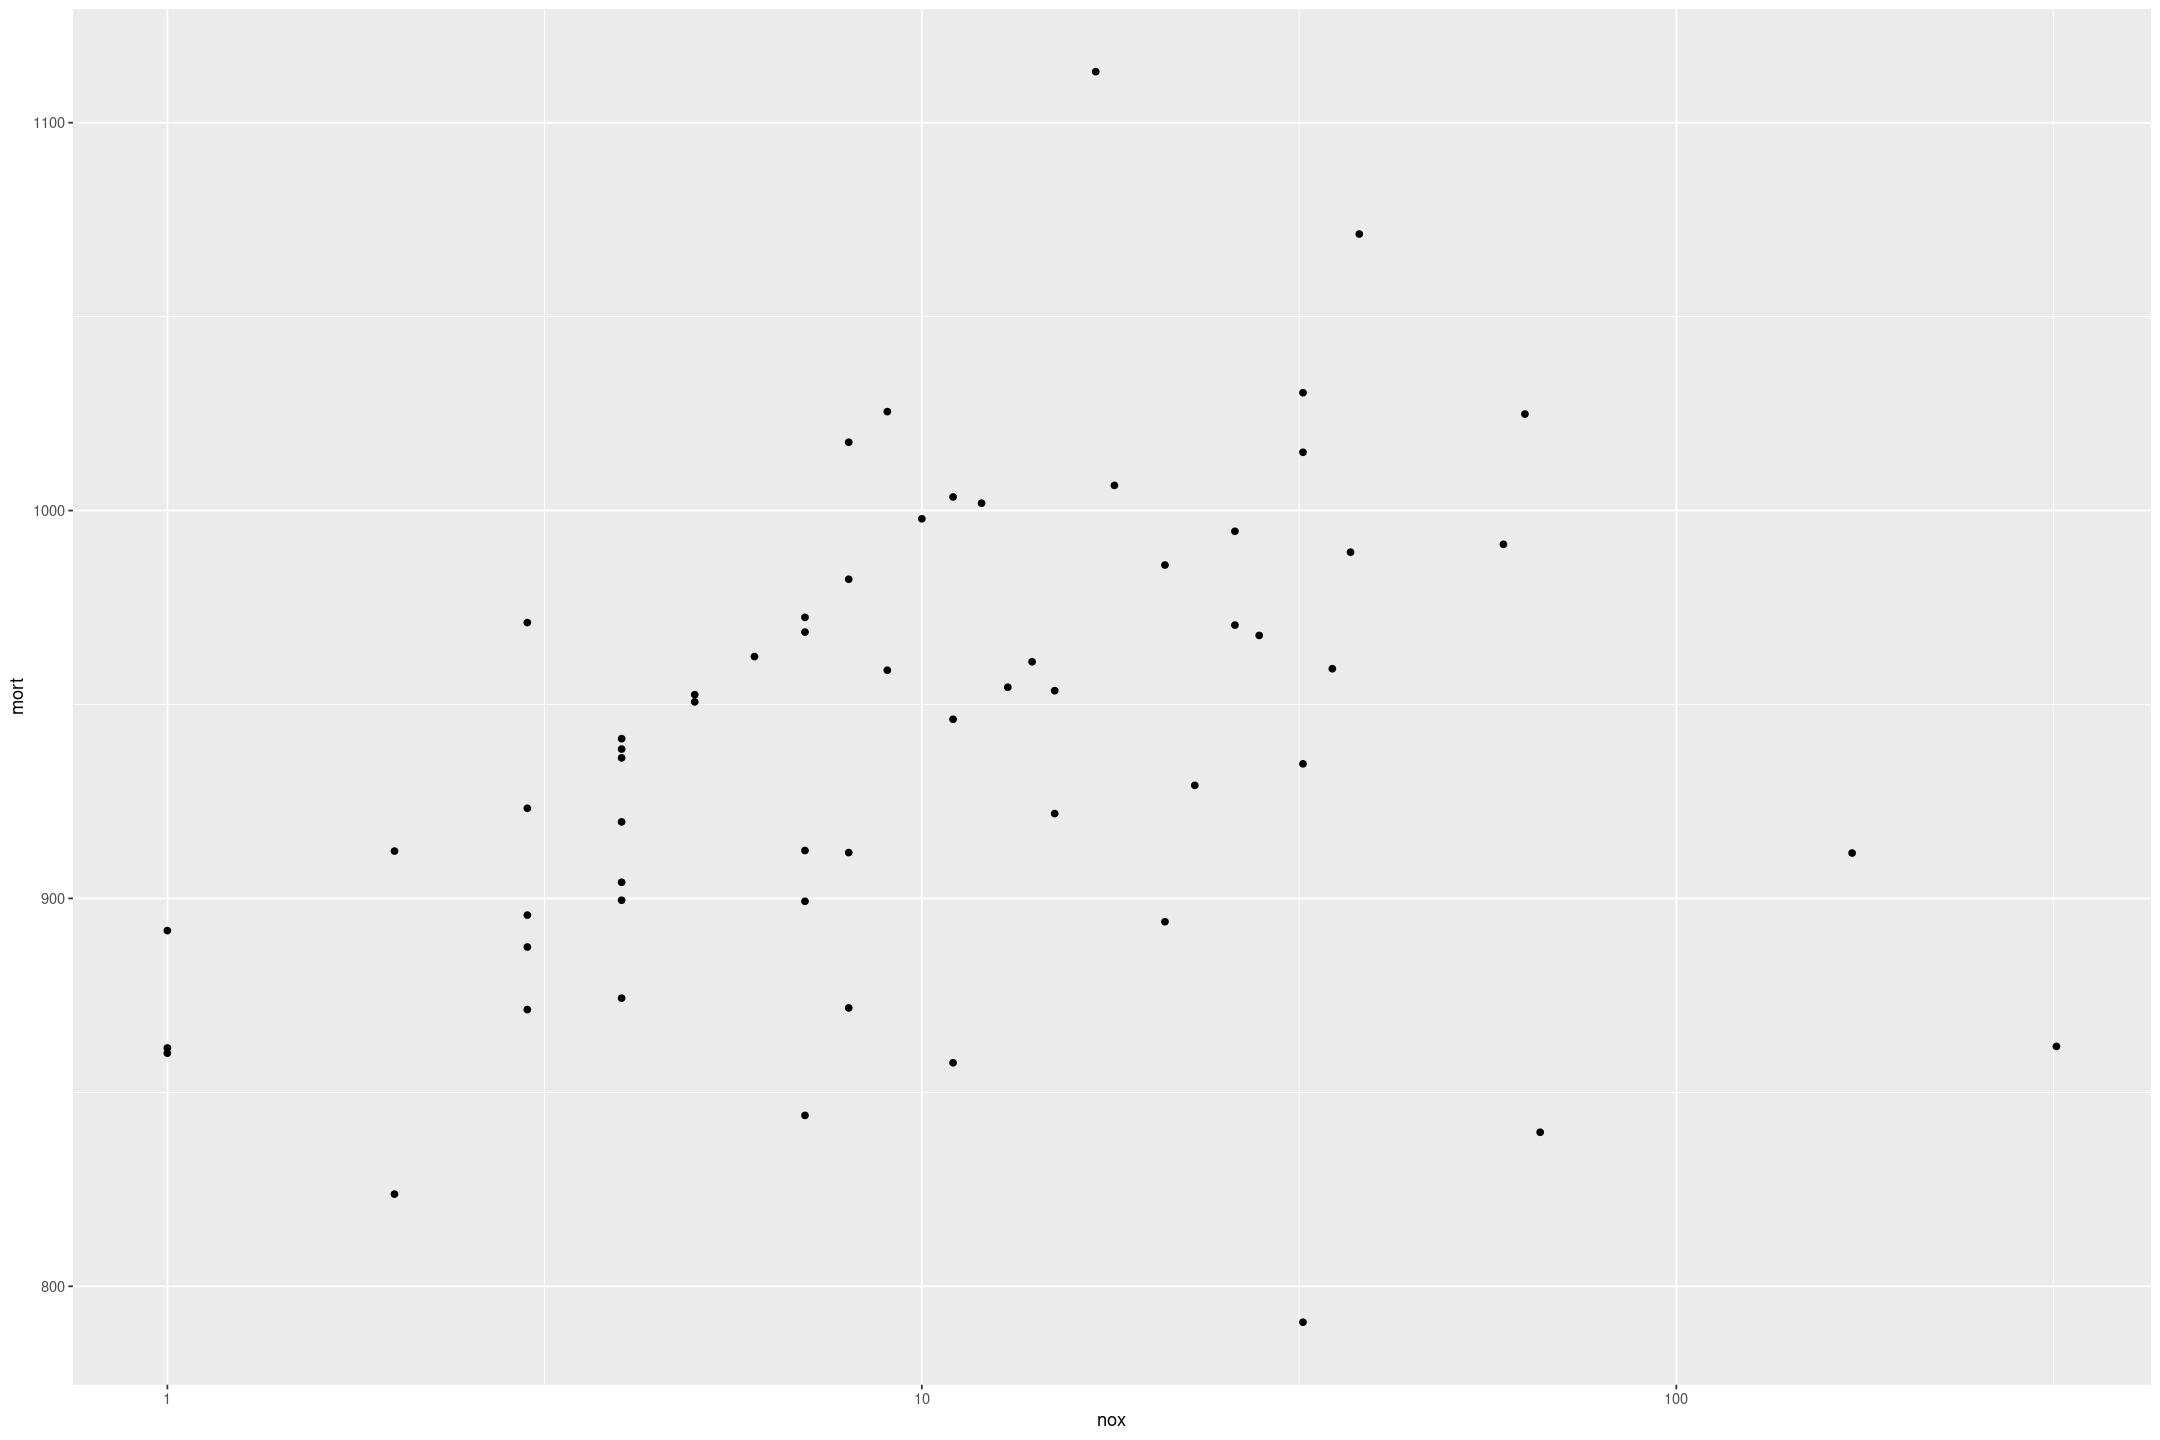

In [26]:
pollution %>%
gf_point(mort ~ nox) +
scale_x_log10()

In [27]:
(model_mort_log_nox <- stan_glm(mort ~ log(nox), data=pollution, refresh=0))

stan_glm
 family:       gaussian [identity]
 formula:      mort ~ log(nox)
 observations: 60
 predictors:   2
------
            Median MAD_SD
(Intercept) 905.2   17.0 
log(nox)     15.2    6.6 

Auxiliary parameter(s):
      Median MAD_SD
sigma 60.3    5.6  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

While not perfext, especially for large predictions, the predictions are in a more reasonable range.

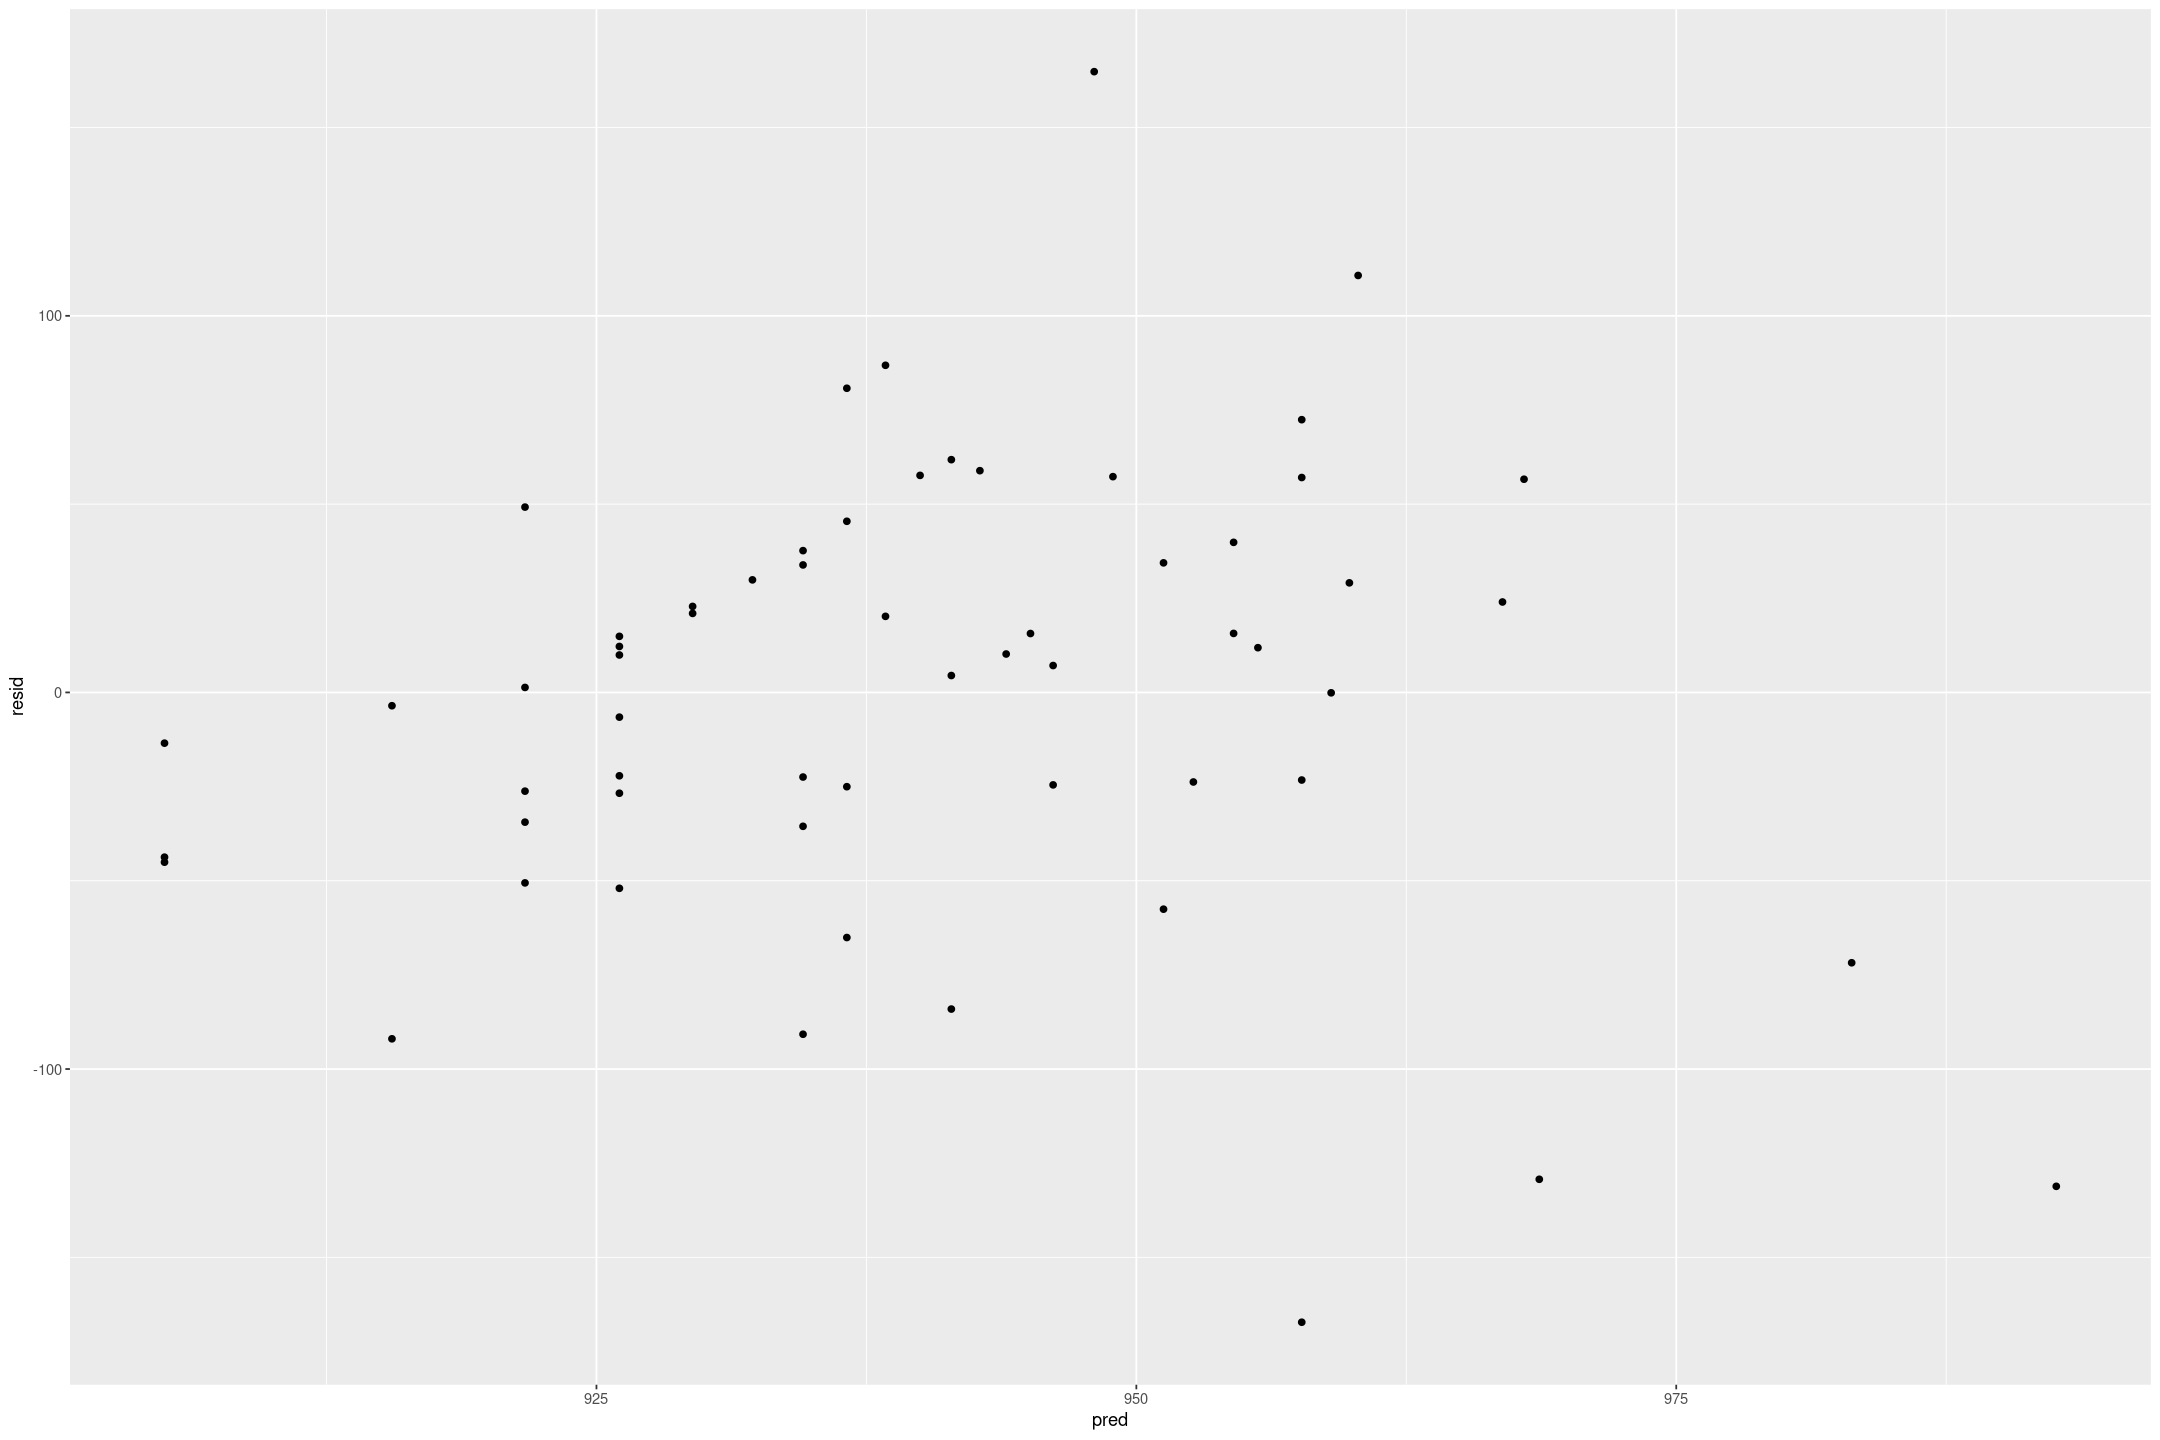

In [28]:
pollution %>%
add_residuals(model_mort_log_nox) %>%
add_predictions(model_mort_log_nox) %>%
gf_point(resid ~ pred)

Our metrics agree it's a bit better.

In [29]:
loo_mort_log_nox <- loo(model_mort_log_nox)
loo_mort_linear_nox <- loo(model_mort_linear_nox, k_threshold=0.7)

loo_compare(loo_mort_log_nox, loo_mort_linear_nox)

1 problematic observation(s) found.
Model will be refit 1 times.


Fitting model 1 out of 1 (leaving out observation 29)



,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model_mort_log_nox,0.000000,0.000000,-333.5096,6.928916,3.963118,1.260363,667.0191,13.85783
model_mort_linear_nox,-2.416292,2.878718,-335.9259,5.824528,3.336066,1.325111,671.8517,11.64906


## Intepreting Models on Transformed Data

Interpret the slope coefficient from the model you chose in (b).

A 10% increase in nitrous oxides corresponds to a roughly 1.5 increase in mortality rate.

## Adding Sulfur Dioxide and Hydrocarbons as Predictors

Now fit a model predicting mortality rate using levels of nitric oxides, sulfur dioxide, and hydrocarbons as inputs.
Use appropriate transformations when helpful.
Plot the fitted regression model and interpred the coefficients.

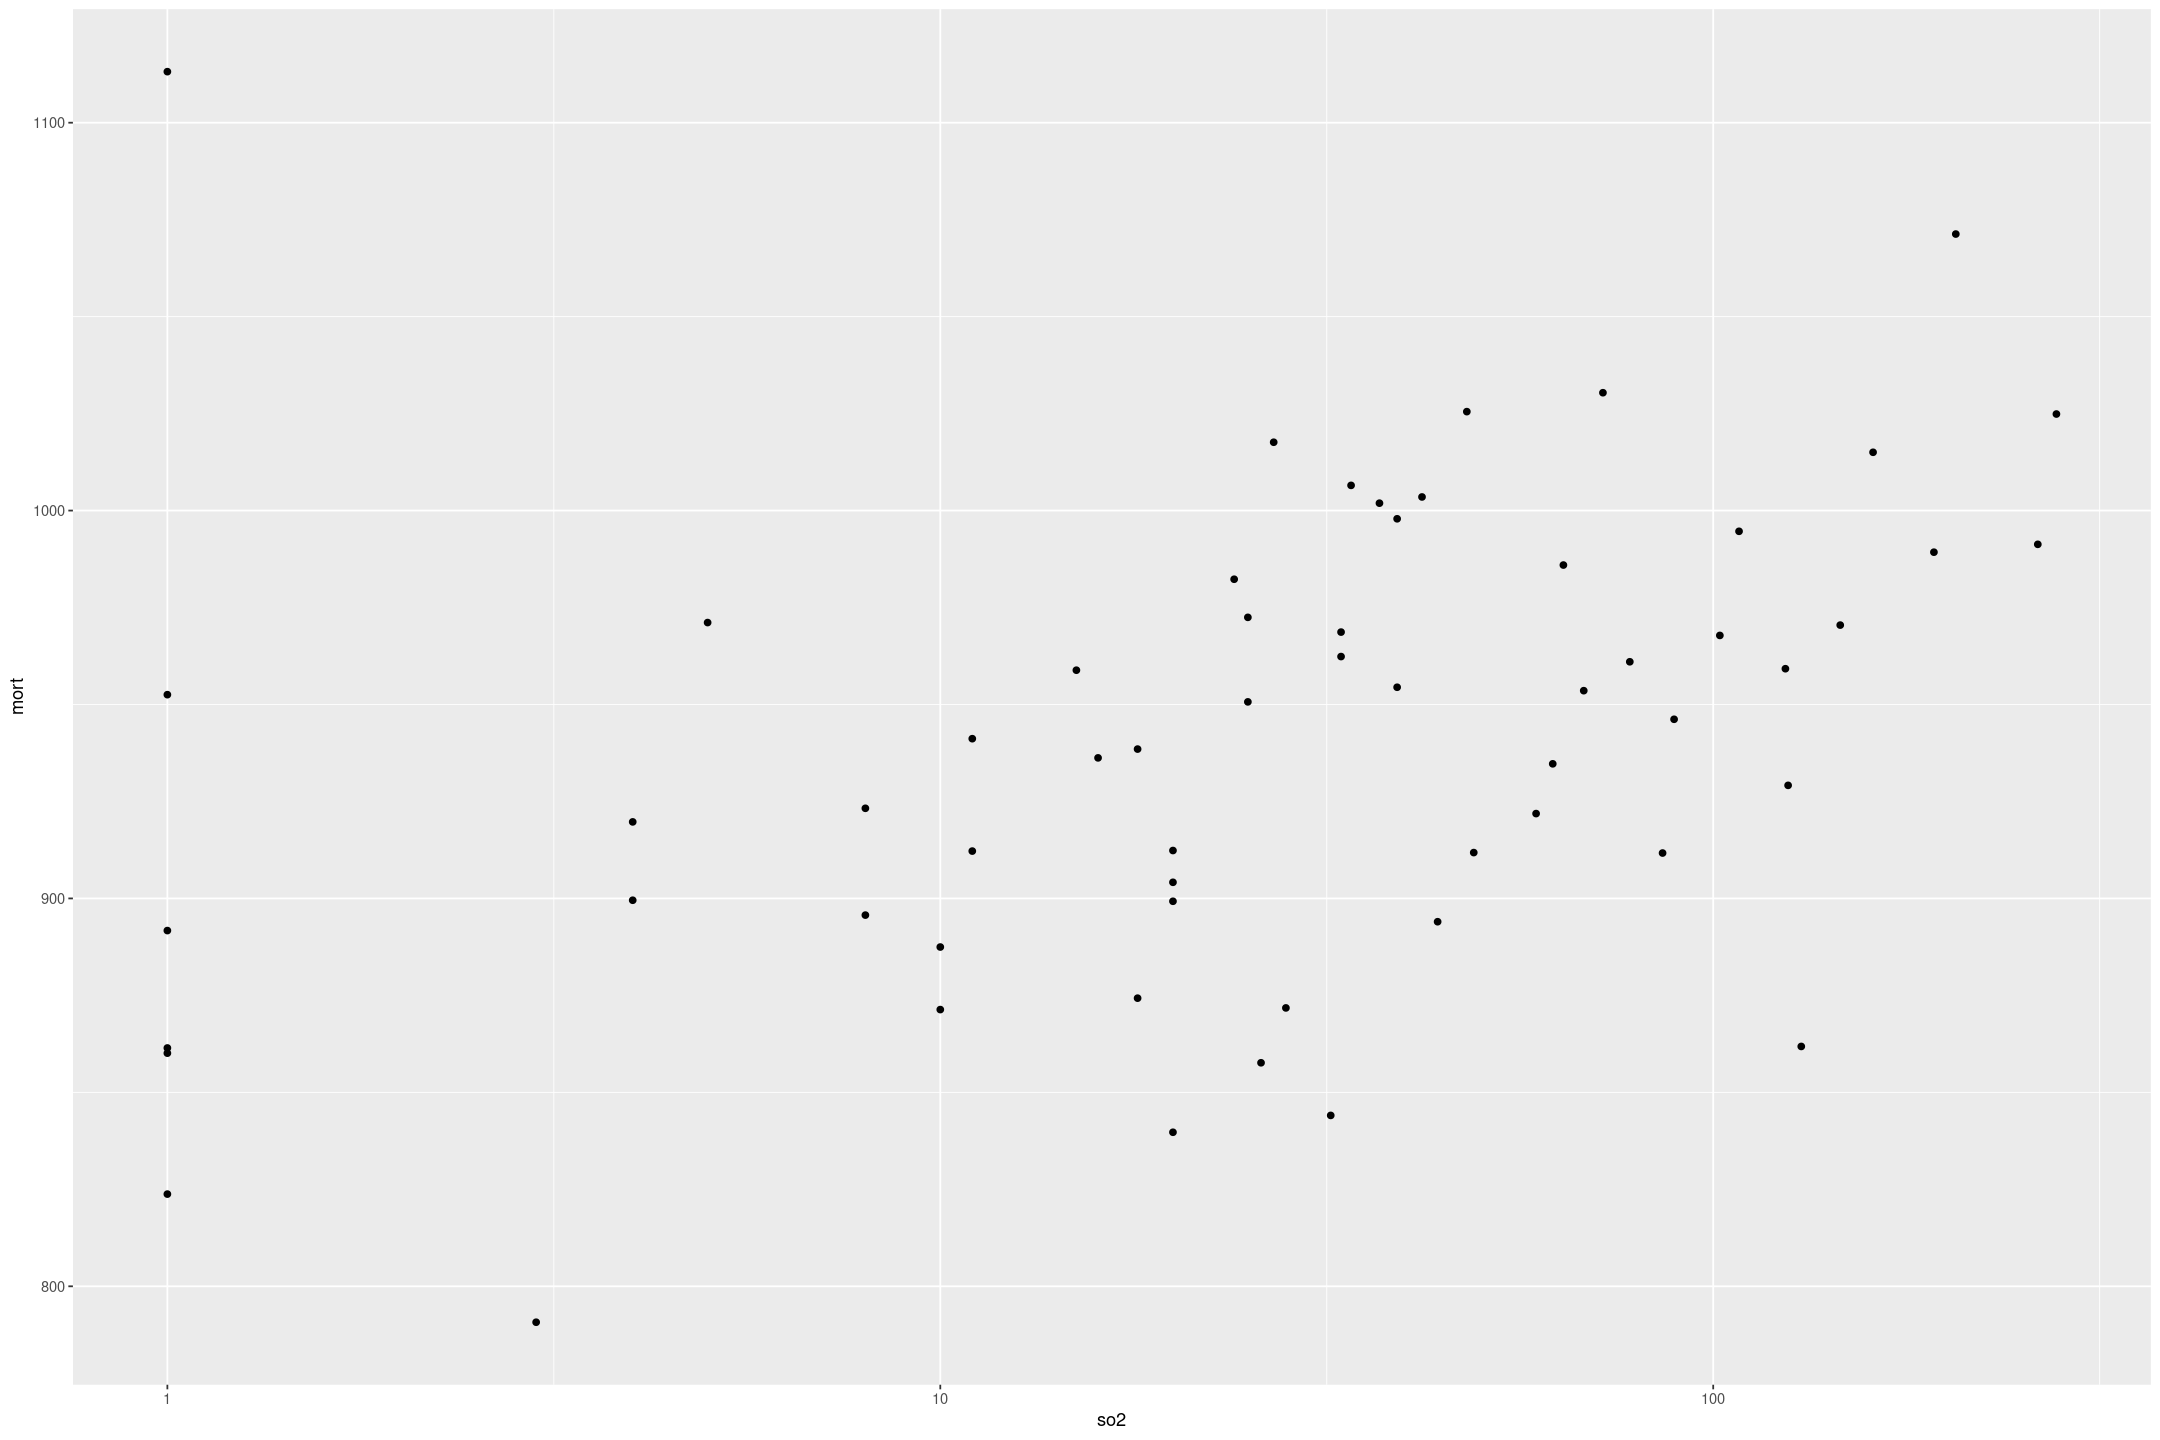

In [30]:
pollution %>%
gf_point(mort ~ so2) +
scale_x_log10()

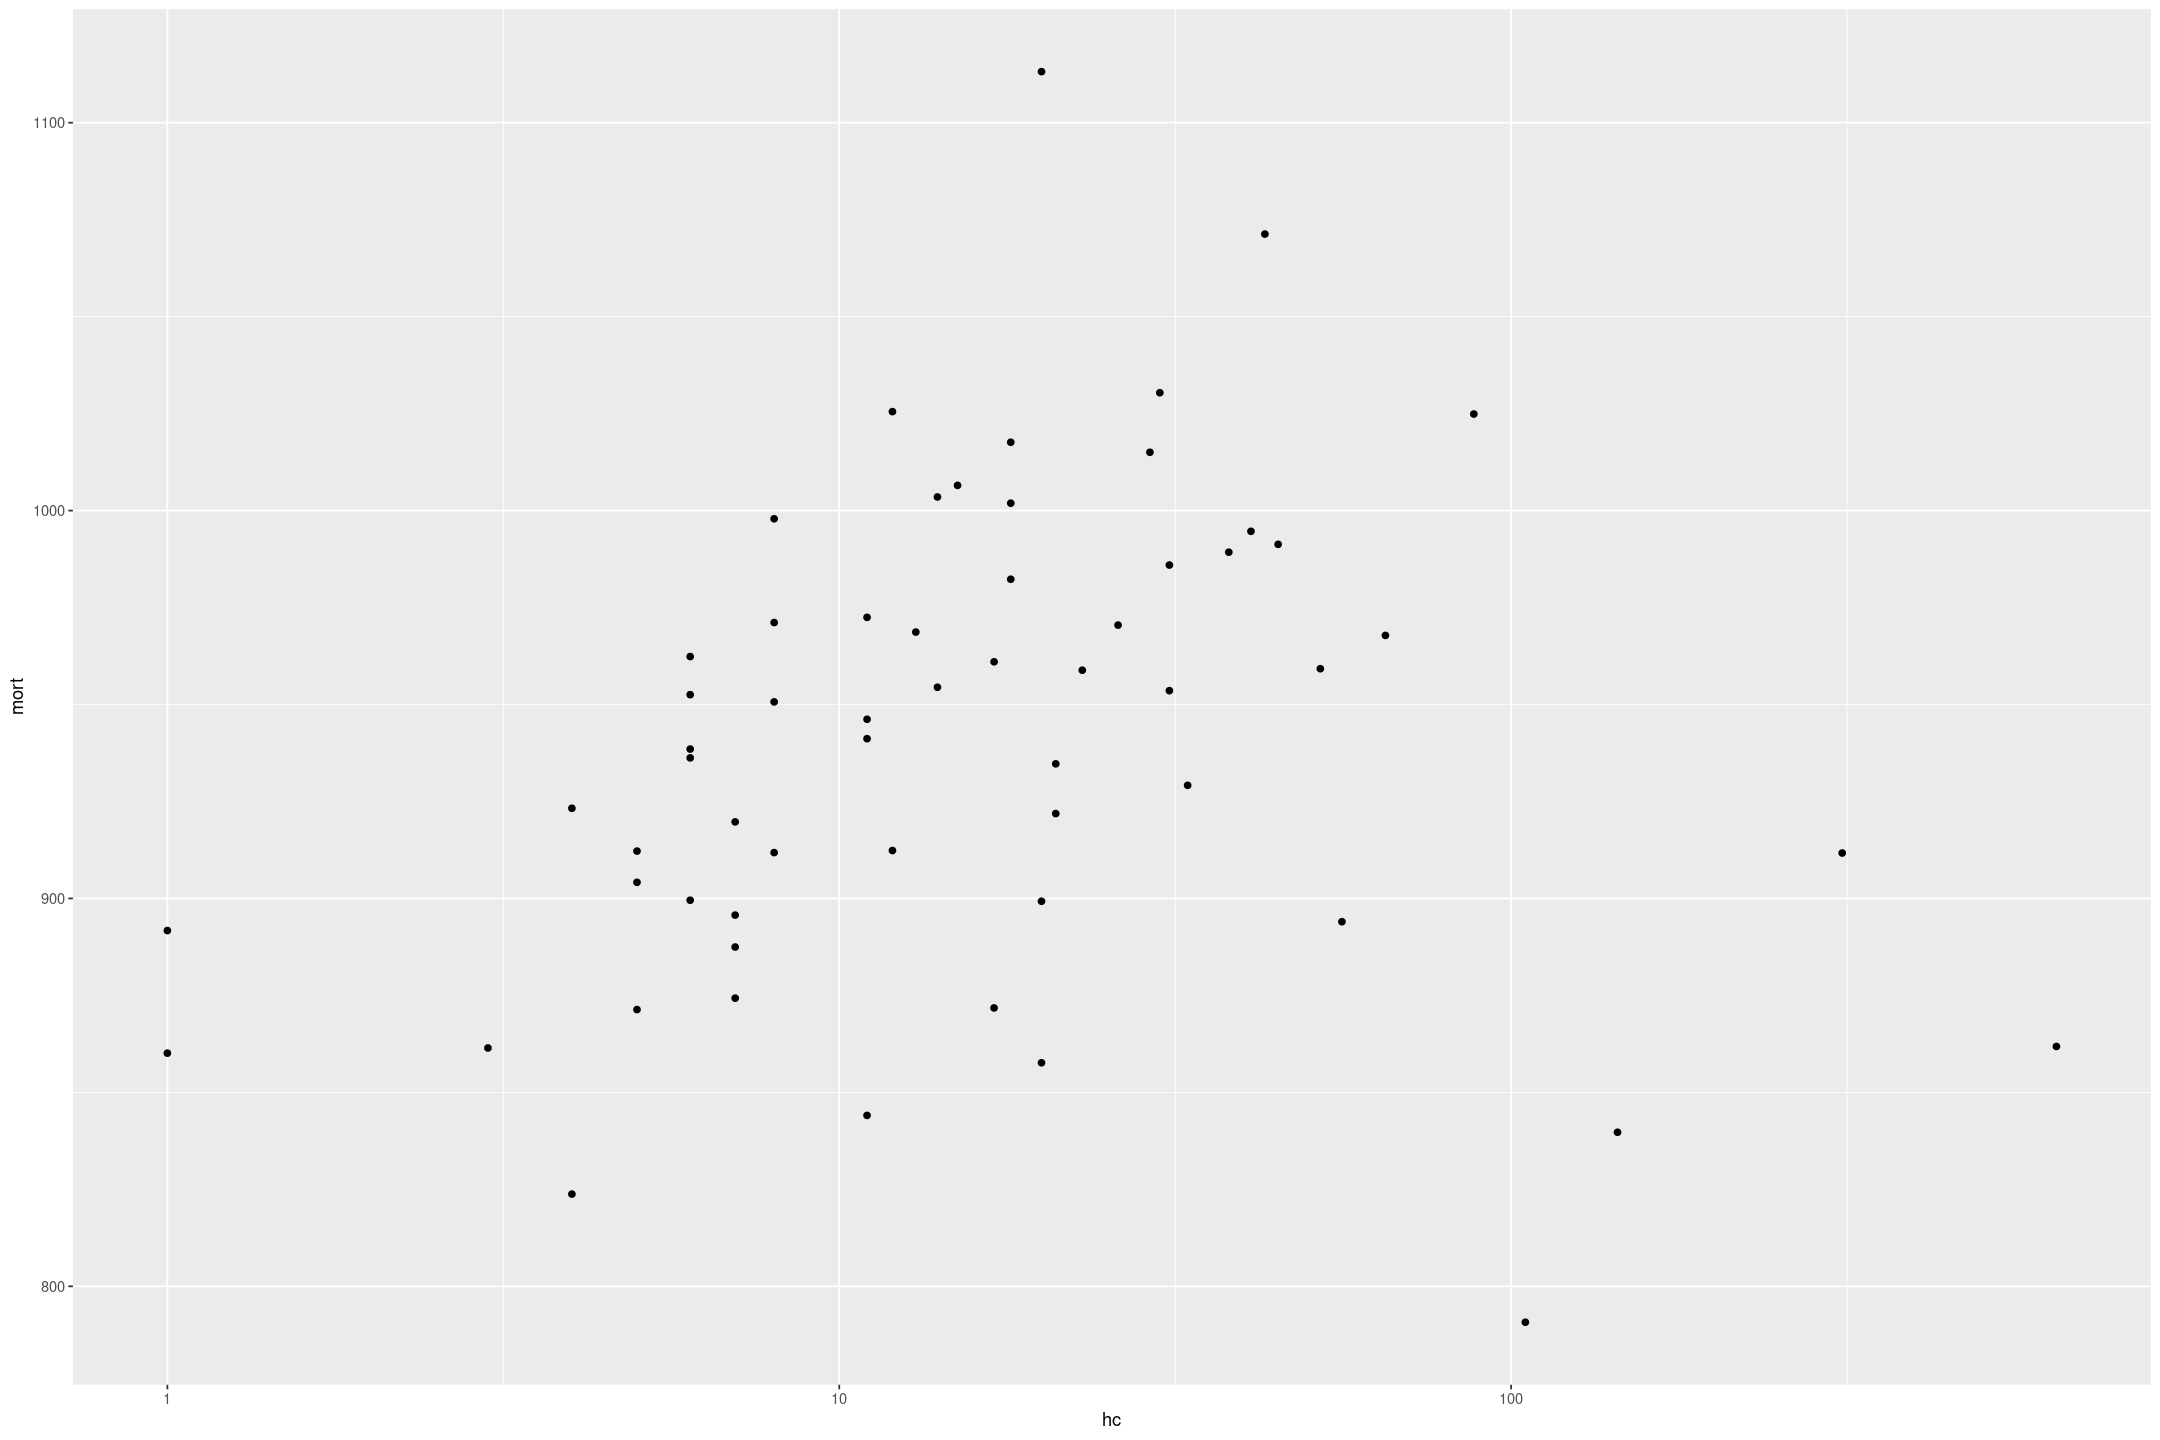

In [31]:
pollution %>%
gf_point(mort ~ hc) +
scale_x_log10()

In [32]:
(model_mort_log_pollutants <- stan_glm(mort ~ log(nox) + log(so2) + log(hc), data=pollution, refresh=0))

stan_glm
 family:       gaussian [identity]
 formula:      mort ~ log(nox) + log(so2) + log(hc)
 observations: 60
 predictors:   4
------
            Median MAD_SD
(Intercept) 923.2   21.9 
log(nox)     56.1   20.4 
log(so2)     12.1    7.1 
log(hc)     -55.3   18.4 

Auxiliary parameter(s):
      Median MAD_SD
sigma 54.8    5.1  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

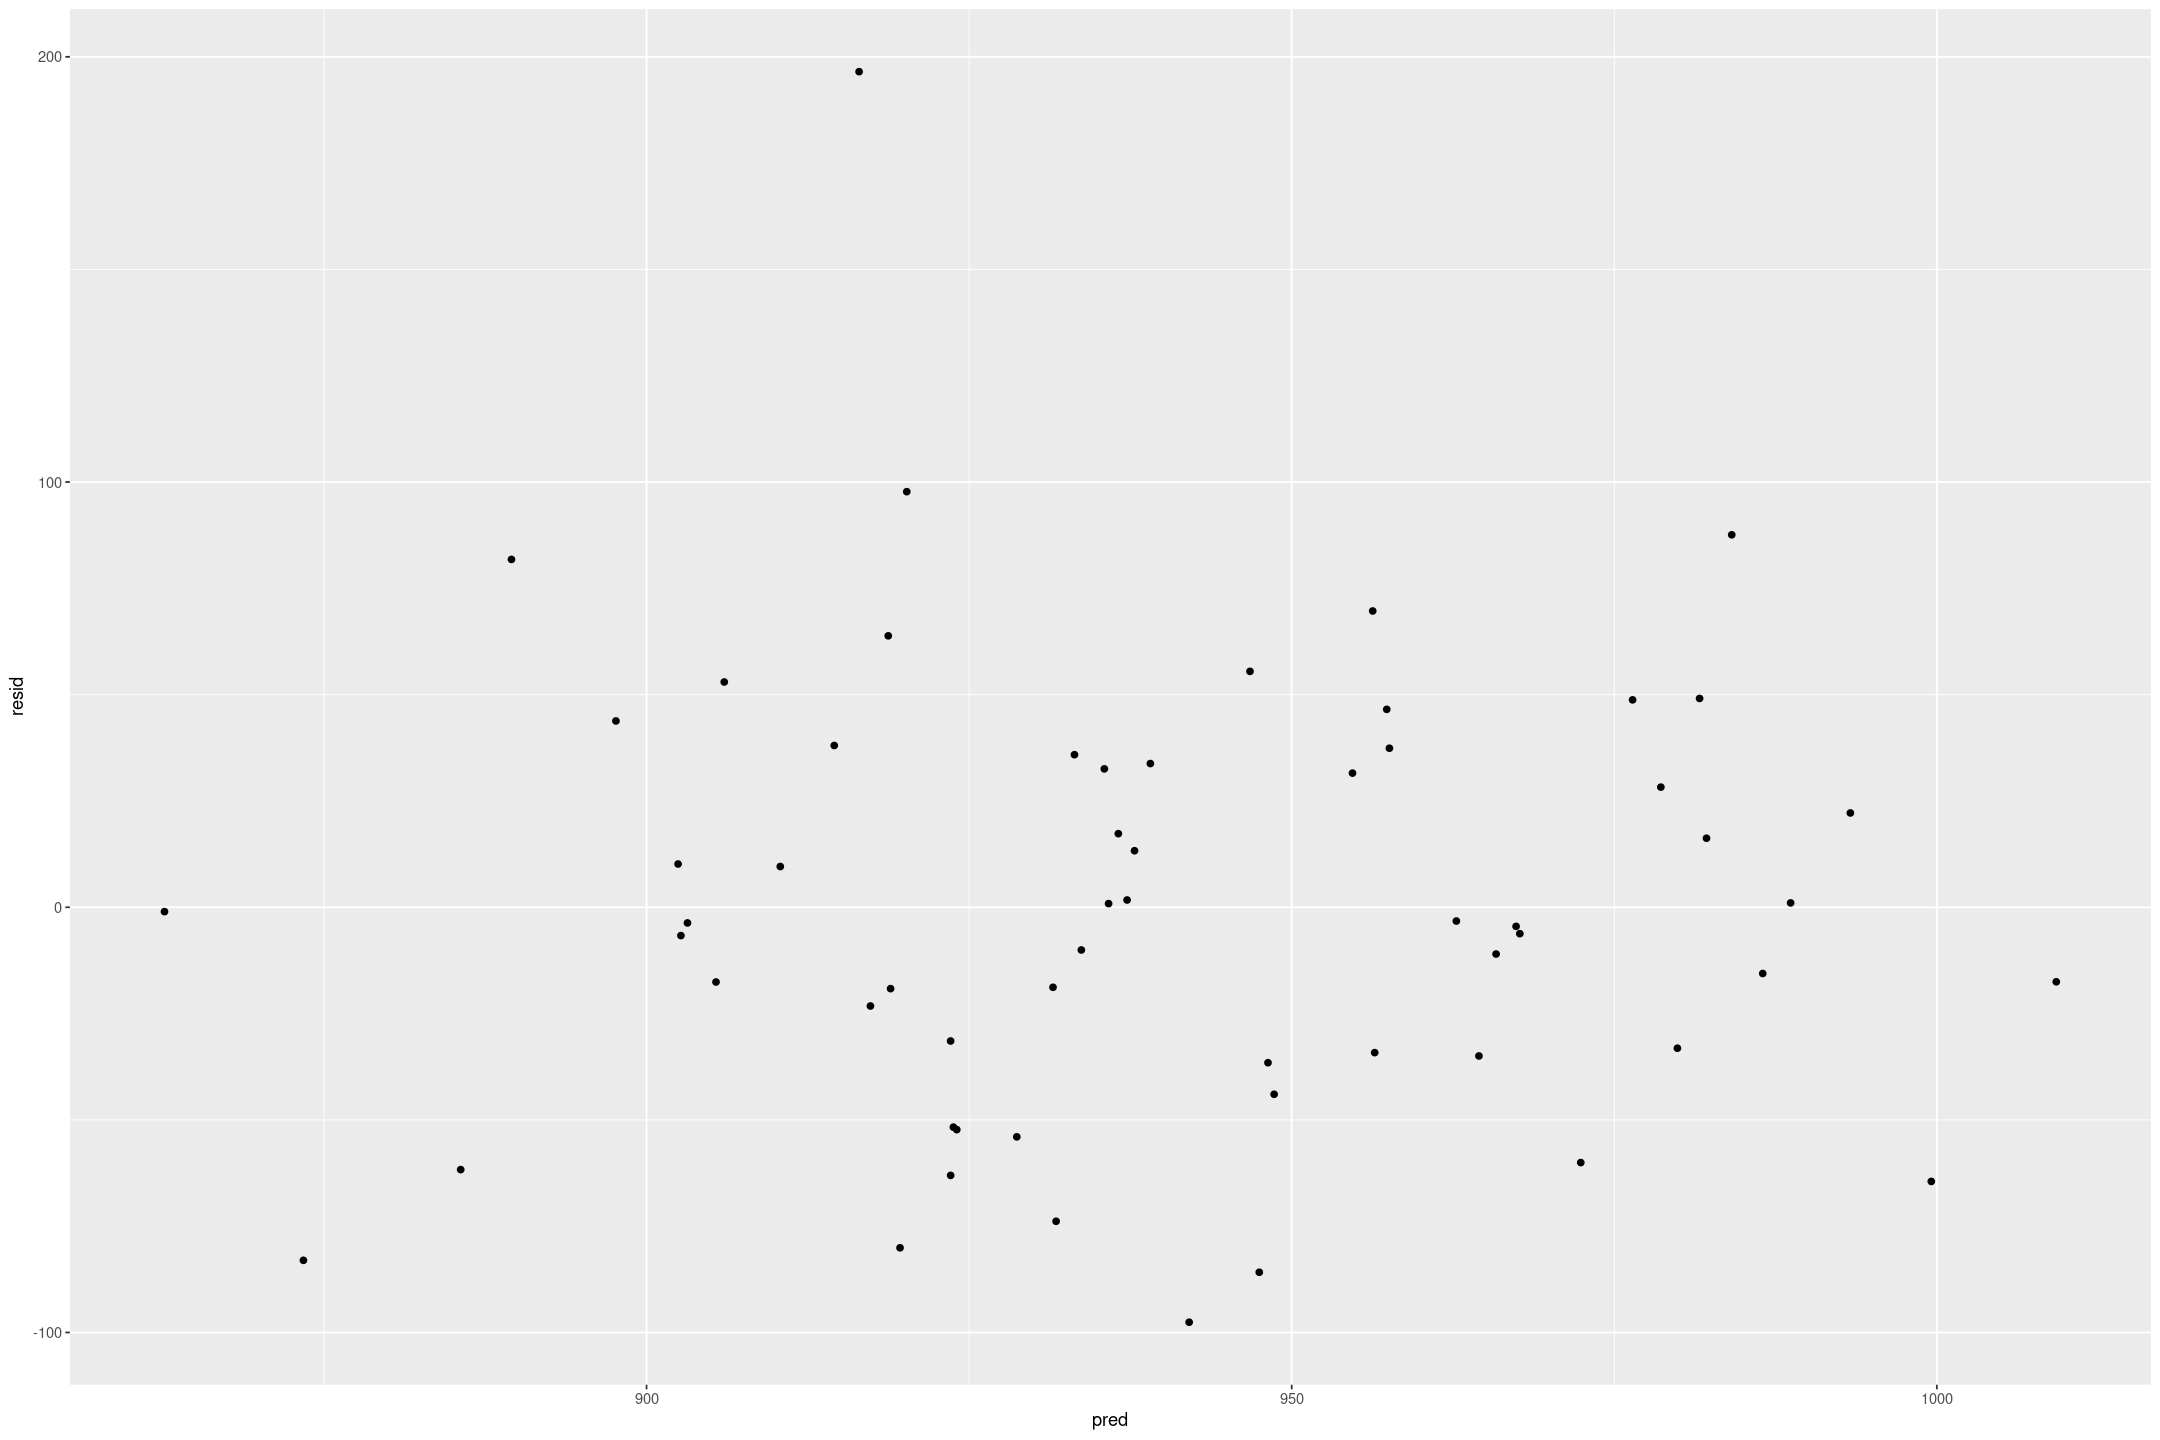

In [33]:
pollution %>%
add_predictions(model_mort_log_pollutants) %>%
add_residuals(model_mort_log_pollutants) %>%
gf_point(resid ~ pred)

The model is looking a little better

In [34]:
loo_mort_log_pollutants <- loo(model_mort_log_pollutants, k_threshold=0.7)

loo_compare(loo_mort_log_nox, loo_mort_linear_nox, loo_mort_log_pollutants)

1 problematic observation(s) found.
Model will be refit 1 times.


Fitting model 1 out of 1 (leaving out observation 37)



,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model_mort_log_pollutants,0.000000,0.000000,-331.5900,10.776847,9.654625,5.628115,663.1801,21.55369
model_mort_log_nox,-1.919528,7.570072,-333.5096,6.928916,3.963118,1.260363,667.0191,13.85783
model_mort_linear_nox,-4.335820,7.304746,-335.9259,5.824528,3.336066,1.325111,671.8517,11.64906


### Compare with a squareroot transform on so2

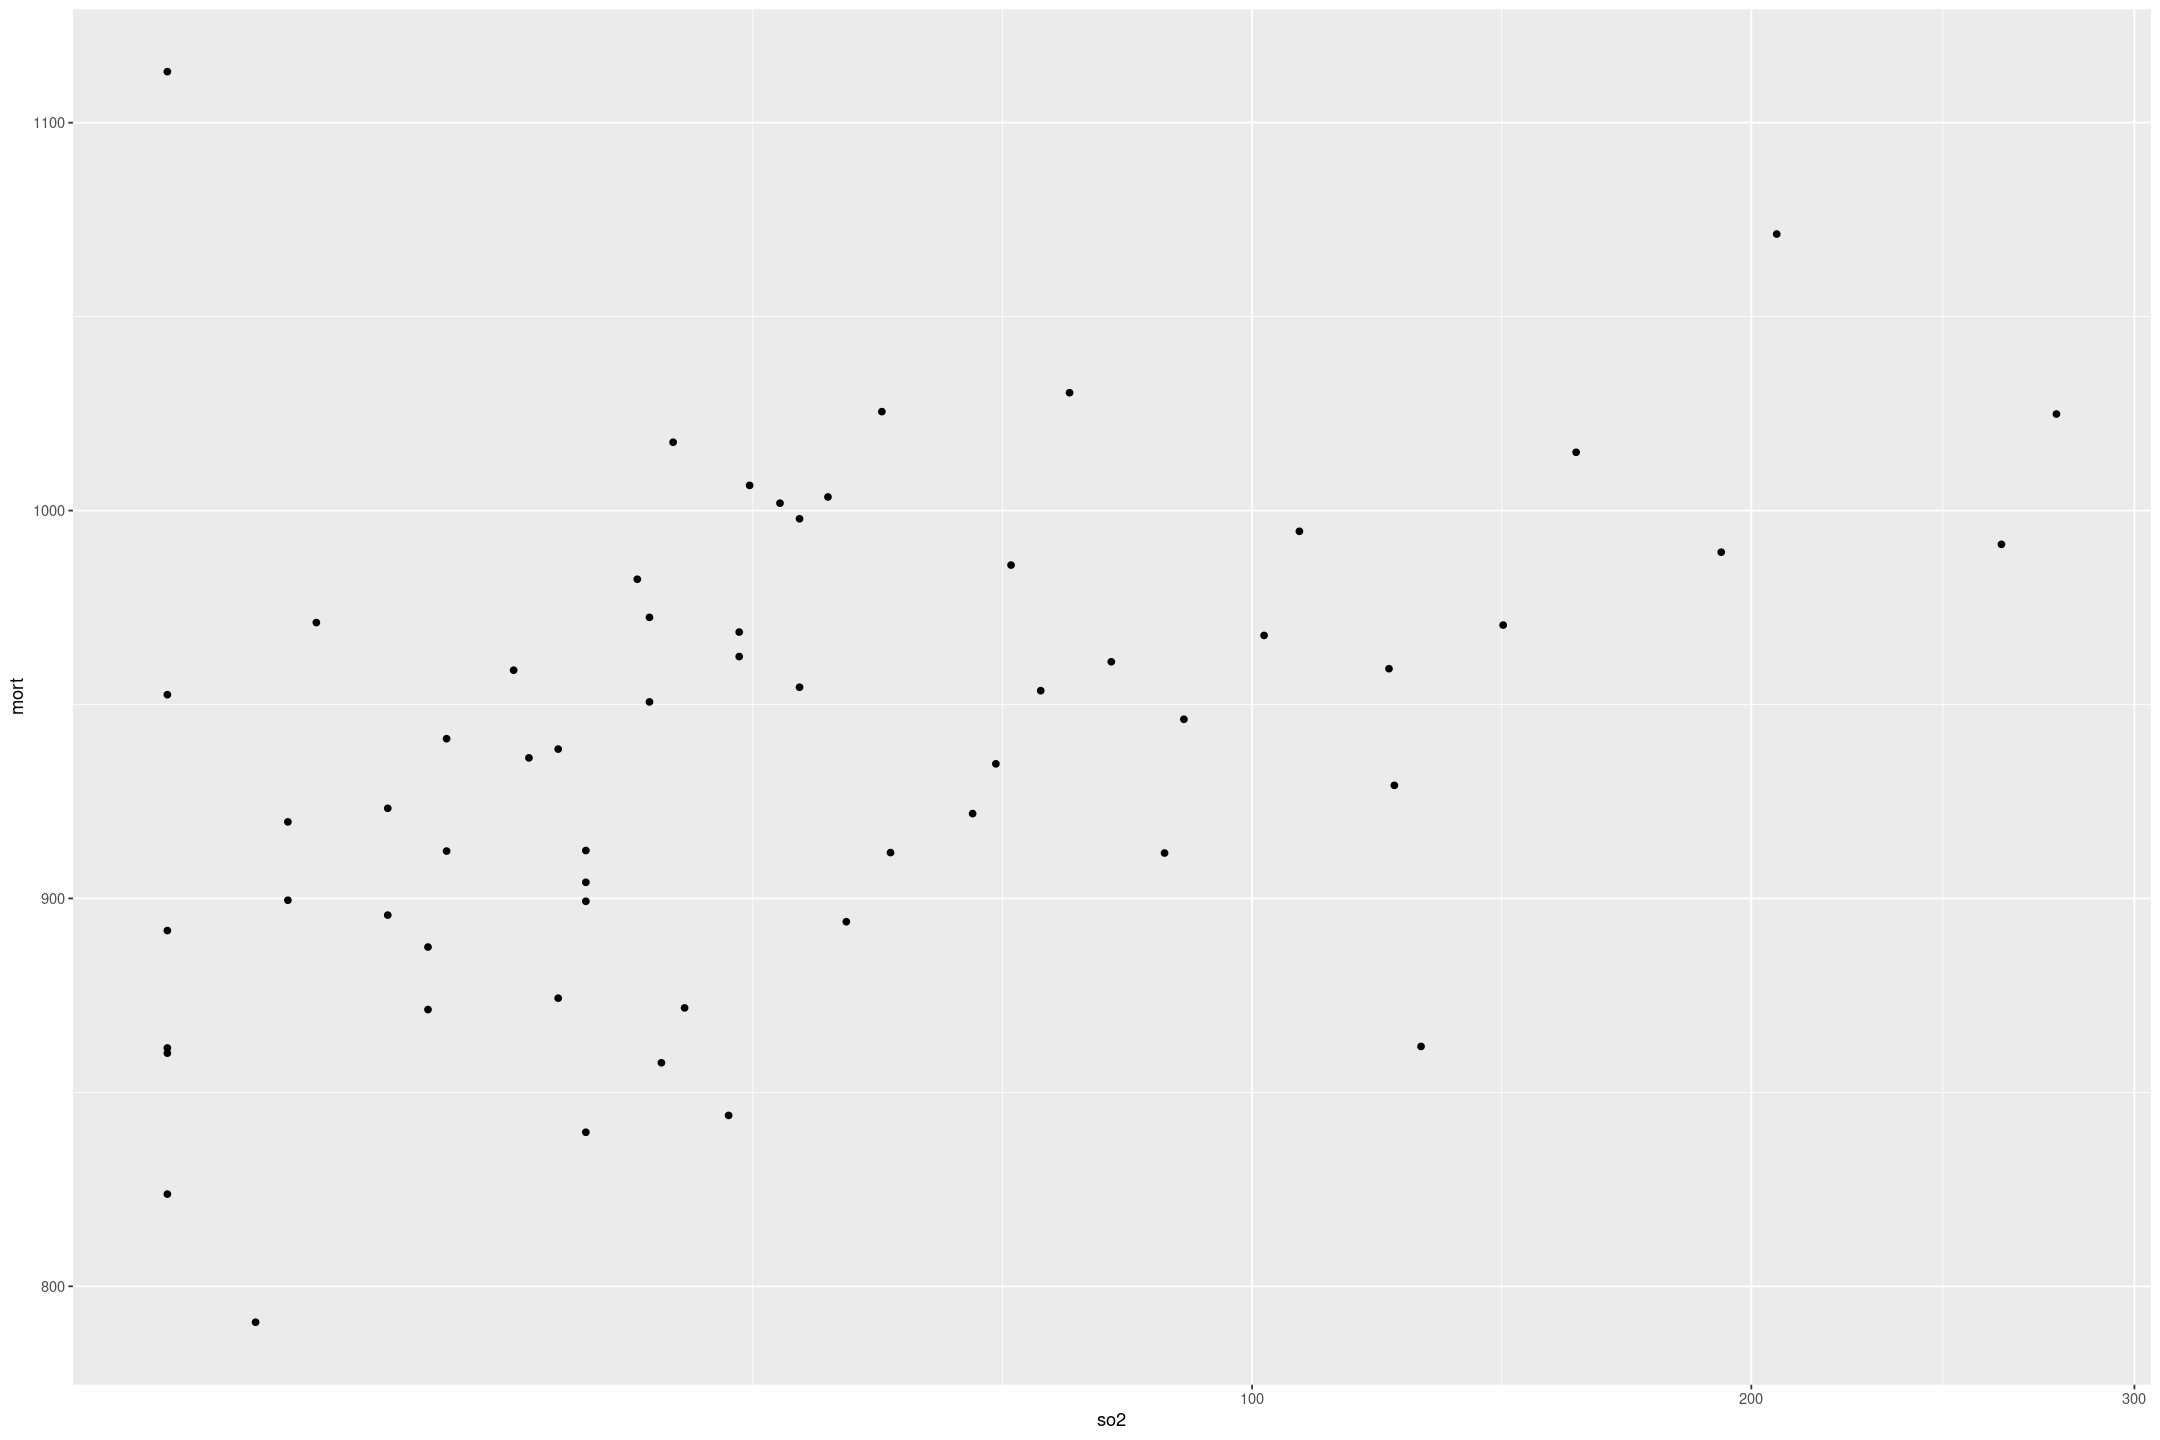

In [35]:
pollution %>%
gf_point(mort ~ so2) +
scale_x_sqrt()

In [36]:
(model_mort_log_pollutants_sqrt_so2 <- stan_glm(mort ~ log(nox) + sqrt(so2) + log(hc), data=pollution, refresh=0))

stan_glm
 family:       gaussian [identity]
 formula:      mort ~ log(nox) + sqrt(so2) + log(hc)
 observations: 60
 predictors:   4
------
            Median MAD_SD
(Intercept) 930.2   19.6 
log(nox)     46.5   23.8 
sqrt(so2)     5.7    3.0 
log(hc)     -48.7   20.6 

Auxiliary parameter(s):
      Median MAD_SD
sigma 54.4    5.1  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

A squareroot transformation in SO2 actually does markedly better here.

In [37]:
loo_mort_log_pollutants_sqrt_so2 <- loo(model_mort_log_pollutants_sqrt_so2, k_threshold=0.7)

loo_compare(loo_mort_log_nox, loo_mort_linear_nox, loo_mort_log_pollutants, loo_mort_log_pollutants_sqrt_so2)

1 problematic observation(s) found.
Model will be refit 1 times.


Fitting model 1 out of 1 (leaving out observation 37)



,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model_mort_log_pollutants_sqrt_so2,0.000000,0.000000,-329.5053,9.080466,7.470586,3.736803,659.0106,18.16093
model_mort_log_pollutants,-2.084734,2.021680,-331.5900,10.776847,9.654625,5.628115,663.1801,21.55369
model_mort_log_nox,-4.004262,6.237728,-333.5096,6.928916,3.963118,1.260363,667.0191,13.85783
model_mort_linear_nox,-6.420554,5.776570,-335.9259,5.824528,3.336066,1.325111,671.8517,11.64906


## Cross validate

Fit the model you chose above to the first half of the data and then predict for the second half.
You used all the data to construct the model in (d), so this is not really cross validation, but it gives a sense of how the steps of cross validation can be implemented.

In [38]:
train_rows <- nrow(pollution) %/% 2
test_rows <- nrow(pollution) - train_rows

In [39]:
model_mort_log_pollutants_sqrt_so2 <- stan_glm(mort ~ log(nox) + sqrt(so2) + log(hc), data=pollution %>% head(train_rows), refresh=0)

In [40]:
pollution %>%
tail(test_rows) %>%
add_residuals(model_mort_log_pollutants_sqrt_so2) %>%
summarise(rmse=sqrt(mean(resid^2)), sd=sd(mort)) %>%
mutate(r2 = 1 - (rmse/sd)^2)

rmse,sd,r2
<dbl>,<dbl>,<dbl>
73.73759,67.38482,-0.1974396


This model generalises terribly!

In [41]:
pollution %>%
head(train_rows) %>%
add_residuals(model_mort_log_pollutants_sqrt_so2) %>%
summarise(rmse=sqrt(mean(resid^2)), sd=sd(mort)) %>%
mutate(r2 = 1 - (rmse/sd)^2)

rmse,sd,r2
<dbl>,<dbl>,<dbl>
47.93674,57.01692,0.2931463


It doesn't look great.

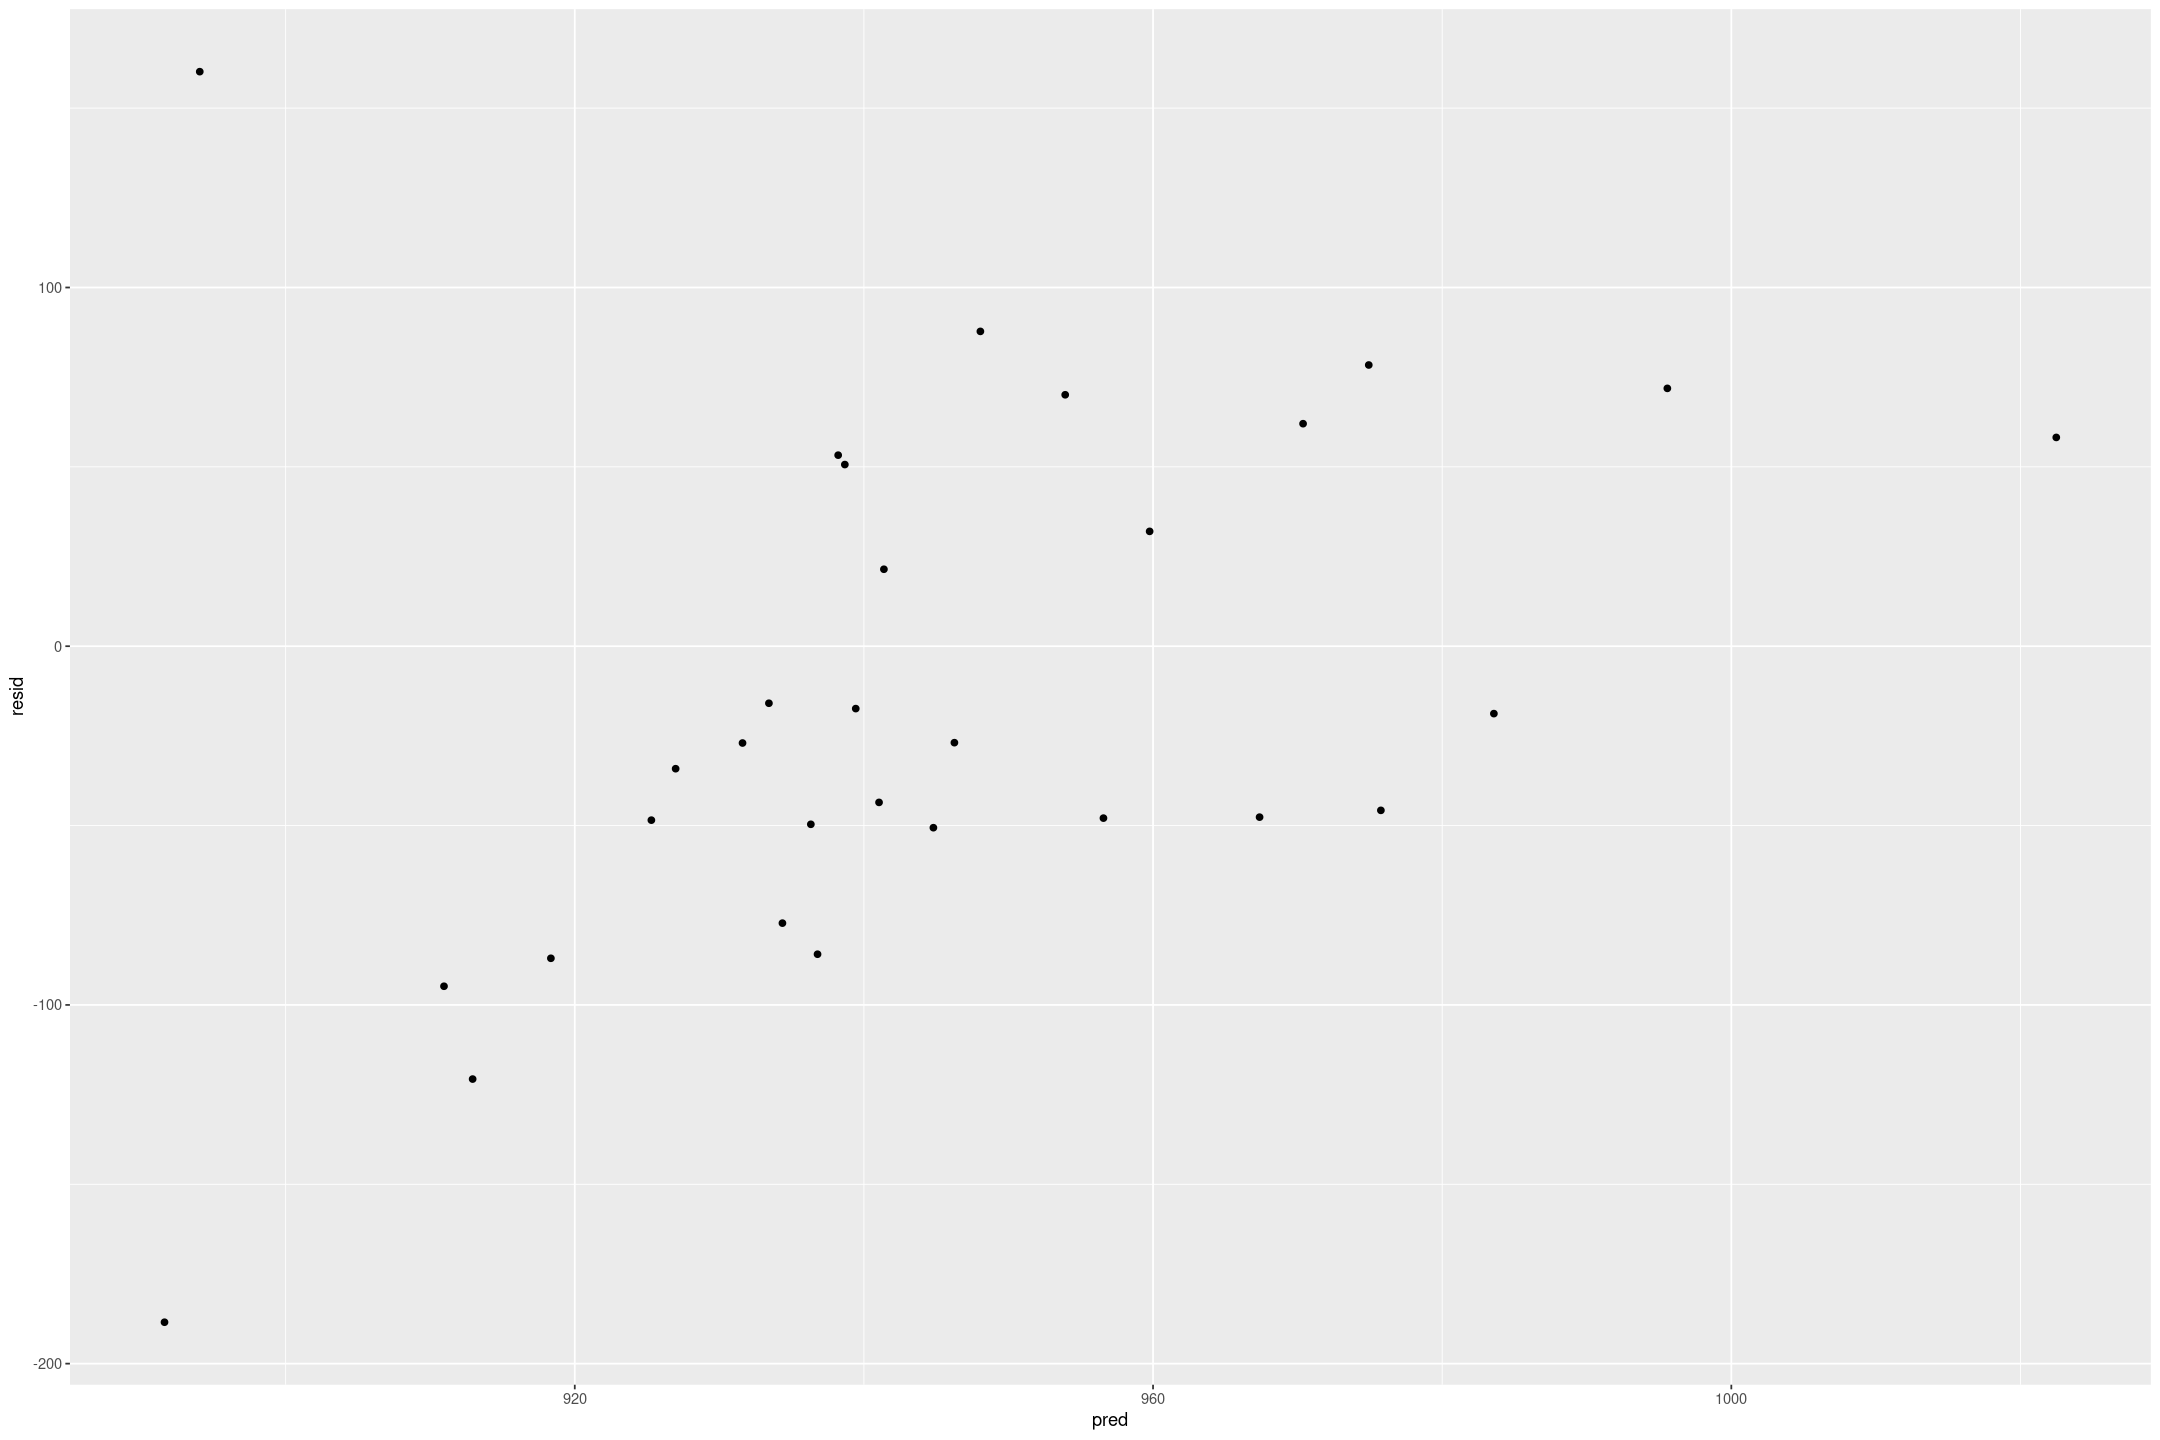

In [42]:
pollution %>%
tail(test_rows) %>%
add_residuals(model_mort_log_pollutants_sqrt_so2) %>%
add_predictions(model_mort_log_pollutants_sqrt_so2) %>%
gf_point(resid~pred)

It performs fairly similarly to the linear prediction.

In [43]:
model_mort_constant <- stan_glm(mort ~ 1, data=pollution %>% head(train_rows), refresh=0)

In [44]:
pollution %>%
tail(test_rows) %>%
add_residuals(model_mort_constant) %>%
summarise(rmse=sqrt(mean(resid^2)), sd=sd(mort)) %>%
mutate(r2 = 1 - (rmse/sd)^2)

rmse,sd,r2
<dbl>,<dbl>,<dbl>
67.39584,67.38482,-0.0003269022


In [45]:
pollution %>%
tail(test_rows) %>%
add_predictions(model_mort_log_nox) %>%
mutate(resid = mort - pred) %>%
summarise(rmse=sqrt(mean(resid^2)), sd=sd(mort)) %>%
mutate(r2 = 1 - (rmse/sd)^2)

rmse,sd,r2
<dbl>,<dbl>,<dbl>
64.96659,67.38482,0.07048593


There's likely a few reasons for this.

> This model is an extreme oversimplification, as it combines all sources of mortality and does not adjust for crucial factors such as age and smoking.

We're fitting on a secondary effect on 30 data points; the other crucial factors may change a lot between the two.

Looking at the data there's notable a few datapoints with very high hc and nox well off the regression line, where the model would do particularly badly.

Some regularisation would help, but it's likely we would need better predictors or a more appropriate outcome variable than all-cause mortality.

In [46]:
library(tidyr)

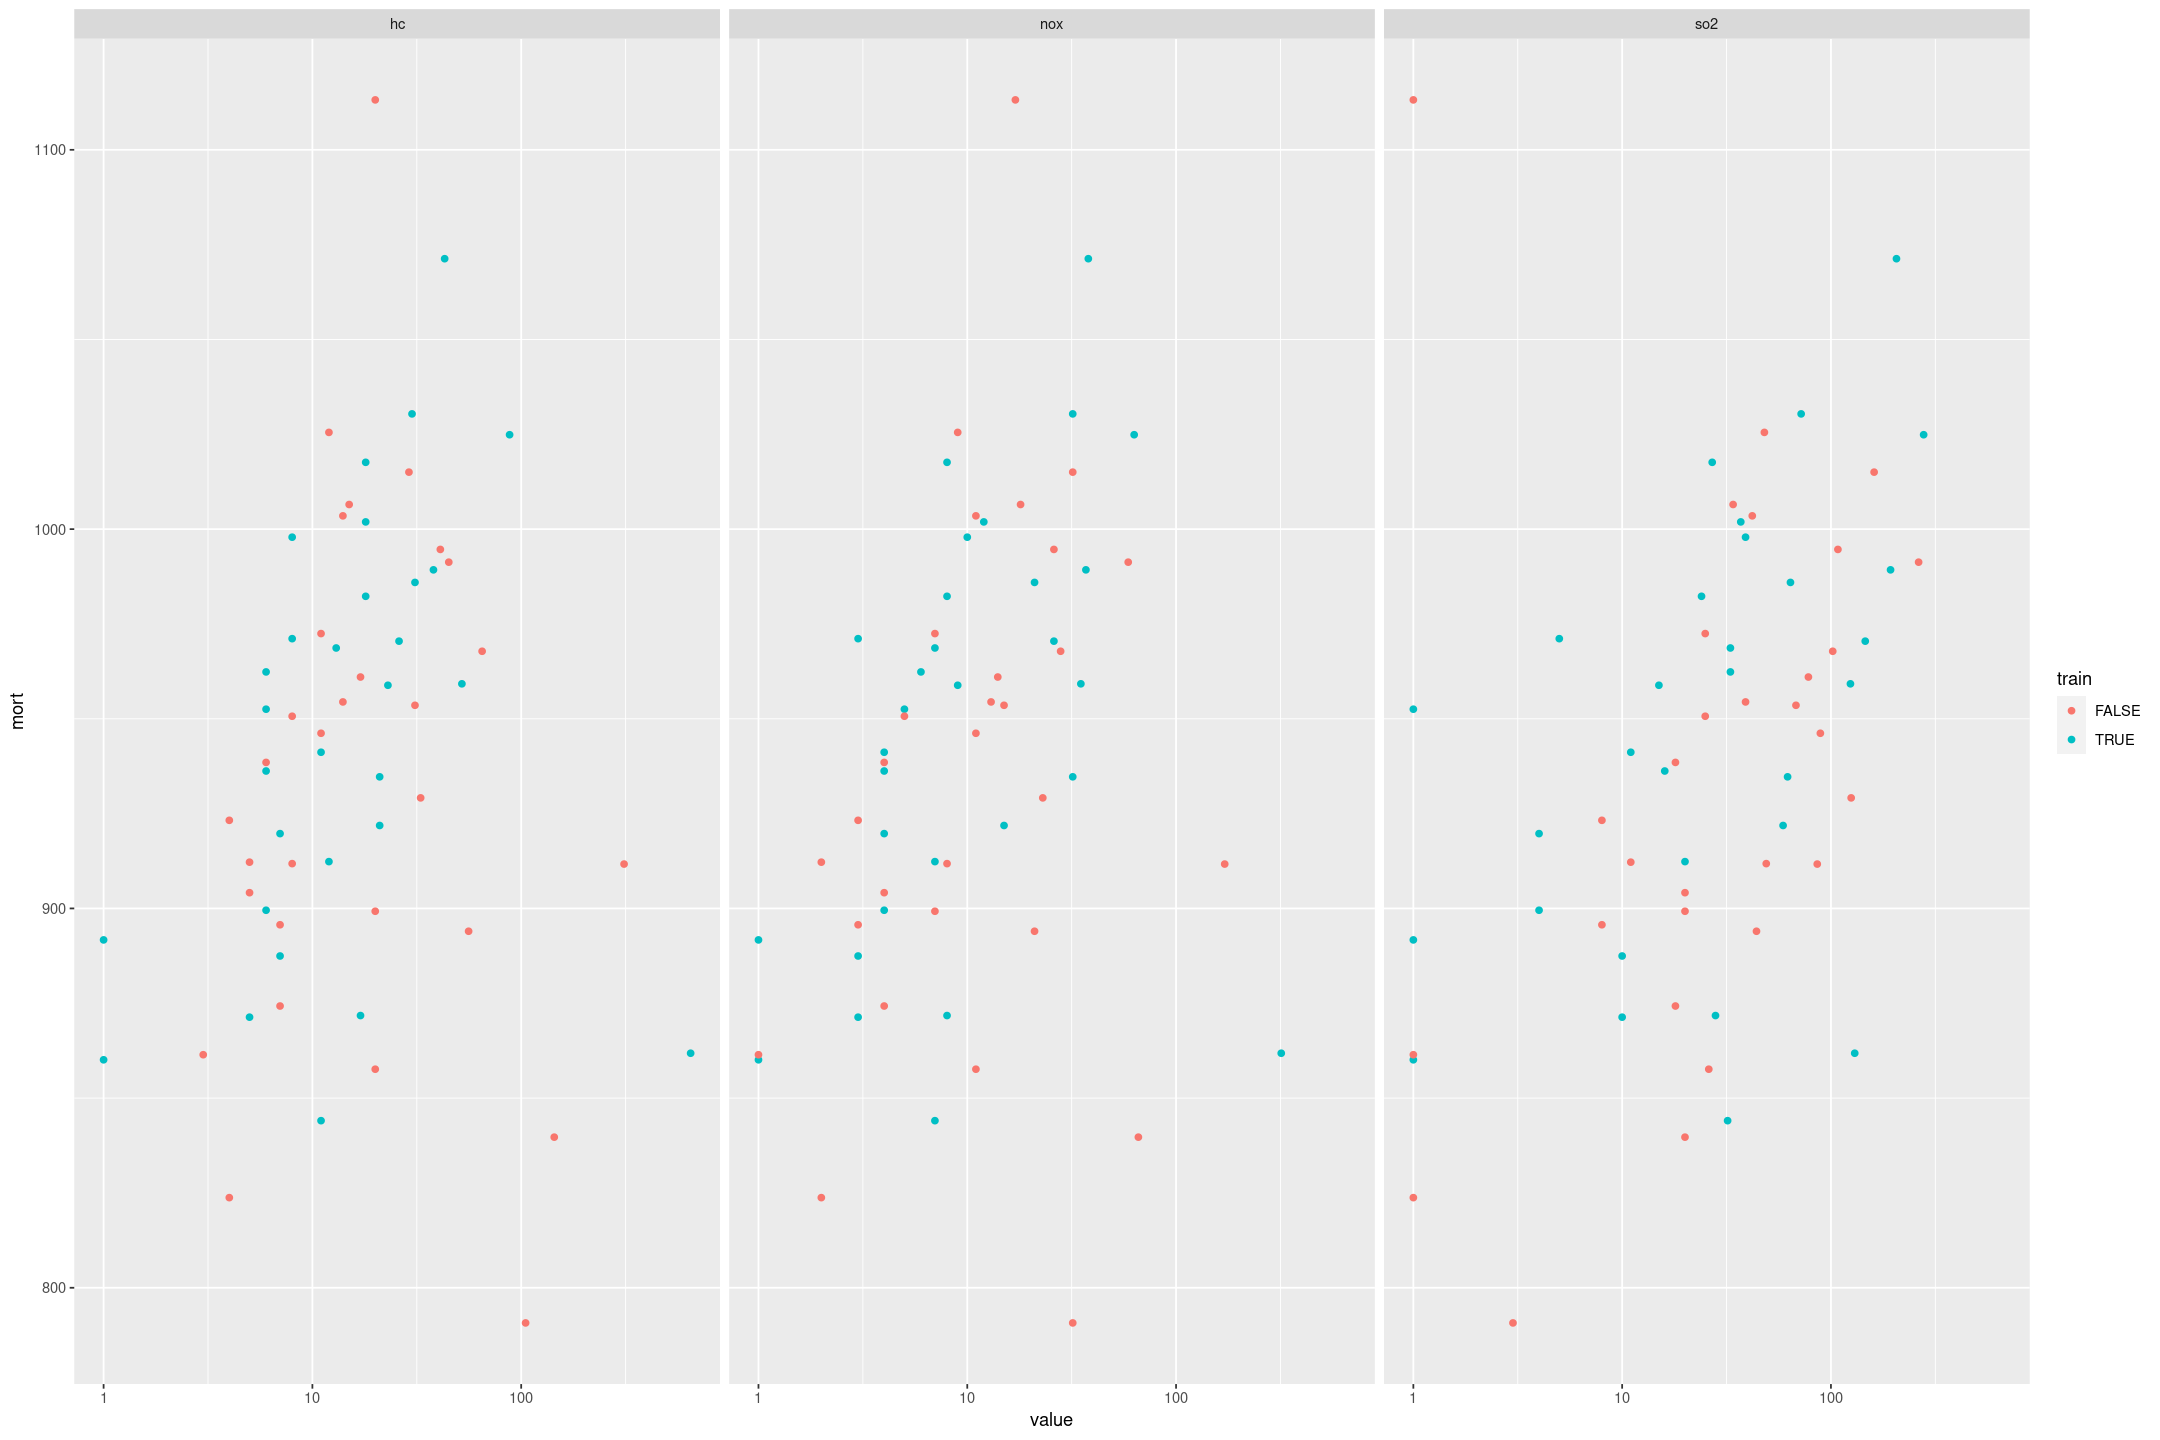

In [47]:
pollution %>%
mutate(train=row_number() <= train_rows) %>%
select(train, hc, nox, so2, mort) %>%
pivot_longer(c(hc, nox, so2)) %>%
gf_point(mort ~ value | name, col=~train) +
scale_x_log10()

# Cross validation comparison of models with different transformations of outcomes

When we compare models with transformed continuous outcomes, we must take into account how the nonlinear transformation warps the continuous variable.
Follow the procedure used to compare models for the mesquite bushes example on page 202.

## Earnings under log transformation

Compare models for eachings and for log(earnings) given height and sex as shown on pages 84 and 192.
Use `earnk` and `log(earnk)` as outcomes.

We're going to have to restrict to the subset with positive earnings to compare the log.

In [48]:
earnings %>% summarise(n=n(), positive_earnings=mean(earnk>0))

n,positive_earnings
<int>,<dbl>
1816,0.8970264


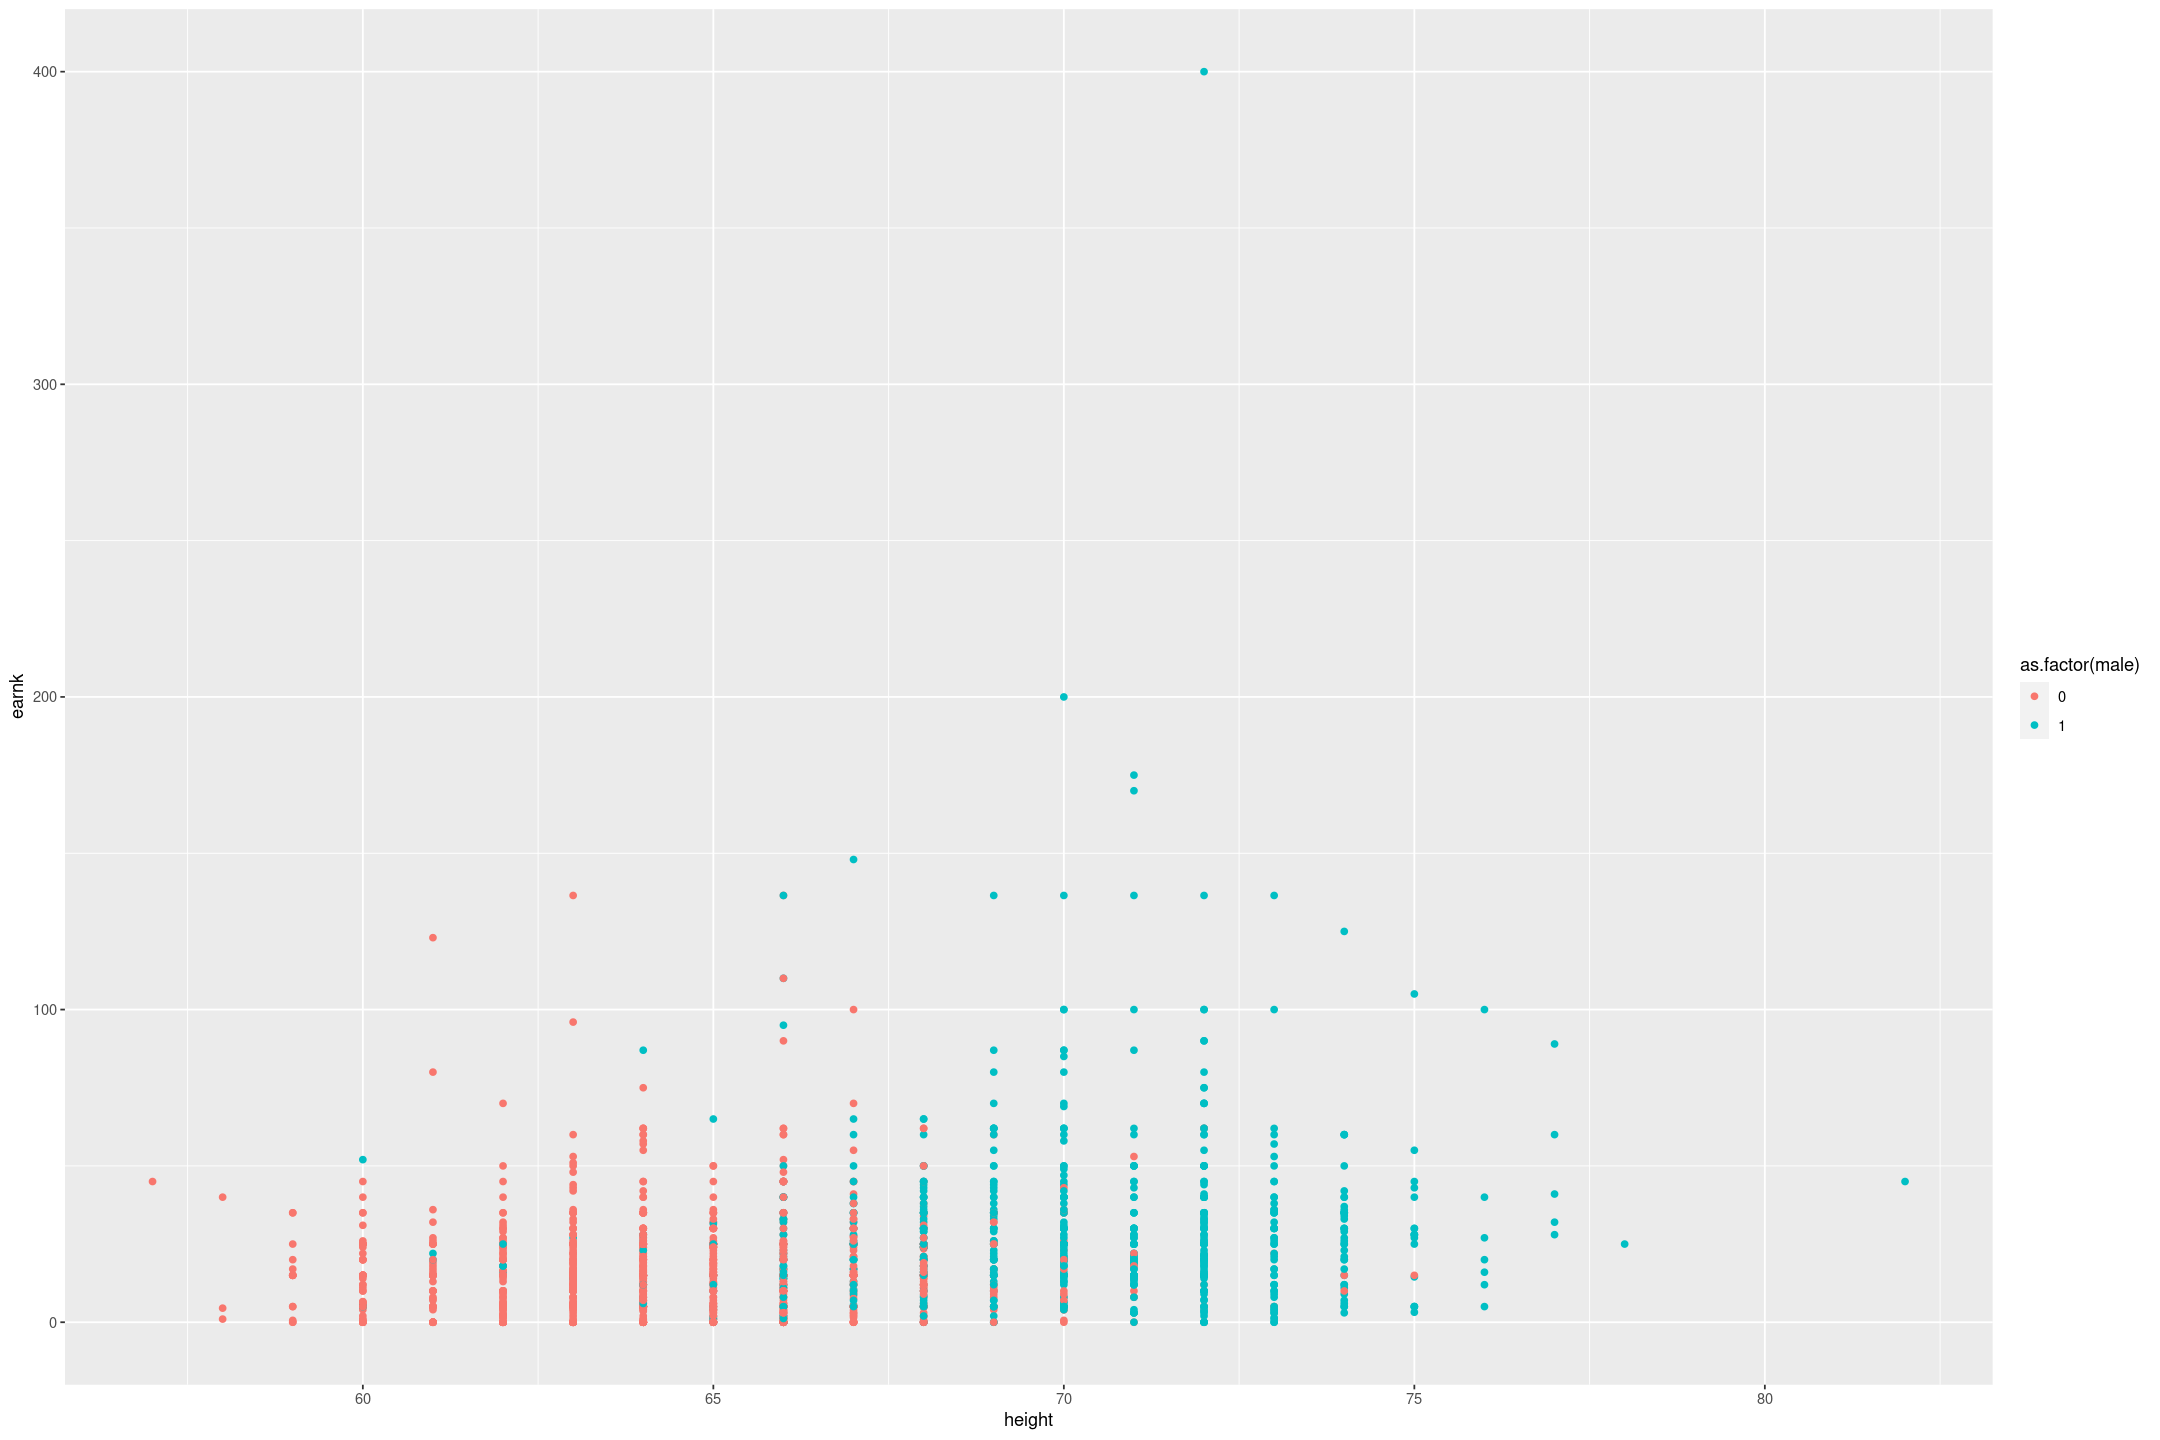

In [49]:
earnings %>%
gf_point(earnk ~ height, col=~as.factor(male))

In [50]:
(fit_earnings_linear <- stan_glm(earnk ~ height + male, data=earnings, subset=earnk>0, refresh=0))

stan_glm
 family:       gaussian [identity]
 formula:      earnk ~ height + male
 observations: 1629
 predictors:   3
------
            Median MAD_SD
(Intercept) -18.7   12.5 
height        0.6    0.2 
male          8.9    1.6 

Auxiliary parameter(s):
      Median MAD_SD
sigma 21.7    0.4  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

Warning message:
“Transformation introduced infinite values in continuous y-axis”


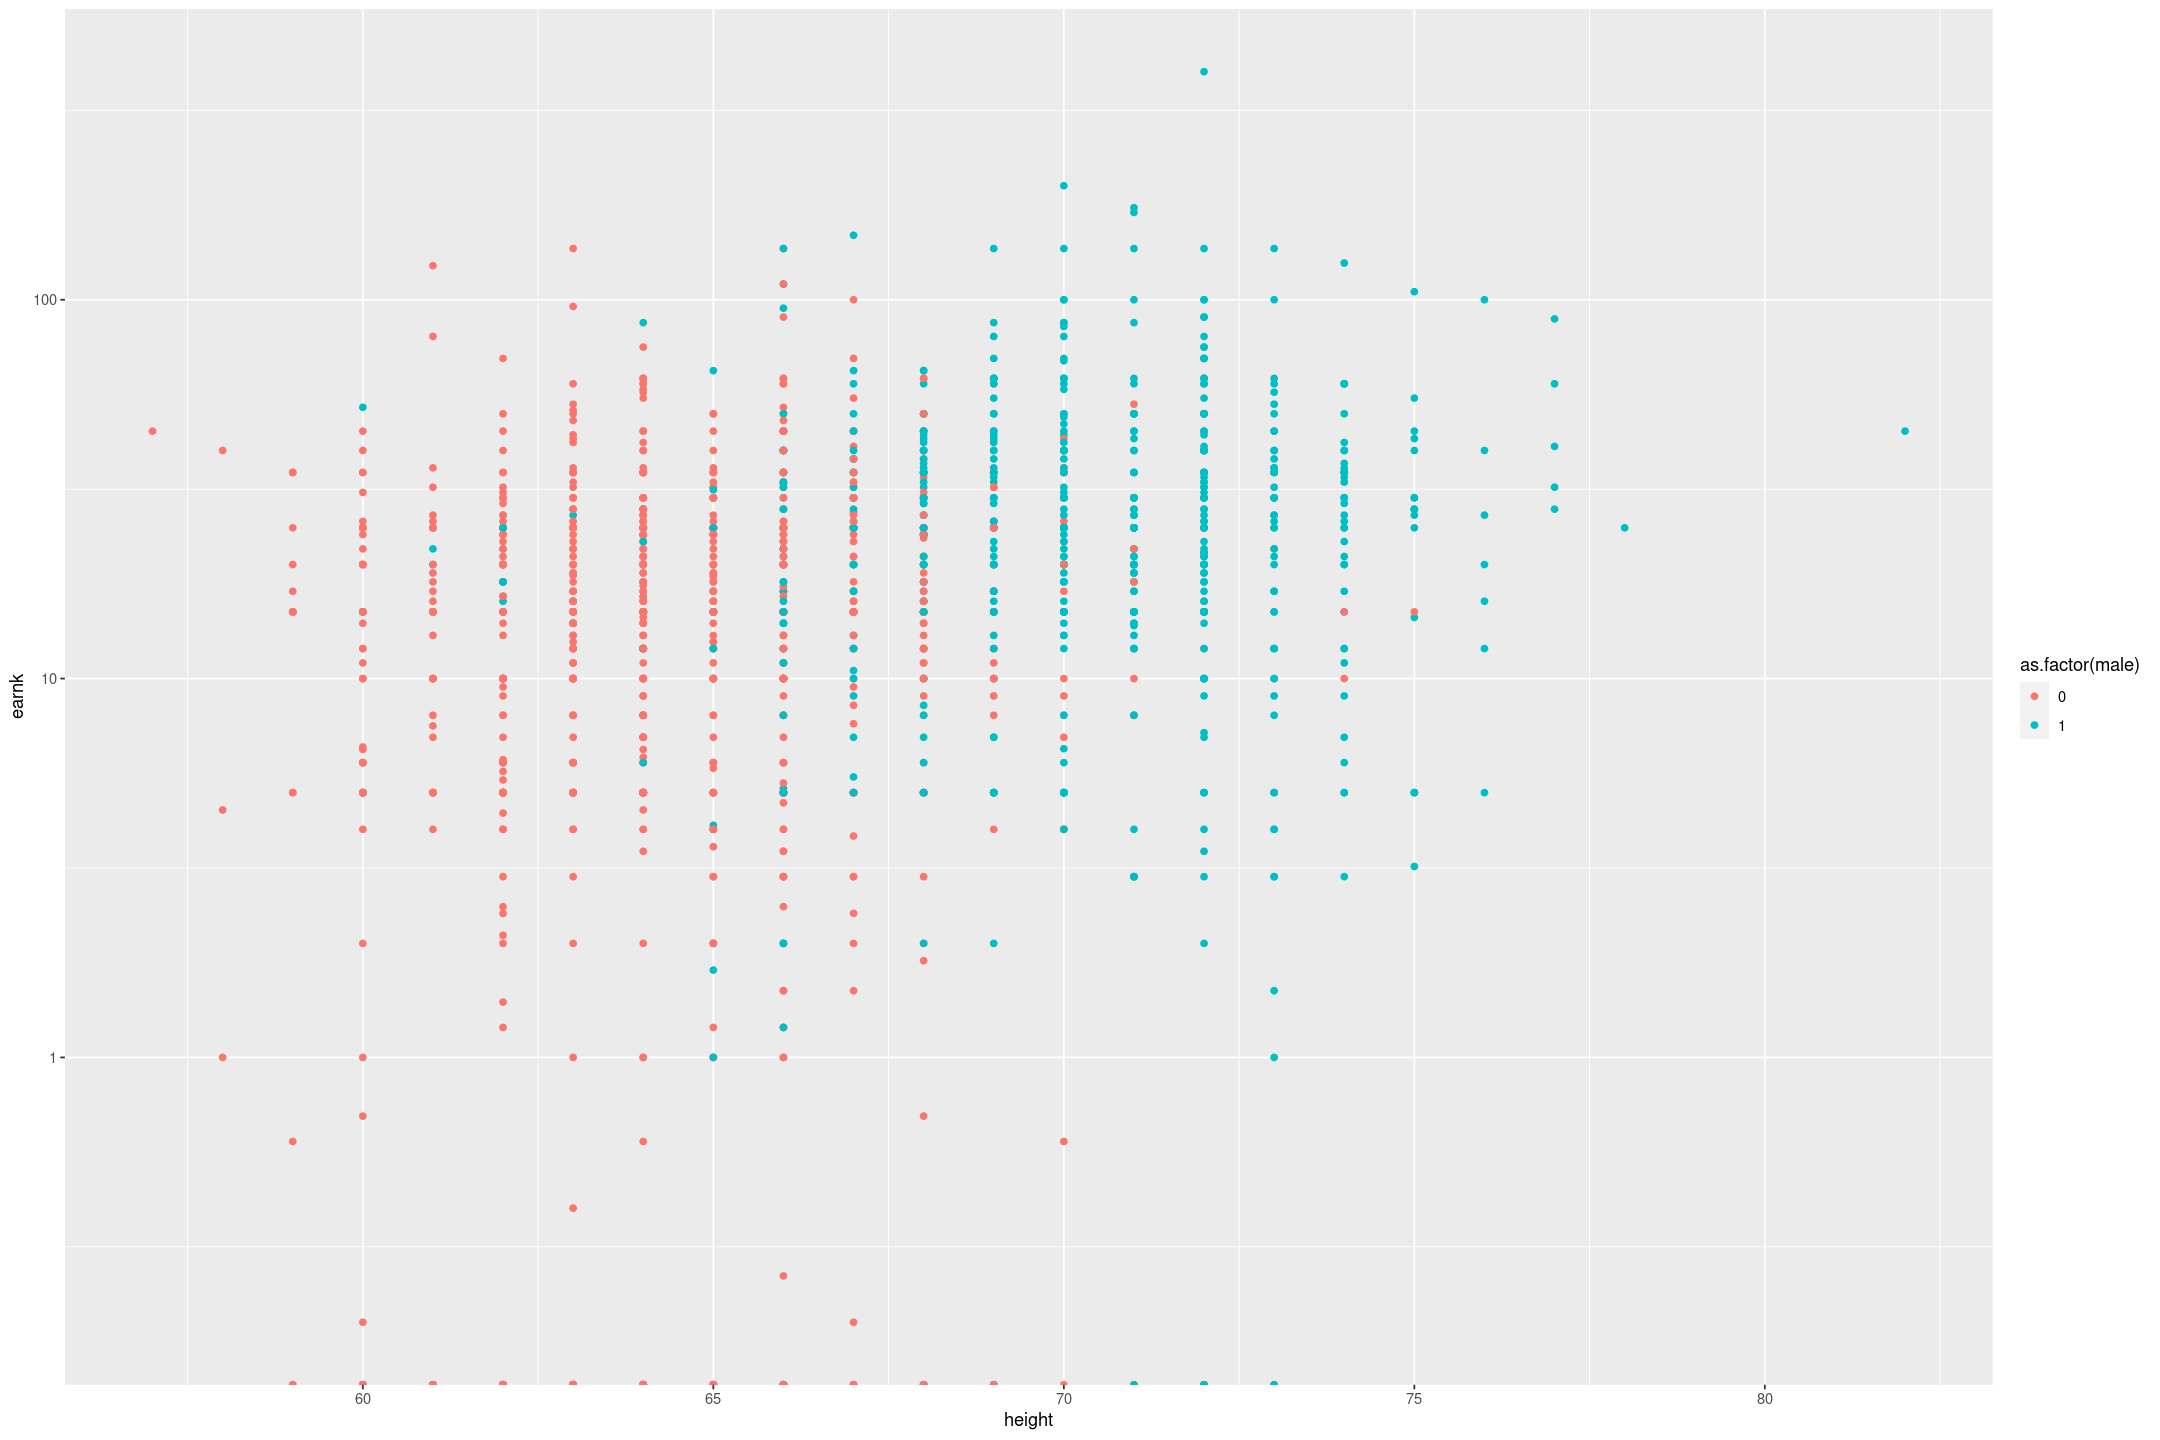

In [51]:
earnings %>%
gf_point(earnk ~ height, col=~as.factor(male)) +
scale_y_log10()

In [52]:
(fit_earnings_log <- stan_glm(log(earnk) ~ height + male, data=earnings, subset=earnk>0, refresh=0))

stan_glm
 family:       gaussian [identity]
 formula:      log(earnk) ~ height + male
 observations: 1629
 predictors:   3
------
            Median MAD_SD
(Intercept) 1.1    0.5   
height      0.0    0.0   
male        0.4    0.1   

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.9    0.0   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

To compare the models we're going to need to use a Jacobian transformation.

In [53]:
loo_earnings_linear <- loo(fit_earnings_linear, k_threshold=0.7)
loo_earnings_log <- loo(fit_earnings_log)

1 problematic observation(s) found.
Model will be refit 1 times.


Fitting model 1 out of 1 (leaving out observation 399)



In [54]:
loo_earnings_log_jacobian <- loo_earnings_log
loo_earnings_log_jacobian$pointwise[,1] <- loo_earnings_log_jacobian$pointwise[,1] - log(subset(earnings$earnk, earnings$earnk>0))

It looks like the log model is much better.

In [55]:
loo_earnings_linear


Computed from 4000 by 1629 log-likelihood matrix

         Estimate    SE
elpd_loo  -7348.4 174.5
p_loo        38.8  31.2
looic     14696.7 349.0
------
Monte Carlo SE of elpd_loo is 0.9.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

In [56]:
sum(loo_earnings_log_jacobian$pointwise[,1])

[1] -6663.24

In [57]:
loo_compare(loo_earnings_linear, loo_earnings_log_jacobian)

Warning message:
“Not all models have the same y variable. ('yhash' attributes do not match)”


,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
fit_earnings_log,0.0000,0.000,-2083.556,38.73941,4.860921,0.4293142,4167.112,77.47882
fit_earnings_linear,-685.1173,162.707,-7348.357,174.51141,38.804633,31.1628144,14696.714,349.02282


### Checking with cross-validation

The essential difference here is the linear model is minimising RMSE and the log model is minimising RMSLE.
When we compare them we need to put them on a common footing, and for the sake of argument let's assume RMSE has been set as the default metric.

In [58]:
library(modelr)
library(purrr)


Attaching package: ‘purrr’


The following object is masked from ‘package:scales’:

    discard




In [59]:
earnings10fold <- crossv_kfold(earnings, k = 10, id = ".id")

In [60]:
earnings10fold <- 
earnings10fold %>% 
mutate(linear_model=map(train, ~stan_glm(earnk ~ height + male, data=as.data.frame(.), refresh=0))) %>%
mutate(log_model=map(train, ~stan_glm(log(earnk) ~ height + male, data=as.data.frame(.), subset=earnk>0, refresh=0)))

In [61]:
earnings10fold <- 
earnings10fold %>%
mutate(log_preds_log=map2(test, log_model, ~predict(.y, newdata=.x)),
       resid_log = map2(test, log_preds_log, ~as.data.frame(.x)$earnk - exp(.y)),
       mse_log =map(resid_log, ~mean(.^2)),
       preds_lin=map2(test, linear_model, ~predict(.y, newdata=.x)),
       resid_lin=map2(test, preds_lin, ~as.data.frame(.x)$earnk - .y),
       mse_lin =map(resid_lin, ~mean(.^2)))

In [62]:
earnings_rmse_10fold <- 
earnings10fold %>% 
select(mse_log, mse_lin) %>% 
unnest(c(mse_log, mse_lin))

earnings_rmse_10fold

mse_log,mse_lin
<dbl>,<dbl>
335.5650,313.0435
238.8986,236.4027
1074.3323,1018.9229
438.4295,439.5162
564.2990,549.4334
478.3093,445.8012
461.3015,426.7348
366.1011,333.4313
432.8774,406.1888


Here we get a slightly different story - the models are essentially indistinguishable using mean squared error.
I trust this story more!

In [63]:
earnings_rmse_10fold %>% summarise_all(mean)

mse_log,mse_lin
<dbl>,<dbl>
482.4188,457.9468


In [64]:
earnings_rmse_10fold %>% summarise_all(sd)

mse_log,mse_lin
<dbl>,<dbl>
225.7465,214.7574


## Other examples

Compare models from exercise 12.6.

In 12.6 we could have used a log mortality model.

In [65]:
(model_mort_log_nox <- stan_glm(mort ~ log(nox), data=pollution, refresh=0))

stan_glm
 family:       gaussian [identity]
 formula:      mort ~ log(nox)
 observations: 60
 predictors:   2
------
            Median MAD_SD
(Intercept) 904.4   17.7 
log(nox)     15.4    7.0 

Auxiliary parameter(s):
      Median MAD_SD
sigma 60.2    5.5  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [66]:
(loo_mort_log_nox <- loo(model_mort_log_nox))


Computed from 4000 by 60 log-likelihood matrix

         Estimate   SE
elpd_loo   -333.5  6.9
p_loo         4.0  1.3
looic       667.0 13.9
------
Monte Carlo SE of elpd_loo is 0.0.

All Pareto k estimates are good (k < 0.5).
See help('pareto-k-diagnostic') for details.

In [67]:
(model_log_mort_log_nox <- stan_glm(log(mort) ~ log(nox), data=pollution, refresh=0))

stan_glm
 family:       gaussian [identity]
 formula:      log(mort) ~ log(nox)
 observations: 60
 predictors:   2
------
            Median MAD_SD
(Intercept) 6.8    0.0   
log(nox)    0.0    0.0   

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.1    0.0   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [68]:
(loo_log_mort_log_nox <- loo(model_log_mort_log_nox))


Computed from 4000 by 60 log-likelihood matrix

         Estimate   SE
elpd_loo     77.0  6.9
p_loo         4.0  1.3
looic      -154.0 13.9
------
Monte Carlo SE of elpd_loo is 0.1.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     59    98.3%   860       
 (0.5, 0.7]   (ok)        1     1.7%   592       
   (0.7, 1]   (bad)       0     0.0%   <NA>      
   (1, Inf)   (very bad)  0     0.0%   <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.

Adjust the log-log model with the Jacobian

In [69]:
loo_log_mort_log_nox_jacobian <- loo_log_mort_log_nox
loo_log_mort_log_nox_jacobian$pointwise[,1] <- loo_log_mort_log_nox_jacobian$pointwise[,1] - log(pollution$mort)
sum(loo_log_mort_log_nox_jacobian$pointwise[,1])

[1] -333.6647

The logarithmic model does a tiny bit better (but as seen in 12.6.5 they're likely both terrible on new data).

In [70]:
loo_compare(loo_mort_log_nox, loo_log_mort_log_nox_jacobian)

Warning message:
“Not all models have the same y variable. ('yhash' attributes do not match)”


,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
model_log_mort_log_nox,0.0000000,0.0000000,76.98161,6.931419,3.951339,1.283678,-153.9632,13.86284
model_mort_log_nox,0.1478469,0.7227981,-333.51682,6.942558,3.987902,1.268318,667.0336,13.88512


# Log-log transformations

Suppose that, for a certain population of animals, we can predict log weight from log height as follows:

* An animal that is 50 centimeters tall is predicted to weigh 10 kg.
* Every increase of 1% in height corresponds to a predicted increase of 2% in weight.
* The weights of approximately 95% of the animals fall within a factor of 1.1 of predicted values.

## Description to model

Give the equation of the regression line and the residual standard deviation of the regression.

Let's express the model with heights in cm and weights in kg.

The equation we have is `log(weight) = a * log(height) + b + error`

Every increase of 1% in height corresponds to a predicted increase of 2% in weight gives `a = 2`.

Putting in that an animal 50cm tall is predicted to weigh 10kg gives:
` log(10) = 2 * log(50) + b`

i.e. `b = log(10) - 2 * log(50)`

In [71]:
log(10) - 2*log(50)

[1] -5.521461

Finally if 95% of the animals fall within a factor of 1.1. of predicted values, then 2 standard deviations of error is about 0.1 (`log(1.1)`), and so the standard deviation is about 0.05.

Hence `log(weight) = 2 * log(height) - 5.52 + N(0.05)`.

### Checking with code

In [72]:
pred_weight <- function(height) { exp(2 * log(height) - 5.52)}

pred_noise_weight <- function(height) { exp(2 * log(height) - 5.52 + rnorm(length(height), sd=0.05))}

A 50cm tall animal is predicted to be about 10kg.

In [73]:
pred_weight(50)

[1] 10.01462

In [74]:
mean(pred_noise_weight(rep(50,1000)))

[1] 10.04473

A 1% increase in weight corresponds to around a 2% increase in weight

In [75]:
(pred_weight(101) - pred_weight(100)) / pred_weight(100)

[1] 0.0201

In [76]:
(pred_weight(50.5) - pred_weight(50)) / pred_weight(50)

[1] 0.0201

95% of the animals fall within a factor of 1.1 of predicted values

In [77]:
n <- 1000
heights <- 50 + 10 * rnorm(n)
point_pred_weight <- pred_weight(heights)
mean(between(pred_noise_weight(heights) / point_pred_weight, 1/1.1, 1.1))

[1] 0.954

## Calculating $R^2$

Suppose the standard deviation of log weights is 20% in this population.
What, then, is the $R^2$ of the regression model described here?

$$ R^2 = 1 - (\hat{\sigma}^2 / s_y^2) $$

We have already said that the standard deviation in our log predictions is 0.05 (i.e. 5%), and we are told the standard deviation in the population is 20%.

So we get 

$$ R^2 = 1 - (.05/.2)^2 = 1 - (0.25)^2 = 0.9375 $$

So the $R^2$ of the regression model described here is about 94%.

# Linear and logarithmic transformations

For a study of congressional elections, you would like a measure of the relative amount of money raised by each of the two major-party candidates in each district.
Suppose that you know the amount of money raised by each candidate; label these dollar values $D_i$ and $R_i$.
You would like to combine these into a single variable that can be included as an input variables into a model predicting vote share for the Democrats.
Discuss the advantages and disadvantages of the following measures:

1. The simple difference, $D_i - R_i$

The difference $D_i - R_i$ has the advantage it's simple to explain and well defined for all values of $D_i$ and $R_i$.

However the amount of money raised is likely to vary a lot by district, and the difference likely has more to do with the size of the district than the difference between the candidates.
For example if in one district the Democrats raise \\$10k and Republicans \\$20k, then the difference is \\$10k.
If in another district the Democrats raise \\$100k and the Reublicans \\$110k then the difference is still \\$10k, but the latter seems much closer.

It's going to be very hard to get a reasonable prediction for vote share (in 0-100%) on a variable that varies so much, and the feature will not be particularly informative.

2. The ratio, $D_i/R_i$

The ratio $D_i/R_i$ has the advantage that the ratio is a better indicator of how close the district is.
In the previous example the first district has a ratio of 0.5 and the latter 0.9, which is closer to what we expect.
The ratio is also relatively easy to interpret.

However it has the disadvantage that it weights Democrats and Republicans differently in a linear model.
Denote the vote share for Democrats by $V_i$.

$$ V_i = a D_i/R_i + c $$

Consider predictions on the following data:

| District | Republicans | Democrats | Ratio |
| -- | -- | -- | -- |
| A | \\$200k | \\$100k | 0.5 |
| B | \\$100k | \\$100k | 1 |
| C | \\$100k | \\$200k | 2 |


We get $V_A = 0.5 a + c$, $V_B = a + c$, and $V_C = 2 a + c$.
So we're predicting the $ V_C - V_B $ to have twice the difference to $ V_B - V_A $.
But they should be symmetrical - we've just switched the position of Democrats and Republicans.

Another small issue is in districts where there is no Republican funds raised the model is ill defined.

3. The difference on the logarithmic scale, $\log D_i - \log R_i $

The advantage of this is it has reasonable ranges, is symmetric, and linear in the ratios.


| District | Republicans | Democrats | Log Ratio |
| -- | -- | -- | -- |
| A | \\$200k | \\$100k | -0.69 |
| B | \\$100k | \\$100k | 0 |
| C | \\$100k | \\$200k | 0.69 |

It's also relatively straightforward to interpret in terms of percentage changes (once expontentiated).

The downsides are it is undefined if either party raises no funds, and logarithms are a bit harder to communicate.

4. The relative proportion, $D_i / (D_i + R_i)$.

This has a straightforward interpretation as the percentage of fundraising that is Democratic, and has a bounded range between 0 and 1. Again it corresponds to relative changes which is more appropriate for comparing districts with very large differences in total fundraising.

Like the difference on the logarithmic scale it's symmetric in terms of differences between Republican and Democrat fundraising.

| District | Republicans | Democrats | Relative Proportion |
| -- | -- | -- | -- |
| A | \\$200k | \\$100k | 0.33 |
| B | \\$100k | \\$100k | 0.5 |
| C | \\$100k | \\$200k | 0.67 |

It's undefined when both $D_i$ and $R_i$ are 0.
A potential downside is in situations where $D_i$ or $R_i$ is an order of magnitude larger than the other it starts asymptoting towards 1 or 0, so if the vote swing is very large in these circumstances it may not be adequately captured.
But it's a very viable alternative to the log.

# Special-purpose transformations

For the congressional elections example in the previous exercise, propose an idiosyncratic transformation as in the example on page 196 and discuss the advantages and disadvantages of using it as a regression input.

An idiosyncratic transformation could be to bucket the relative proportion.

For example we could have categories on how strong the fundraising advantage is, such as:

* Very Republican `[0, 0.33)`
* Republican `[0.33, 0.4)`
* Slightly Republican `[0.4, 0.48]`,
* Neutral `(0.48,0.52)`
* Slightly Democrat `[0.52, 0.6]`
* Democrat `[0.6, 0.67]`
* Very Democrat `[0.67, 1]`

An advantage of this kind of distinction is it can capture very non-linear associations in the data. However it throws out all the information within a category and so may be less effective at capturing the impact of small changes.

# Elasticity
An economist runs a regression examining the relations between the average price of cigarettes, $P$, and the quantity purchased, $Q$, across a large sample of countries in the Unites States, assuming the functional form, $\log Q = \alpha + \beta \log P$.
Suppose the estimate for $\beta$ is 0.3.
Interrpet this coefficient.

A $\beta$ of 0.3 means that for a 1% increase in average price there's a 3% **increase** in the amount of cigarettes purchased.

This seems surprising! In aggregrate cigarettes are not likely to be [Veblen Goods](https://en.wikipedia.org/wiki/Veblen_good), nor in the US a [Giffen Good](https://en.wikipedia.org/wiki/Giffen_good).

Likely it's a sign error (elasticities are often quoted in absolute value) and $\beta$ should be -0.3, so a 1% increase in average price results in a 3% decrease in the quantity of cigarettes sold.

This kind of interaction is very interesting for policy; the fewer cigarettes smoked the better health outcomes, so as long as they are not being substituted by similar products (tobacco to roll, black market cigarettes) then decreasing the quantity sold should decrease the quantity smoked.
On the other hand increasing the prices of these goods could put financial strain on people who keep smoking, but are in poor socieconomic circumstances.

# Sequence of regressions

Fina  regression problem that is of interest to you and can be performed repeatedly (for example, data from several years, or for several countries).
Perform a separate analysis for each year, or country, and display the estimates in a plot as in Figure 10.9.

Let's bring in some [Gapminder data](https://github.com/open-numbers/ddf--gapminder--systema_globalis) about Life Expectancy and Health Spending.

These issues are complex, but let's see how they relate broadly.

In [78]:
library(readr)


Attaching package: ‘readr’


The following object is masked from ‘package:scales’:

    col_factor




Read in the data

In [79]:
gap_life_expectancy <- read_csv('https://raw.githubusercontent.com/open-numbers/ddf--gapminder--systema_globalis/master/countries-etc-datapoints/ddf--datapoints--life_expectancy_at_birth_with_projections--by--geo--time.csv')

gap_health_spending <- read_csv('https://raw.githubusercontent.com/open-numbers/ddf--gapminder--systema_globalis/master/countries-etc-datapoints/ddf--datapoints--total_health_spending_per_person_international_dollar--by--geo--time.csv')

gap_country <- read_csv('https://raw.githubusercontent.com/open-numbers/ddf--gapminder--systema_globalis/master/ddf--entities--geo--country.csv')


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  geo = col_character(),
  time = col_double(),
  life_expectancy_at_birth_with_projections = col_double()
)



── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  geo = col_character(),
  time = col_double(),
  total_health_spending_per_person_international_dollar = col_double()
)



── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  `is--country` = col_logical(),
  iso3166_1_numeric = col_double(),
  latitude = col_double(),
  longitude = col_double(),
  un_state = col_logical()
)
ℹ Use `spec()` for the full column specifications.




Join the datasources

In [80]:
gapminder <- 
gap_life_expectancy %>%
inner_join(gap_health_spending) %>%
rename(health_spend = total_health_spending_per_person_international_dollar,
       life_expect = life_expectancy_at_birth_with_projections) %>%
group_by(geo) %>%
mutate(n=n()) %>%
ungroup() %>%
filter(n == max(n))

Joining, by = c("geo", "time")



Check the data

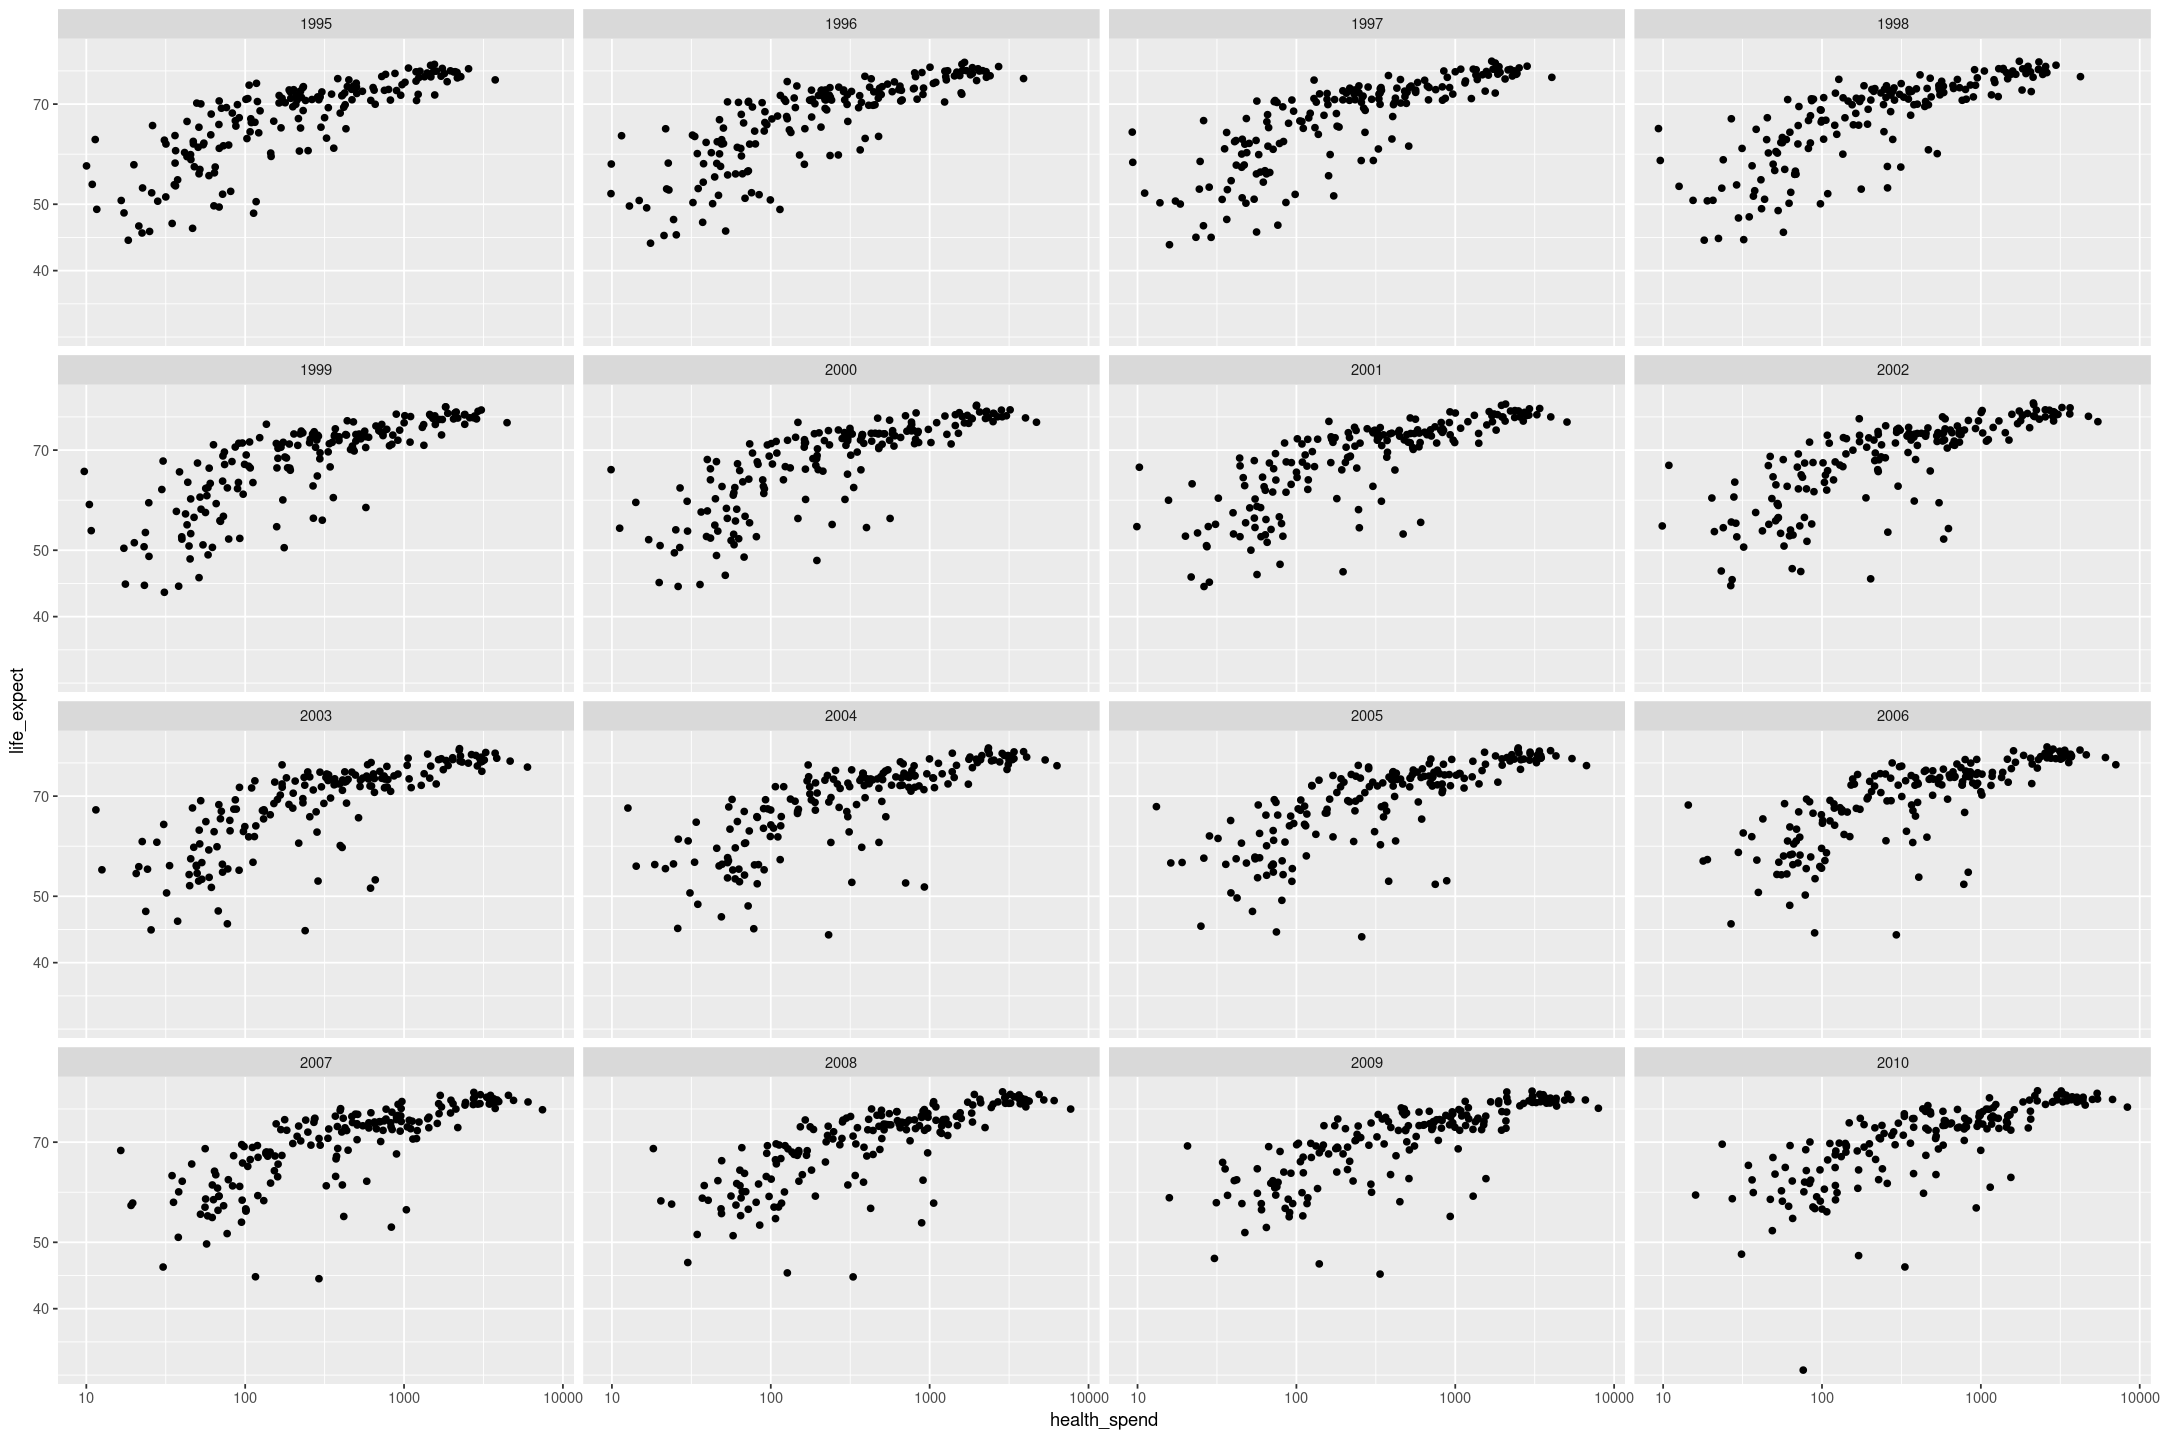

In [81]:
gapminder  %>% 
gf_point(life_expect ~ health_spend | time) +
scale_x_log10() +
scale_y_log10()

In [82]:
gap_models <- gapminder %>%
group_by(time) %>%
nest() %>%
mutate(model = map(data, ~stan_glm(log(life_expect) ~ log(health_spend), data=., refresh=0)))

It looks like a 1% increase in health spending went from being associated with a 0.08% increase in life expectancy in 1995 to a 0.07% in 2010.

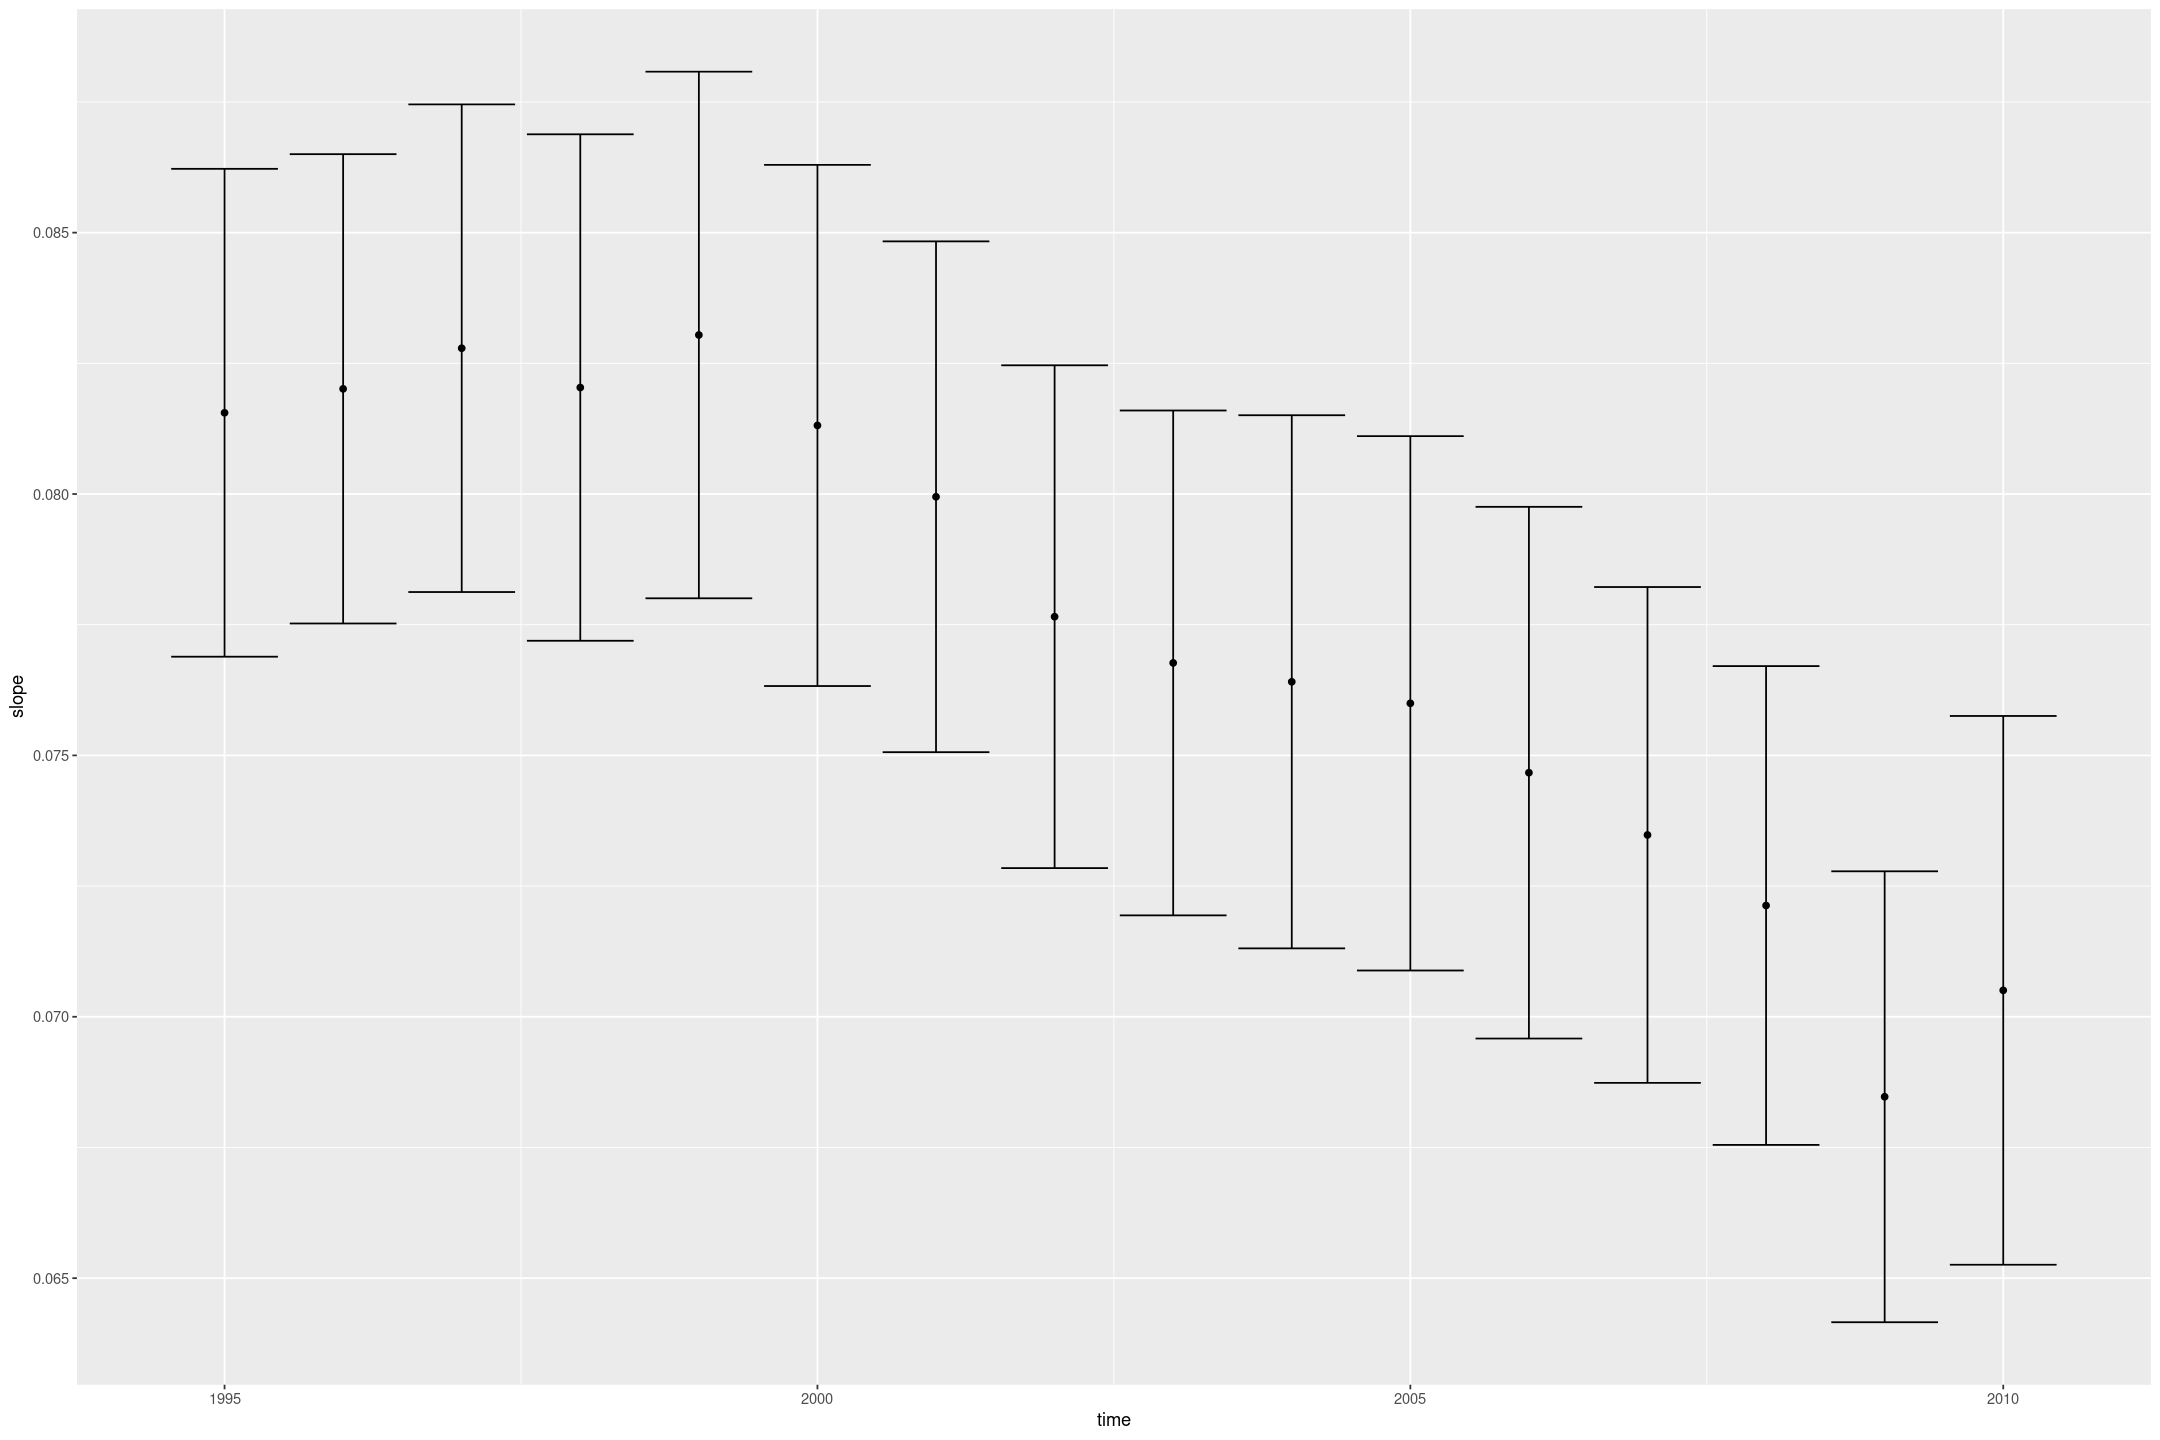

In [83]:
gap_models %>%
mutate(slope = map(model, ~coef(.)['log(health_spend)']),
       se = map(model, ~se(.)['log(health_spend)'])) %>%
select(-data) %>%
unnest(c(slope, se)) %>%
gf_point(slope ~ time) %>%
gf_errorbar(ymin=~slope -se, ymax=~slope+se)

# Building regression models

Return to the teaching evaluations data from Exercise 10.6.
Fit regression models predicting evaluations given many of the inputs in the dataset.
Consider interactions, combinations of predictors, and transformations, as appropriate.
Consider several models, discuss in detail the final model that you choose, and also explain why you chose it rather than the others you had considered.

In [84]:
filename <- "./data/Beauty/beauty.csv"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Beauty/data/beauty.csv')
beauty <- read.csv(filename)

summary(beauty)

      eval           beauty             female            age       
 Min.   :2.100   Min.   :-1.53884   Min.   :0.0000   Min.   :29.00  
 1st Qu.:3.600   1st Qu.:-0.74462   1st Qu.:0.0000   1st Qu.:42.00  
 Median :4.000   Median :-0.15636   Median :0.0000   Median :48.00  
 Mean   :3.998   Mean   :-0.08835   Mean   :0.4212   Mean   :48.37  
 3rd Qu.:4.400   3rd Qu.: 0.45725   3rd Qu.:1.0000   3rd Qu.:57.00  
 Max.   :5.000   Max.   : 1.88167   Max.   :1.0000   Max.   :73.00  
    minority        nonenglish          lower          course_id     
 Min.   :0.0000   Min.   :0.00000   Min.   :0.0000   Min.   : 0.000  
 1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.: 0.000  
 Median :0.0000   Median :0.00000   Median :0.0000   Median : 0.000  
 Mean   :0.1382   Mean   :0.06048   Mean   :0.3391   Mean   : 4.987  
 3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:1.0000   3rd Qu.: 6.000  
 Max.   :1.0000   Max.   :1.00000   Max.   :1.0000   Max.   :30.000  

Course_id is almost always 0, as a predictor we should either compare 0 to non-zero or drop it.

In [85]:
beauty %>% count(course_id) %>% t()

course_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
n,306,5,2,8,19,4,6,4,2,8,5,2,3,3,3,2,4,7,4,6,5,14,11,5,3,3,3,2,4,2,8


### Eval

Let's start by looking at the distribution of `eval`.

From [the paper](https://www.nber.org/system/files/working_papers/w9853/w9853.pdf) `eval` was based on the average response to the question:

>  “Overall, this course  was  very  unsatisfactory  (1);  unsatisfactory  (2);  satisfactory (3); very good (4); excellent (5);”

Interpreting this outcome variable in a lienar regression is a little tricky since the distance between unsatisfactory and satisfactory seems different to the difference between satisfactory and very good.
But I can't think of a way to make it more interpretable - so I will not transform it.

Most scores are around 4 (within 0.5), but there are a few very low scores.

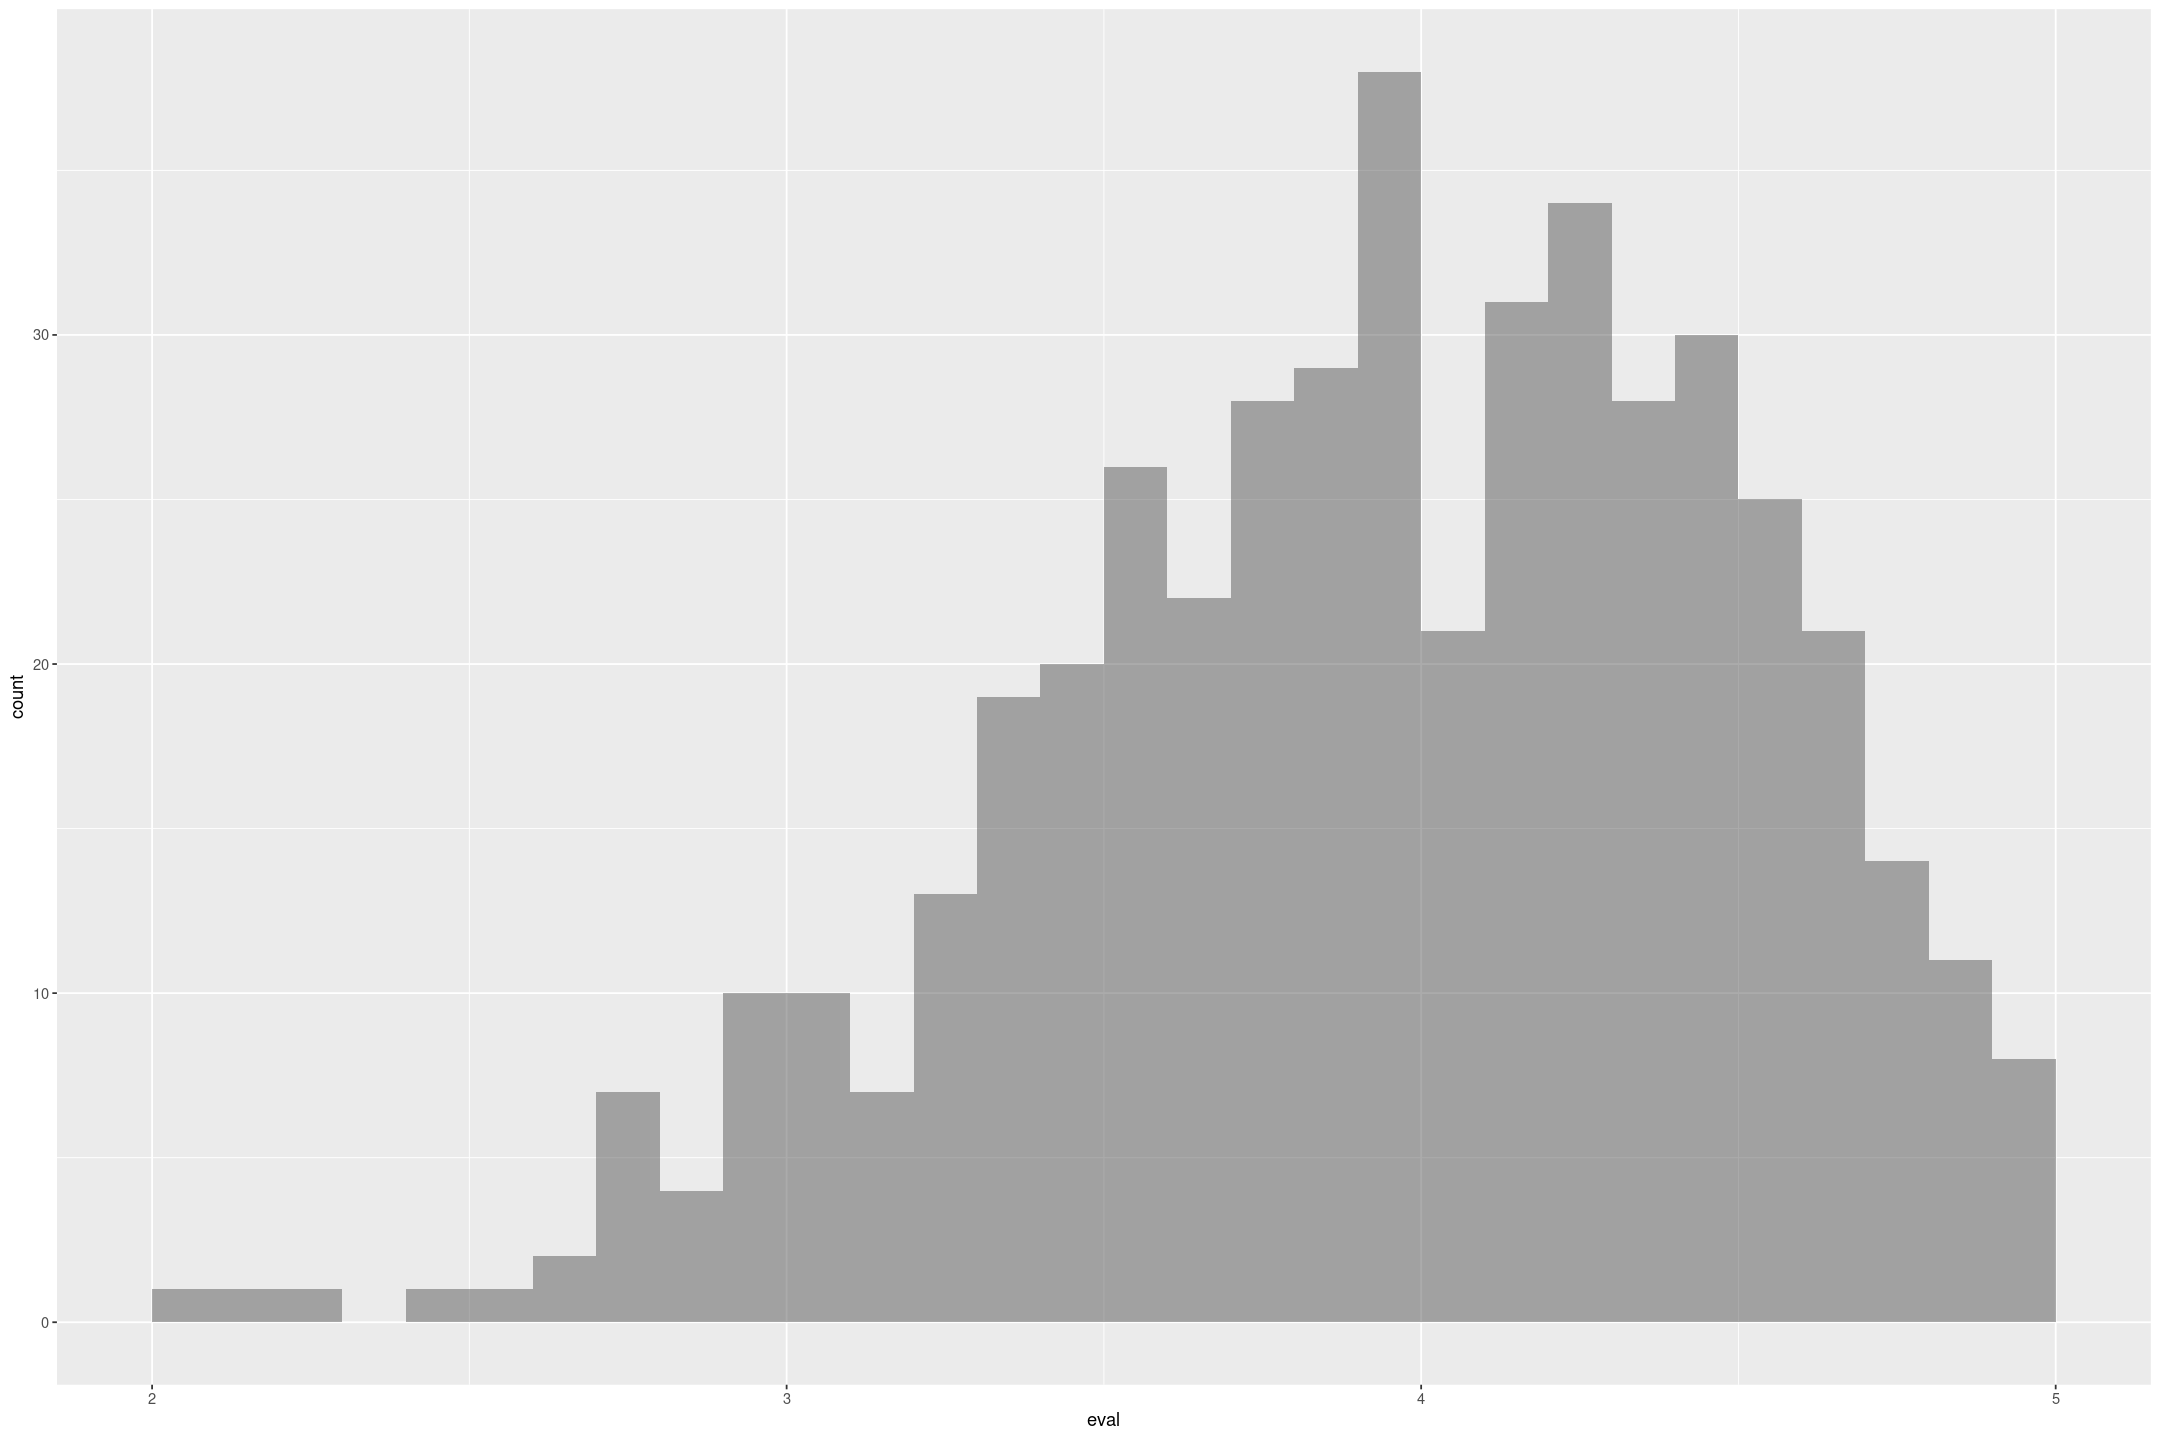

In [86]:
beauty %>% gf_histogram(~eval, breaks=seq(2, 5, by=0.1))

There are two quantitative variables that we could transform - beauty and age.

### Beauty

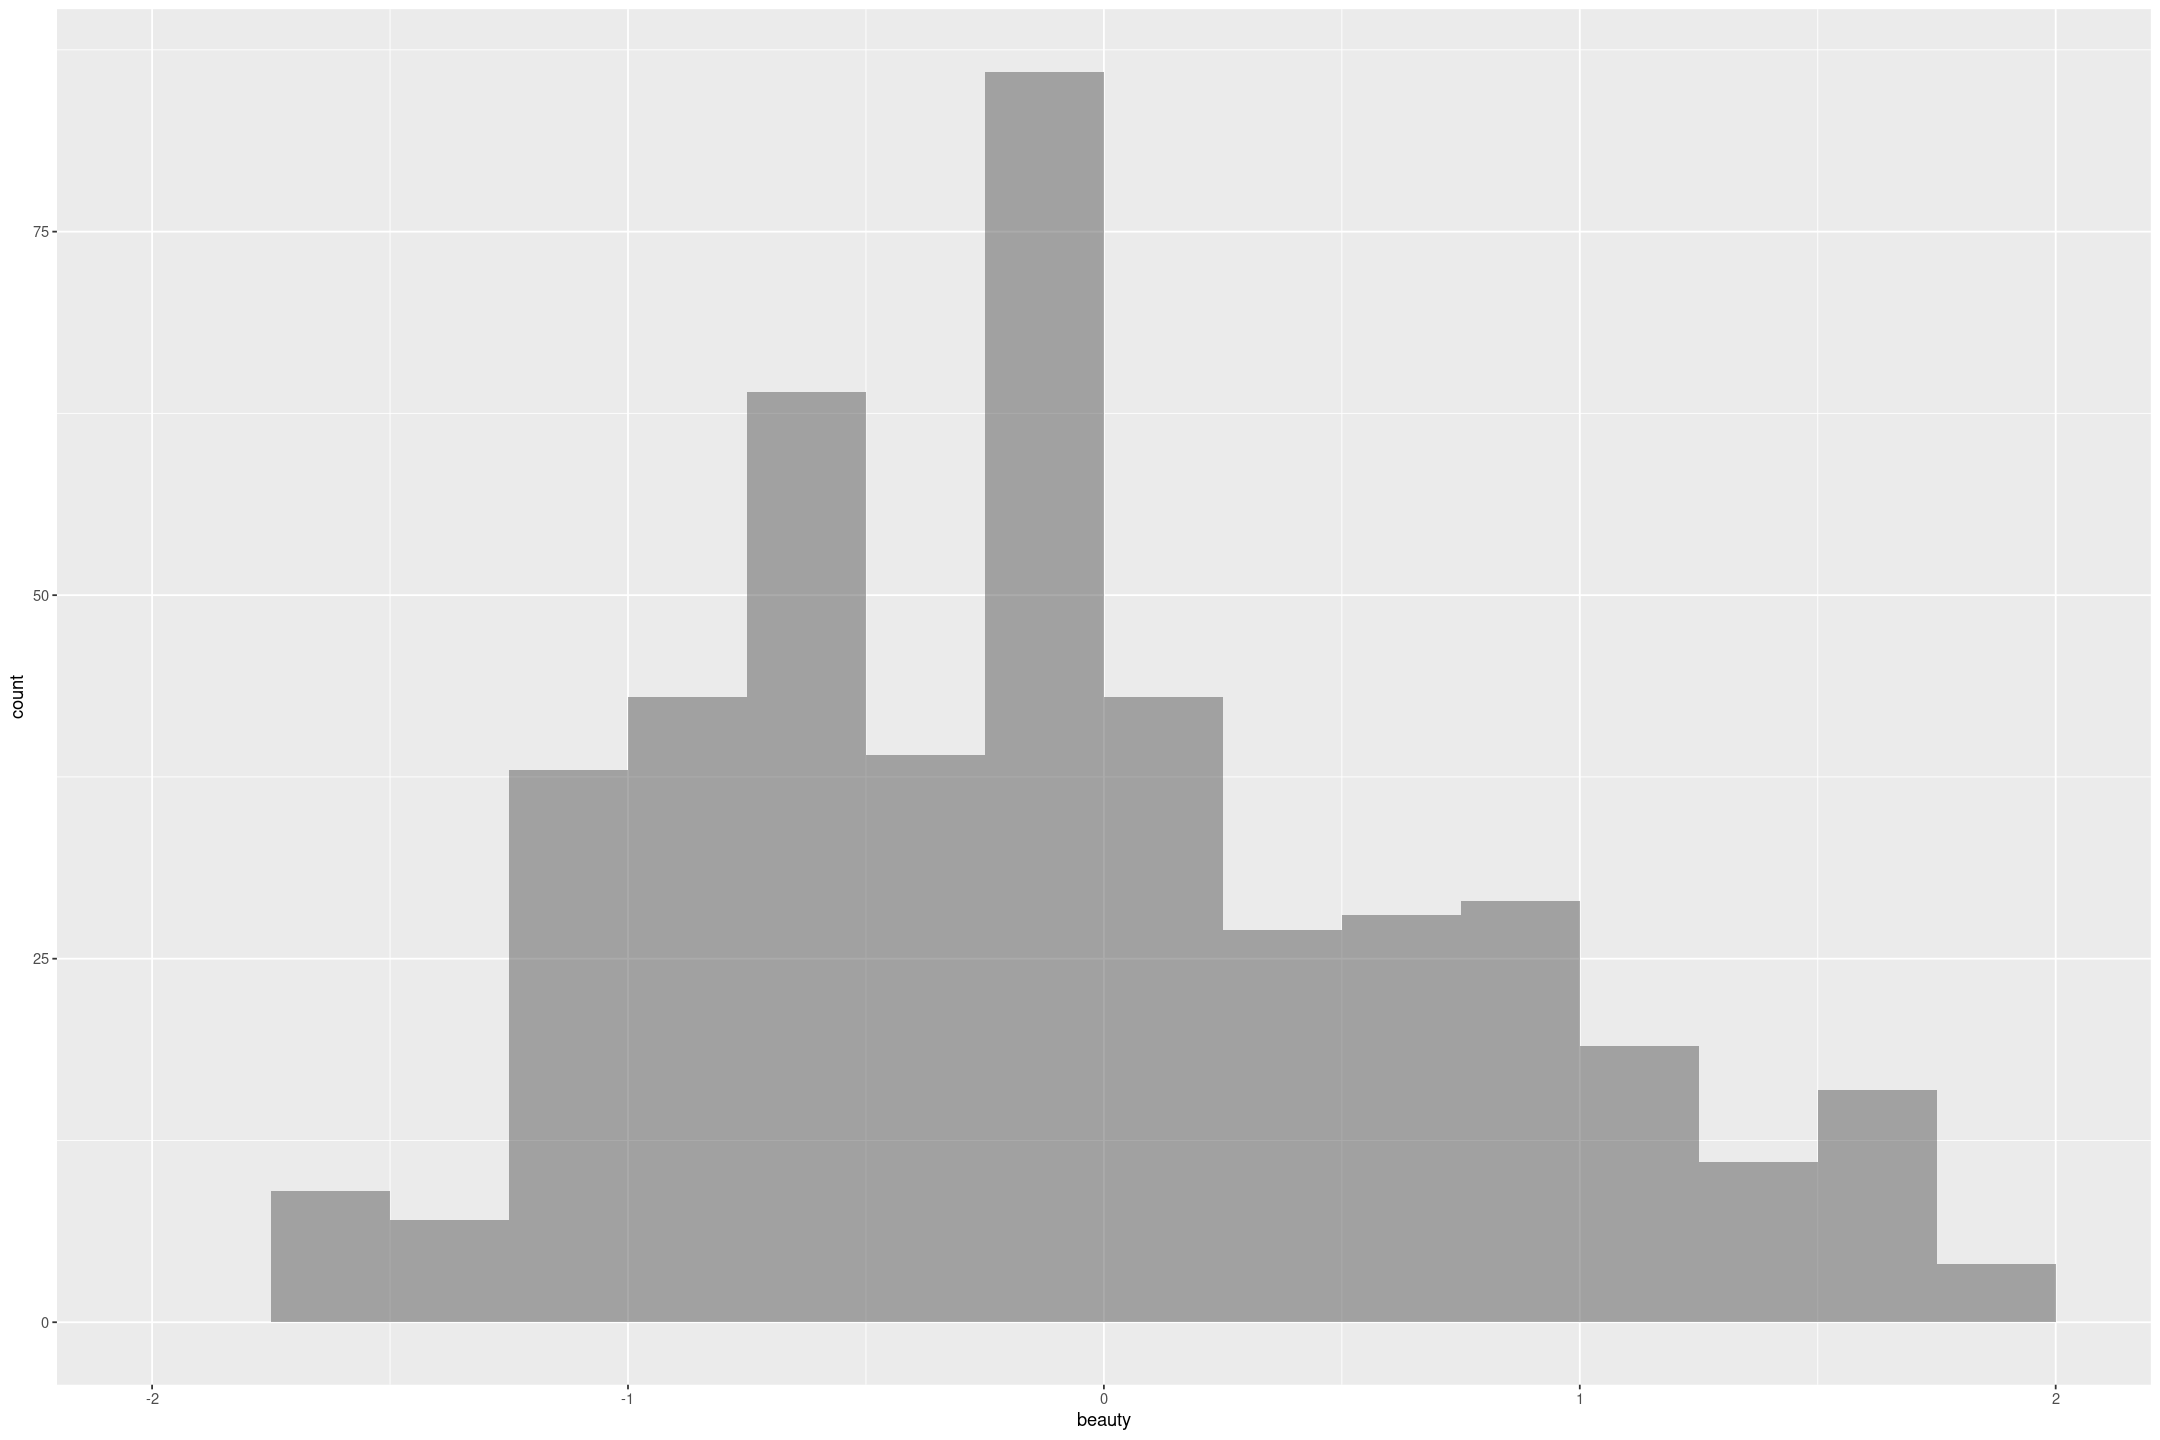

In [87]:
beauty %>% gf_histogram(~beauty, breaks=seq(-2, 2, by=0.25))

It's really hard to see a pattern between beauty and eval, and so linear seems as good as anything else.

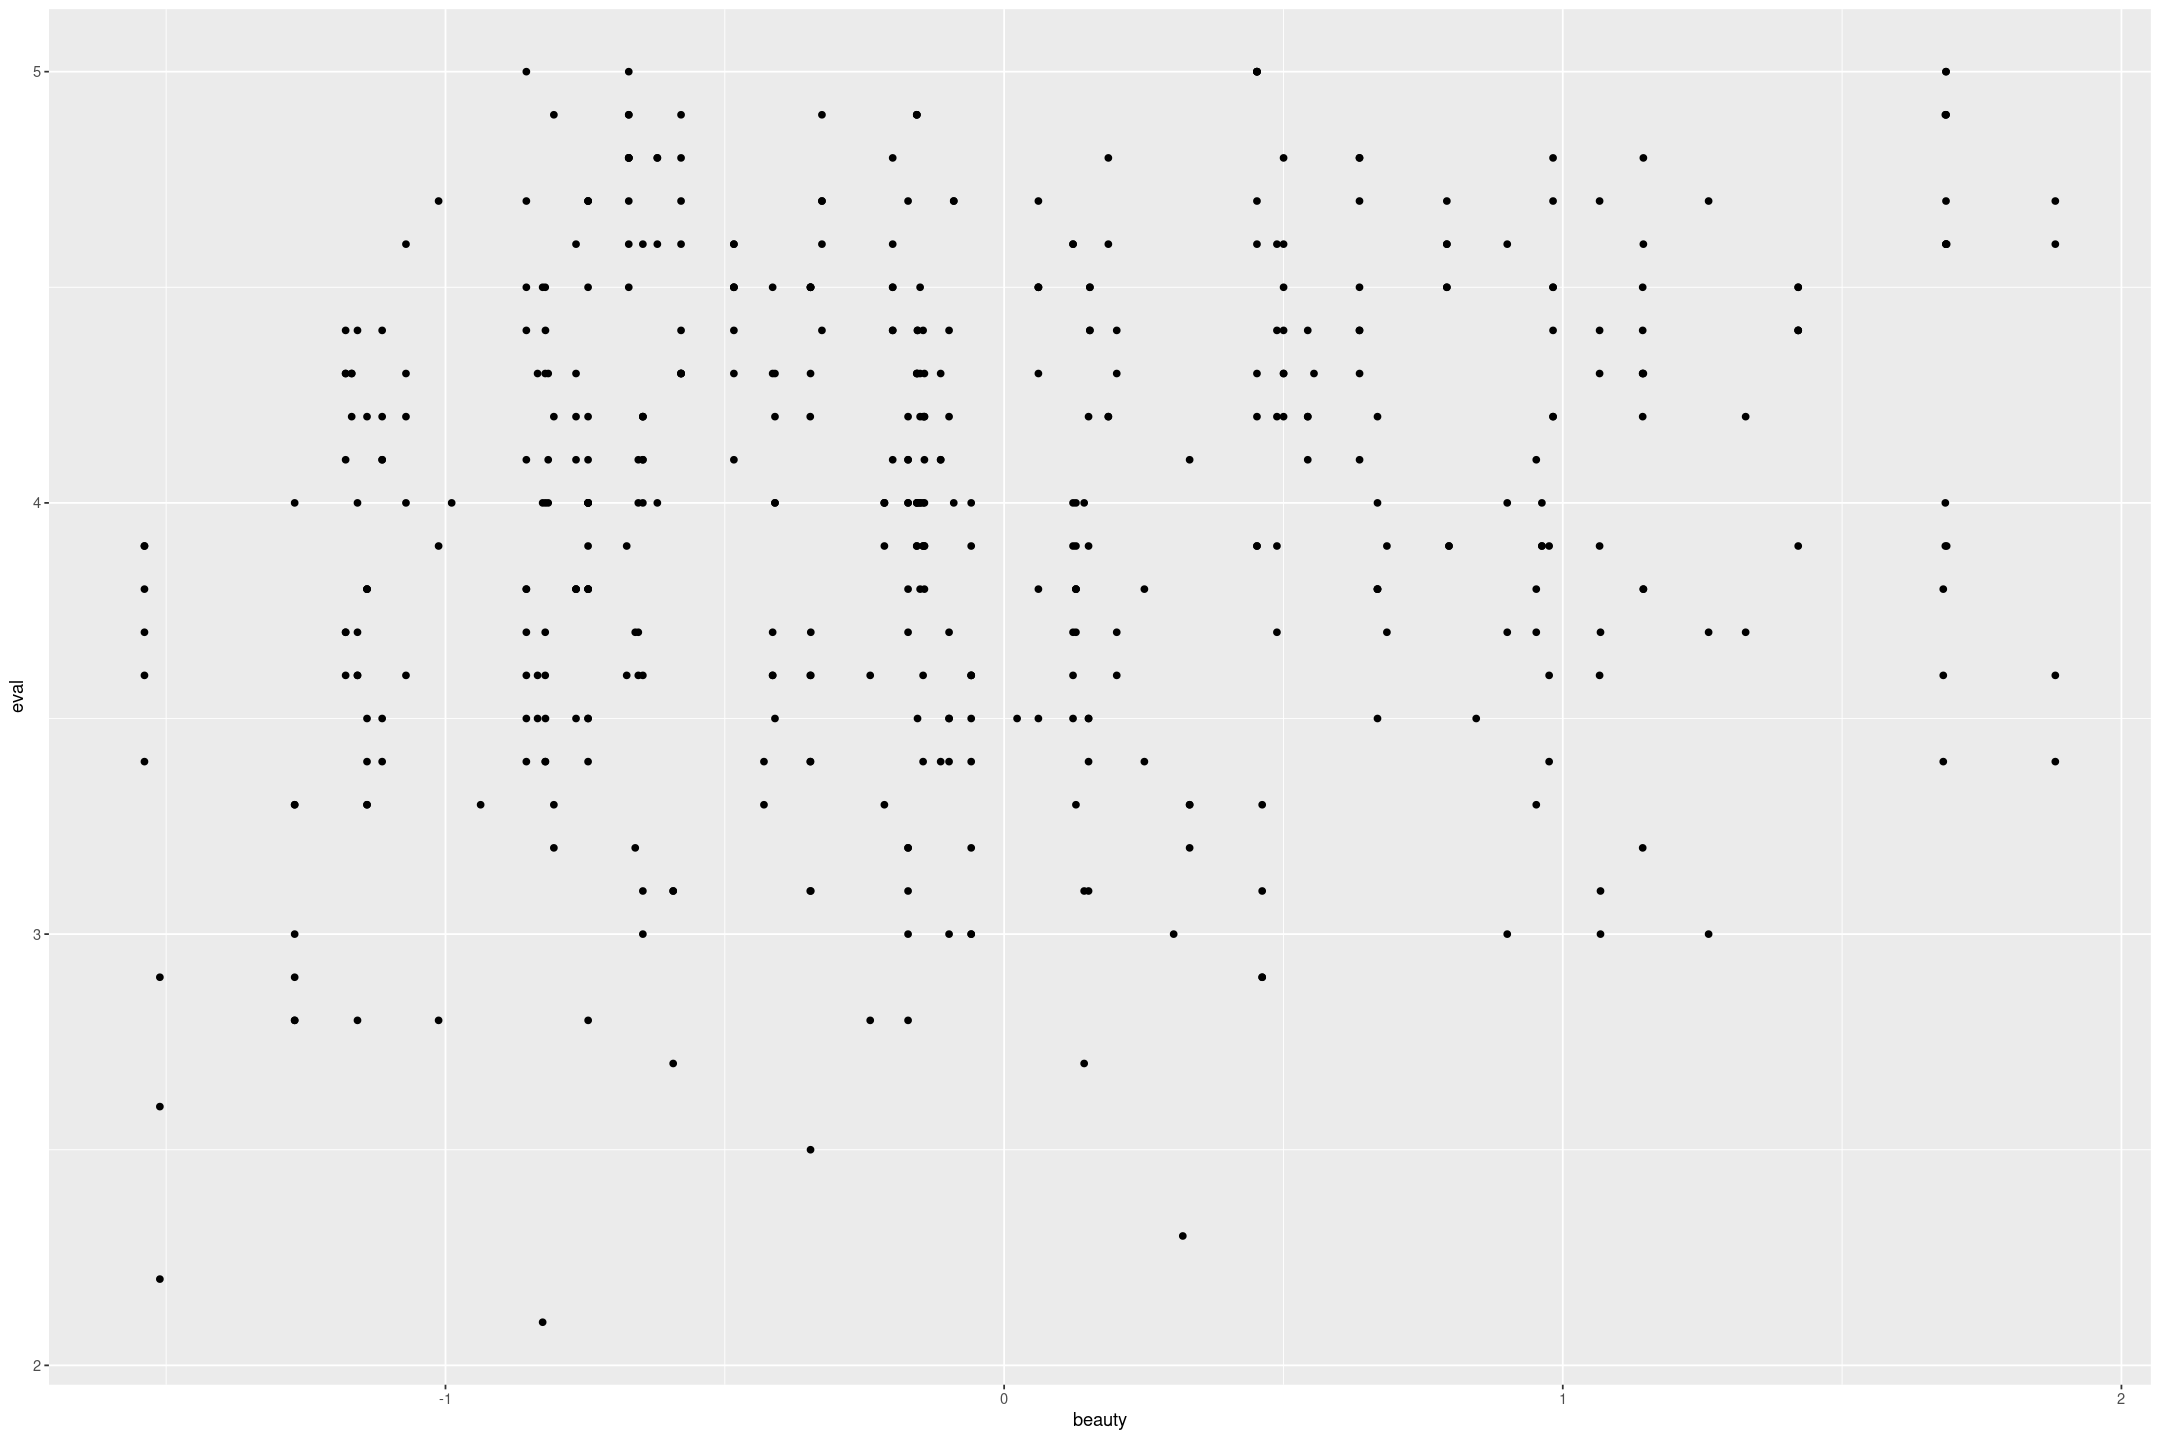

In [88]:
gf_point(eval ~ beauty, data=beauty)

Given beauty has no real meaning let's standardise it, dividing by 2 standard deviations to make comparable to binary variables.

In [89]:
beauty <- beauty %>% mutate(std_beauty = (beauty - mean(beauty)) / (2 * sd(beauty)))

### Age

Again there's no clear pattern between between age and eval, so to make the effects more interpretable let's standardise it too.

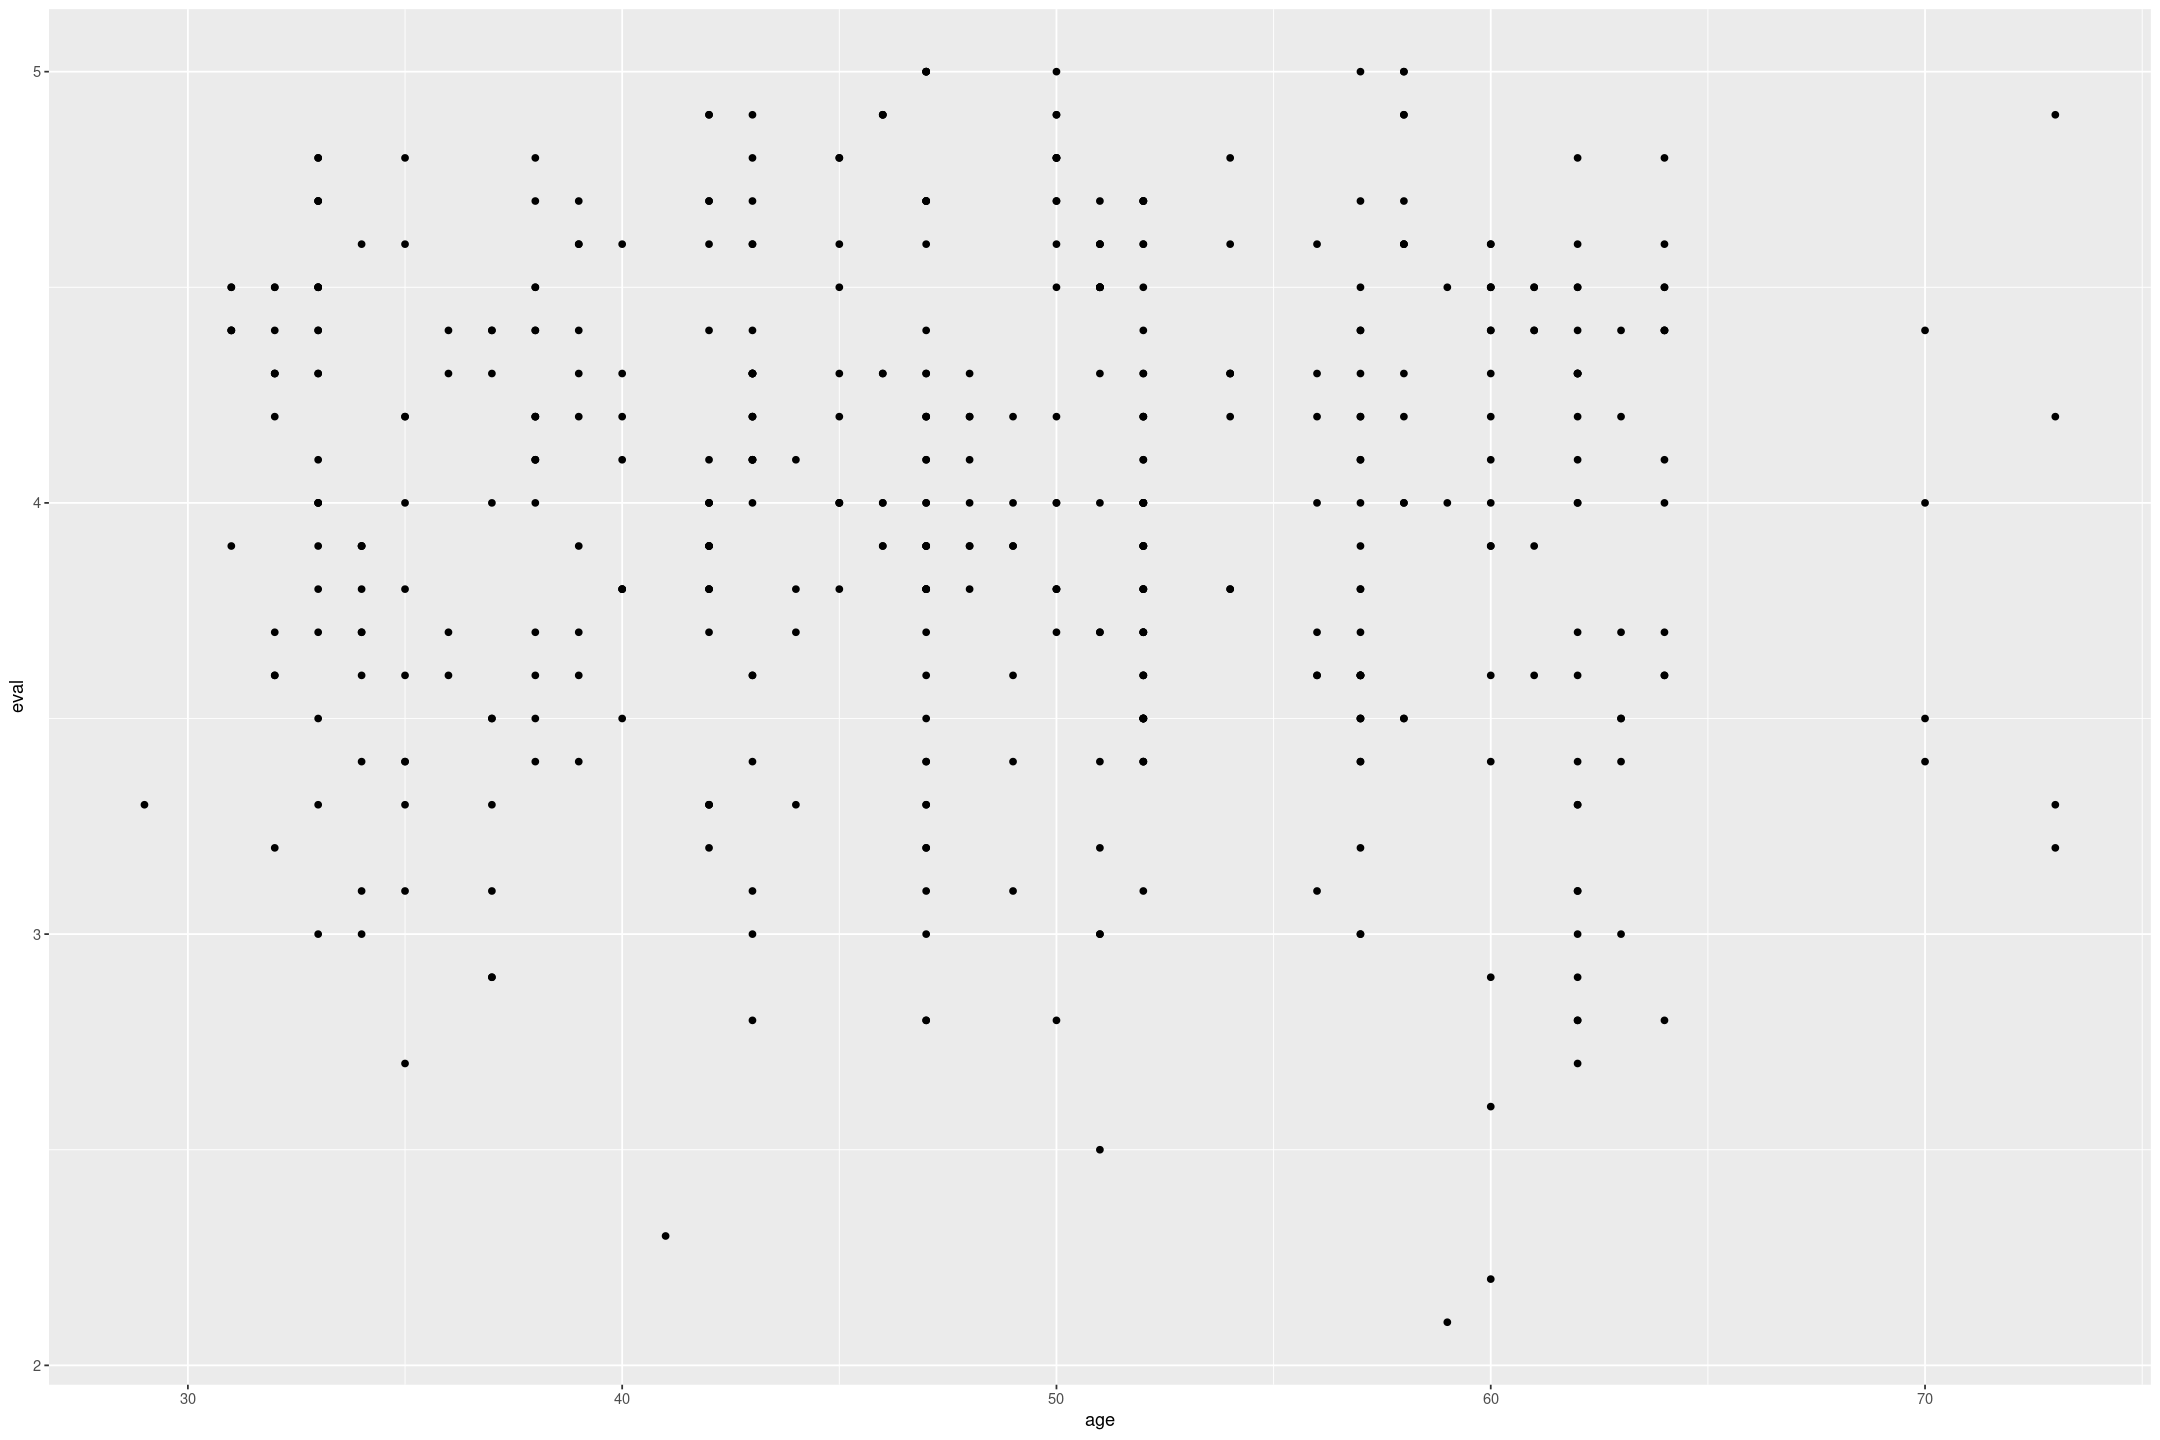

In [90]:
gf_point(eval ~ age, data=beauty)

In [91]:
beauty <- beauty %>% mutate(std_age = (age - mean(age)) / (2 * sd(age)))

## Initial model - throw it all in

In [92]:
beauty <- beauty %>% mutate(course0 = course_id == 0)

In [93]:
fit_beauty_linear_0 <- stan_glm(eval ~ std_beauty + std_age + female + minority + nonenglish + lower + course0,
                             data=beauty,
                             refresh=0)
print(fit_beauty_linear_0, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ std_beauty + std_age + female + minority + nonenglish + 
	   lower + course0
 observations: 463
 predictors:   8
------
            Median MAD_SD
(Intercept)  4.05   0.05 
std_beauty   0.22   0.05 
std_age     -0.04   0.06 
female      -0.20   0.05 
minority    -0.06   0.08 
nonenglish  -0.28   0.11 
lower        0.09   0.05 
course0TRUE  0.04   0.06 

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.53   0.02  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


Since our coefficients are standardised they are all on the same scale.

Beauty, female and nonenglish all have a strong effect and so should be included in the model.

Age, minority and lower all have a weak and uncertain effect, but there's valid reasons to include them in the model, as there is good reason to think they may impact student evaluations.

The course_id has a weak and uncertain effect, and no meaning, so we will drop it.

In [94]:
fit_beauty_linear <- stan_glm(eval ~ std_beauty + std_age + female + minority + nonenglish + lower,
                             data=beauty,
                             refresh=0)
print(fit_beauty_linear, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ std_beauty + std_age + female + minority + nonenglish + 
	   lower
 observations: 463
 predictors:   7
------
            Median MAD_SD
(Intercept)  4.08   0.04 
std_beauty   0.22   0.05 
std_age     -0.04   0.05 
female      -0.20   0.05 
minority    -0.07   0.08 
nonenglish  -0.27   0.11 
lower        0.10   0.06 

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.53   0.02  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


### Model Checking

In [95]:
beauty$linear_pred <- predict(fit_beauty_linear)
beauty$linear_resid <- beauty$eval - beauty$linear_pred

There's no real pattern to the residuals and variance looks to be constant, so it seems consistent with the error assumptions.

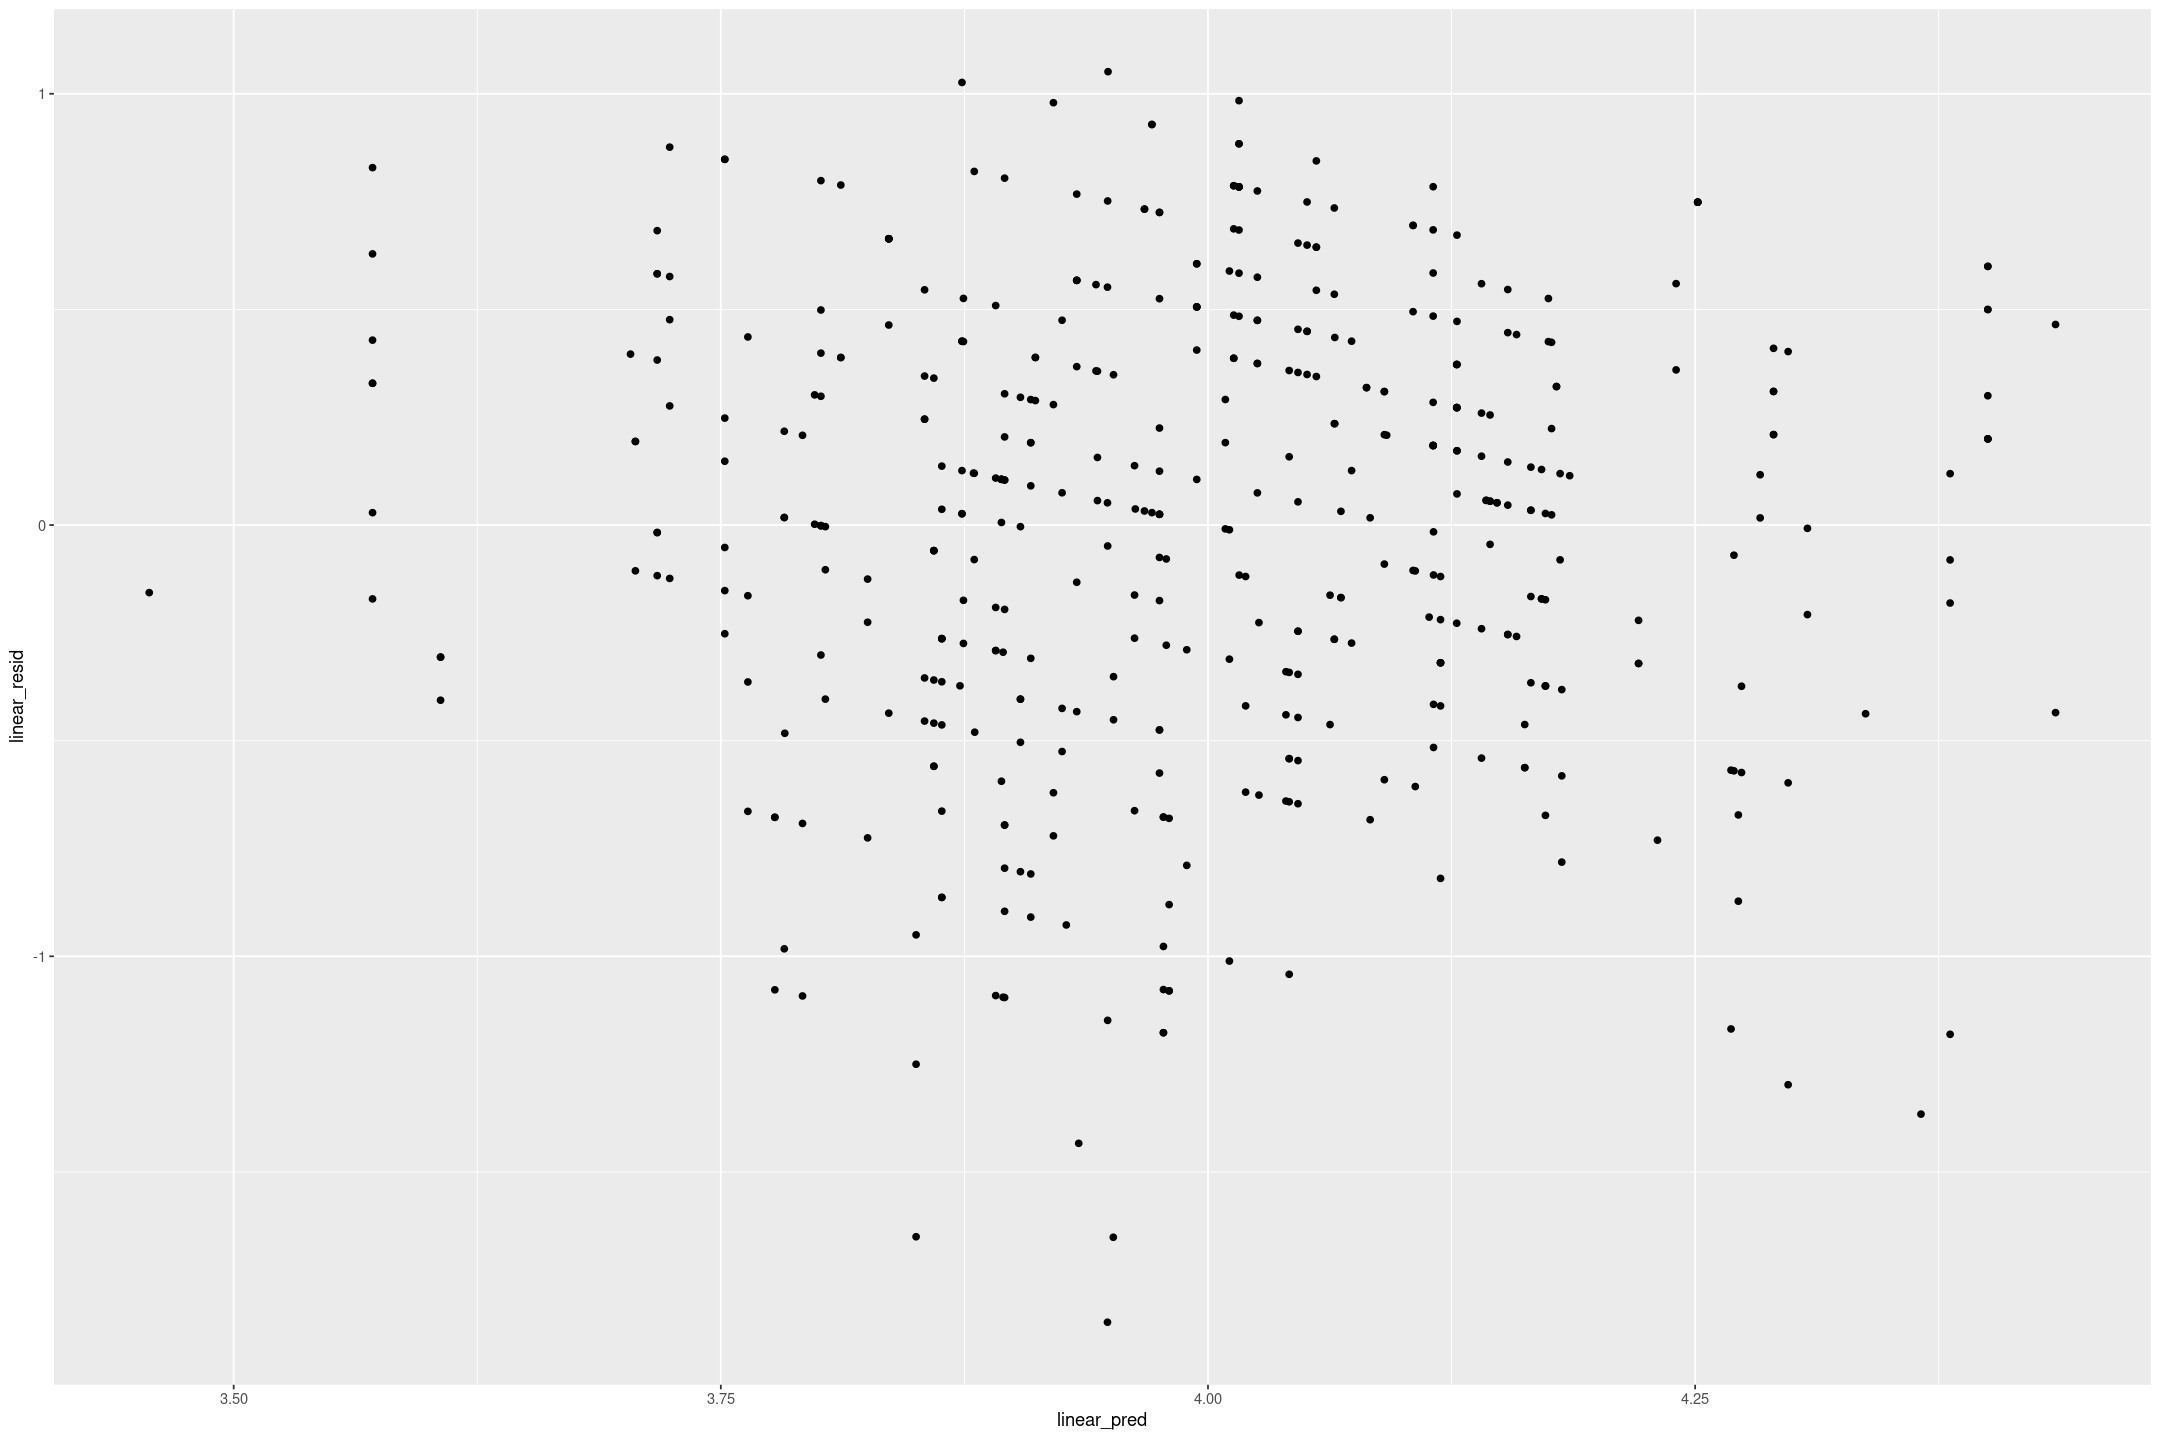

In [96]:
beauty %>%
gf_point(linear_resid ~ linear_pred)

Posterior predictive check on the distribution

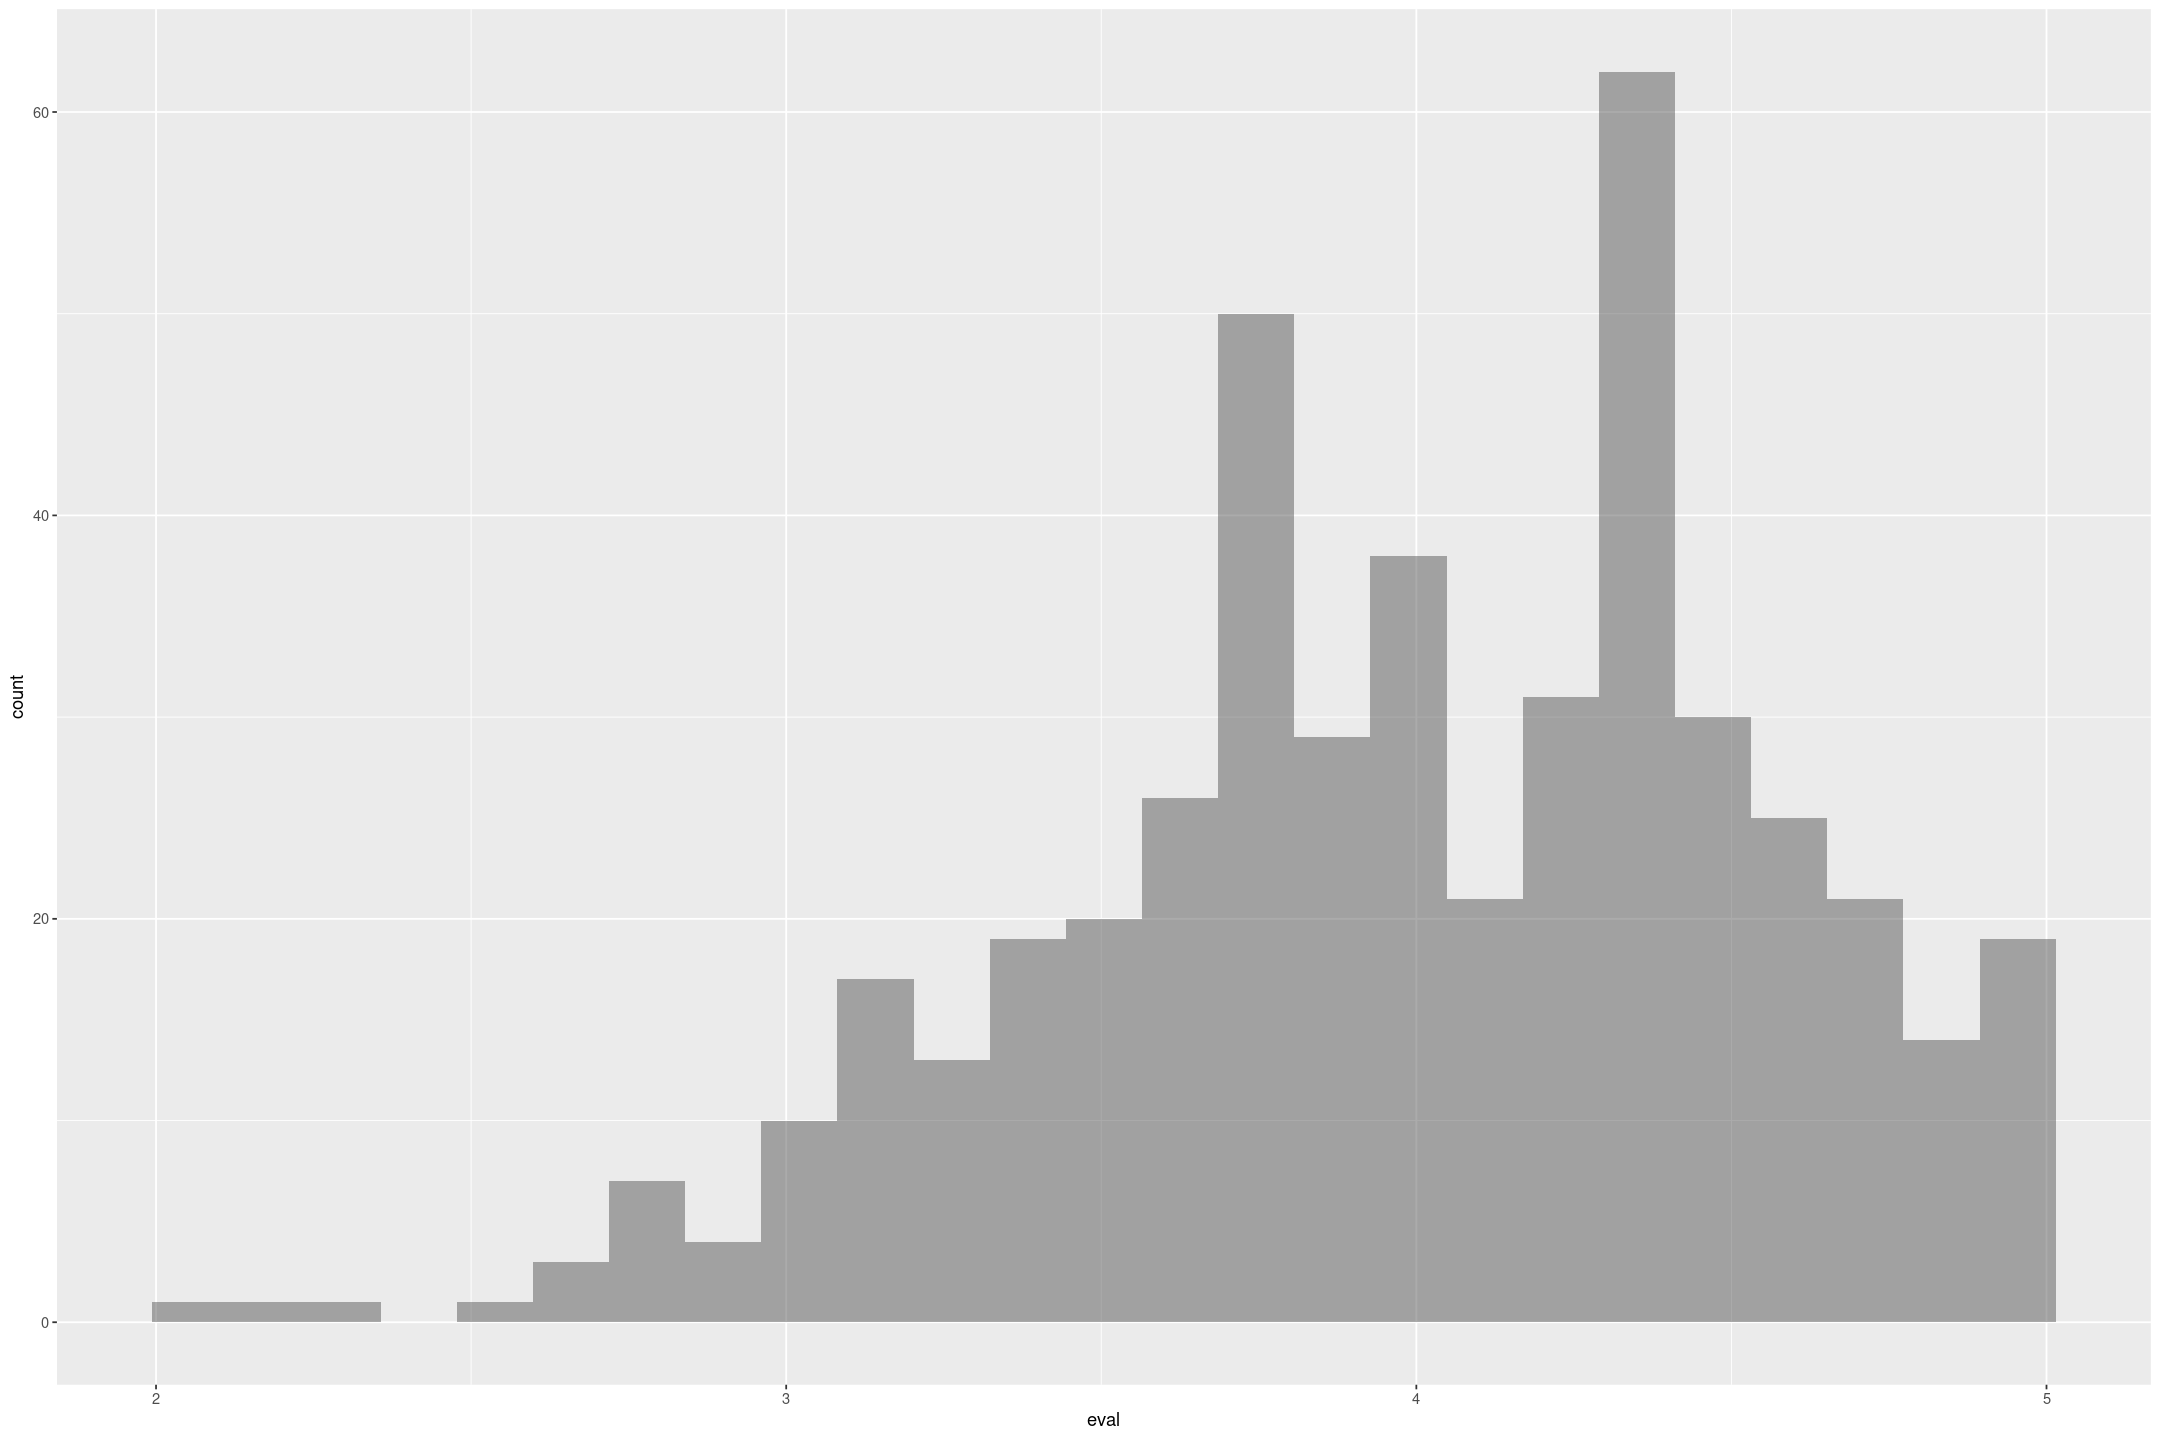

In [97]:
beauty %>% gf_histogram(~eval, eval)

They're a bit too centred, and there are some predictions greater than 5!
But not a terrible fit.

Perhaps a logistic function would be a better fit for the outcome (but requires more modelling knowledge).

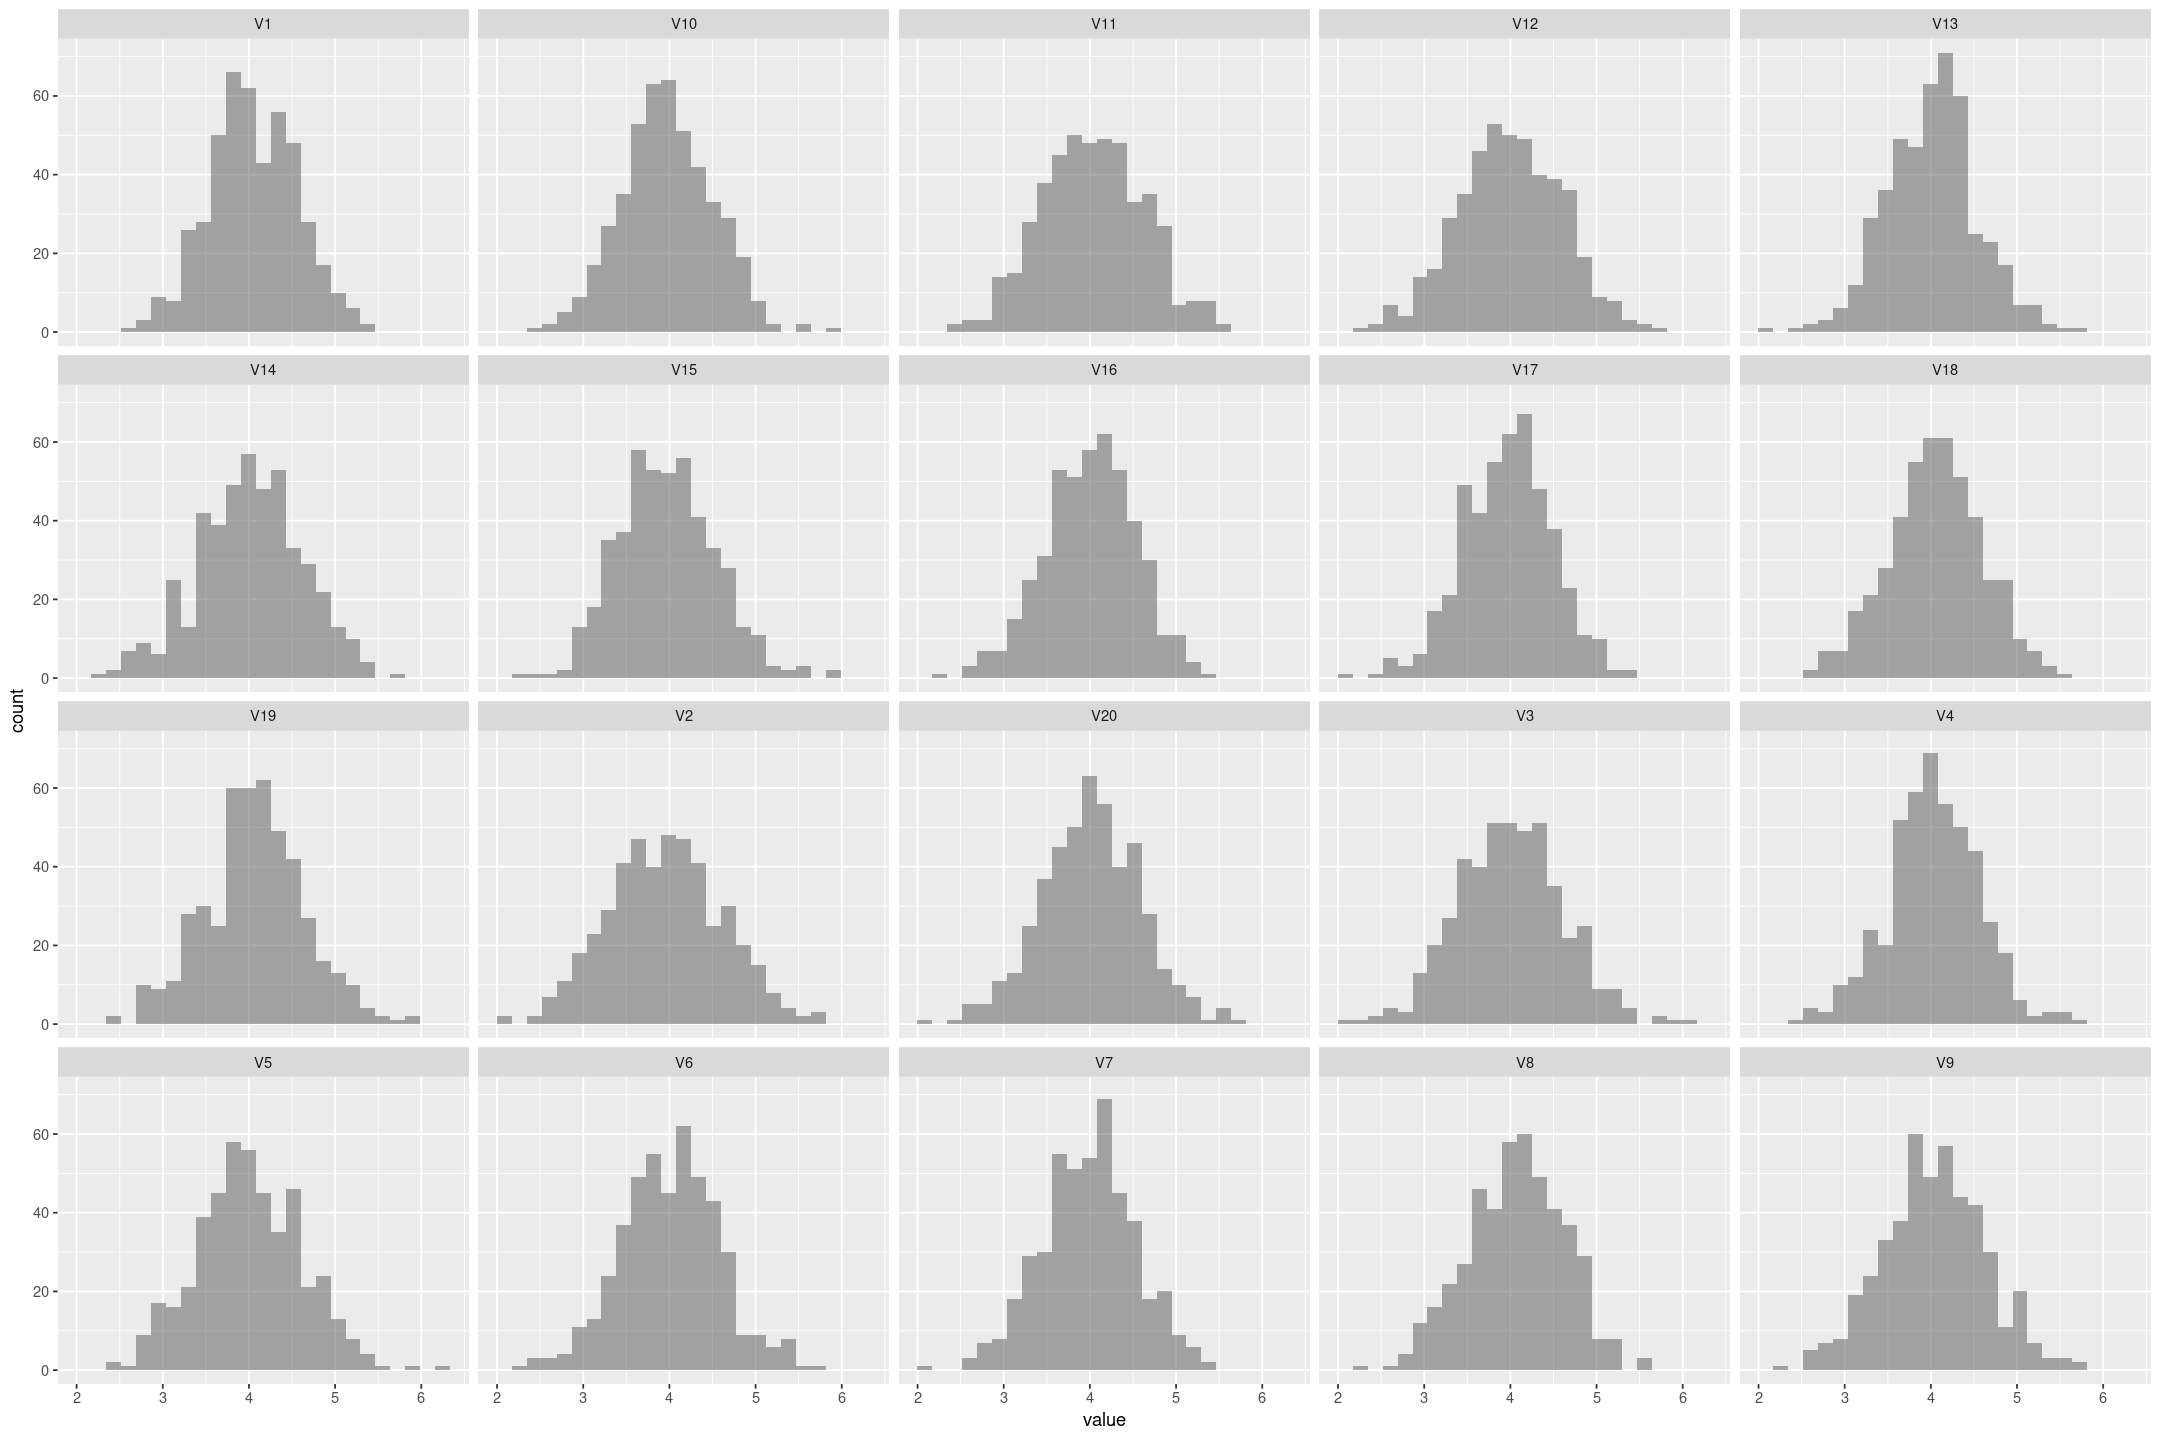

In [98]:
posterior_predict(fit_beauty_linear, draws=20) %>%
t() %>%
as.data.frame() %>%
pivot_longer(starts_with('V')) %>%
gf_histogram(~value | name)

## Adding Interactions

Beauty, female and nonenglish were the strongest predictors, so we can try adding interactions between them.

In [99]:
fit_beauty_interact <- stan_glm(eval ~ std_beauty + std_age + female + minority + nonenglish + lower + 
                              std_beauty:female + std_beauty:nonenglish + female:nonenglish,
                             data=beauty,
                             refresh=0)
print(fit_beauty_interact, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ std_beauty + std_age + female + minority + nonenglish + 
	   lower + std_beauty:female + std_beauty:nonenglish + female:nonenglish
 observations: 463
 predictors:   10
------
                      Median MAD_SD
(Intercept)            4.09   0.04 
std_beauty             0.30   0.07 
std_age               -0.04   0.05 
female                -0.21   0.06 
minority              -0.04   0.08 
nonenglish            -0.41   0.15 
lower                  0.09   0.06 
std_beauty:female     -0.17   0.10 
std_beauty:nonenglish  0.13   0.57 
female:nonenglish      0.26   0.22 

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.53   0.02  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


The interaction between beauty and female is significant and meaningful - the impact of beauty on evaluation if different betwen males and females, and surprisingly the effect is *lower* for females.

In general females have higher beauty scores than males, so the standards may be different per gender, which we're seeing in the effect of evaluation.

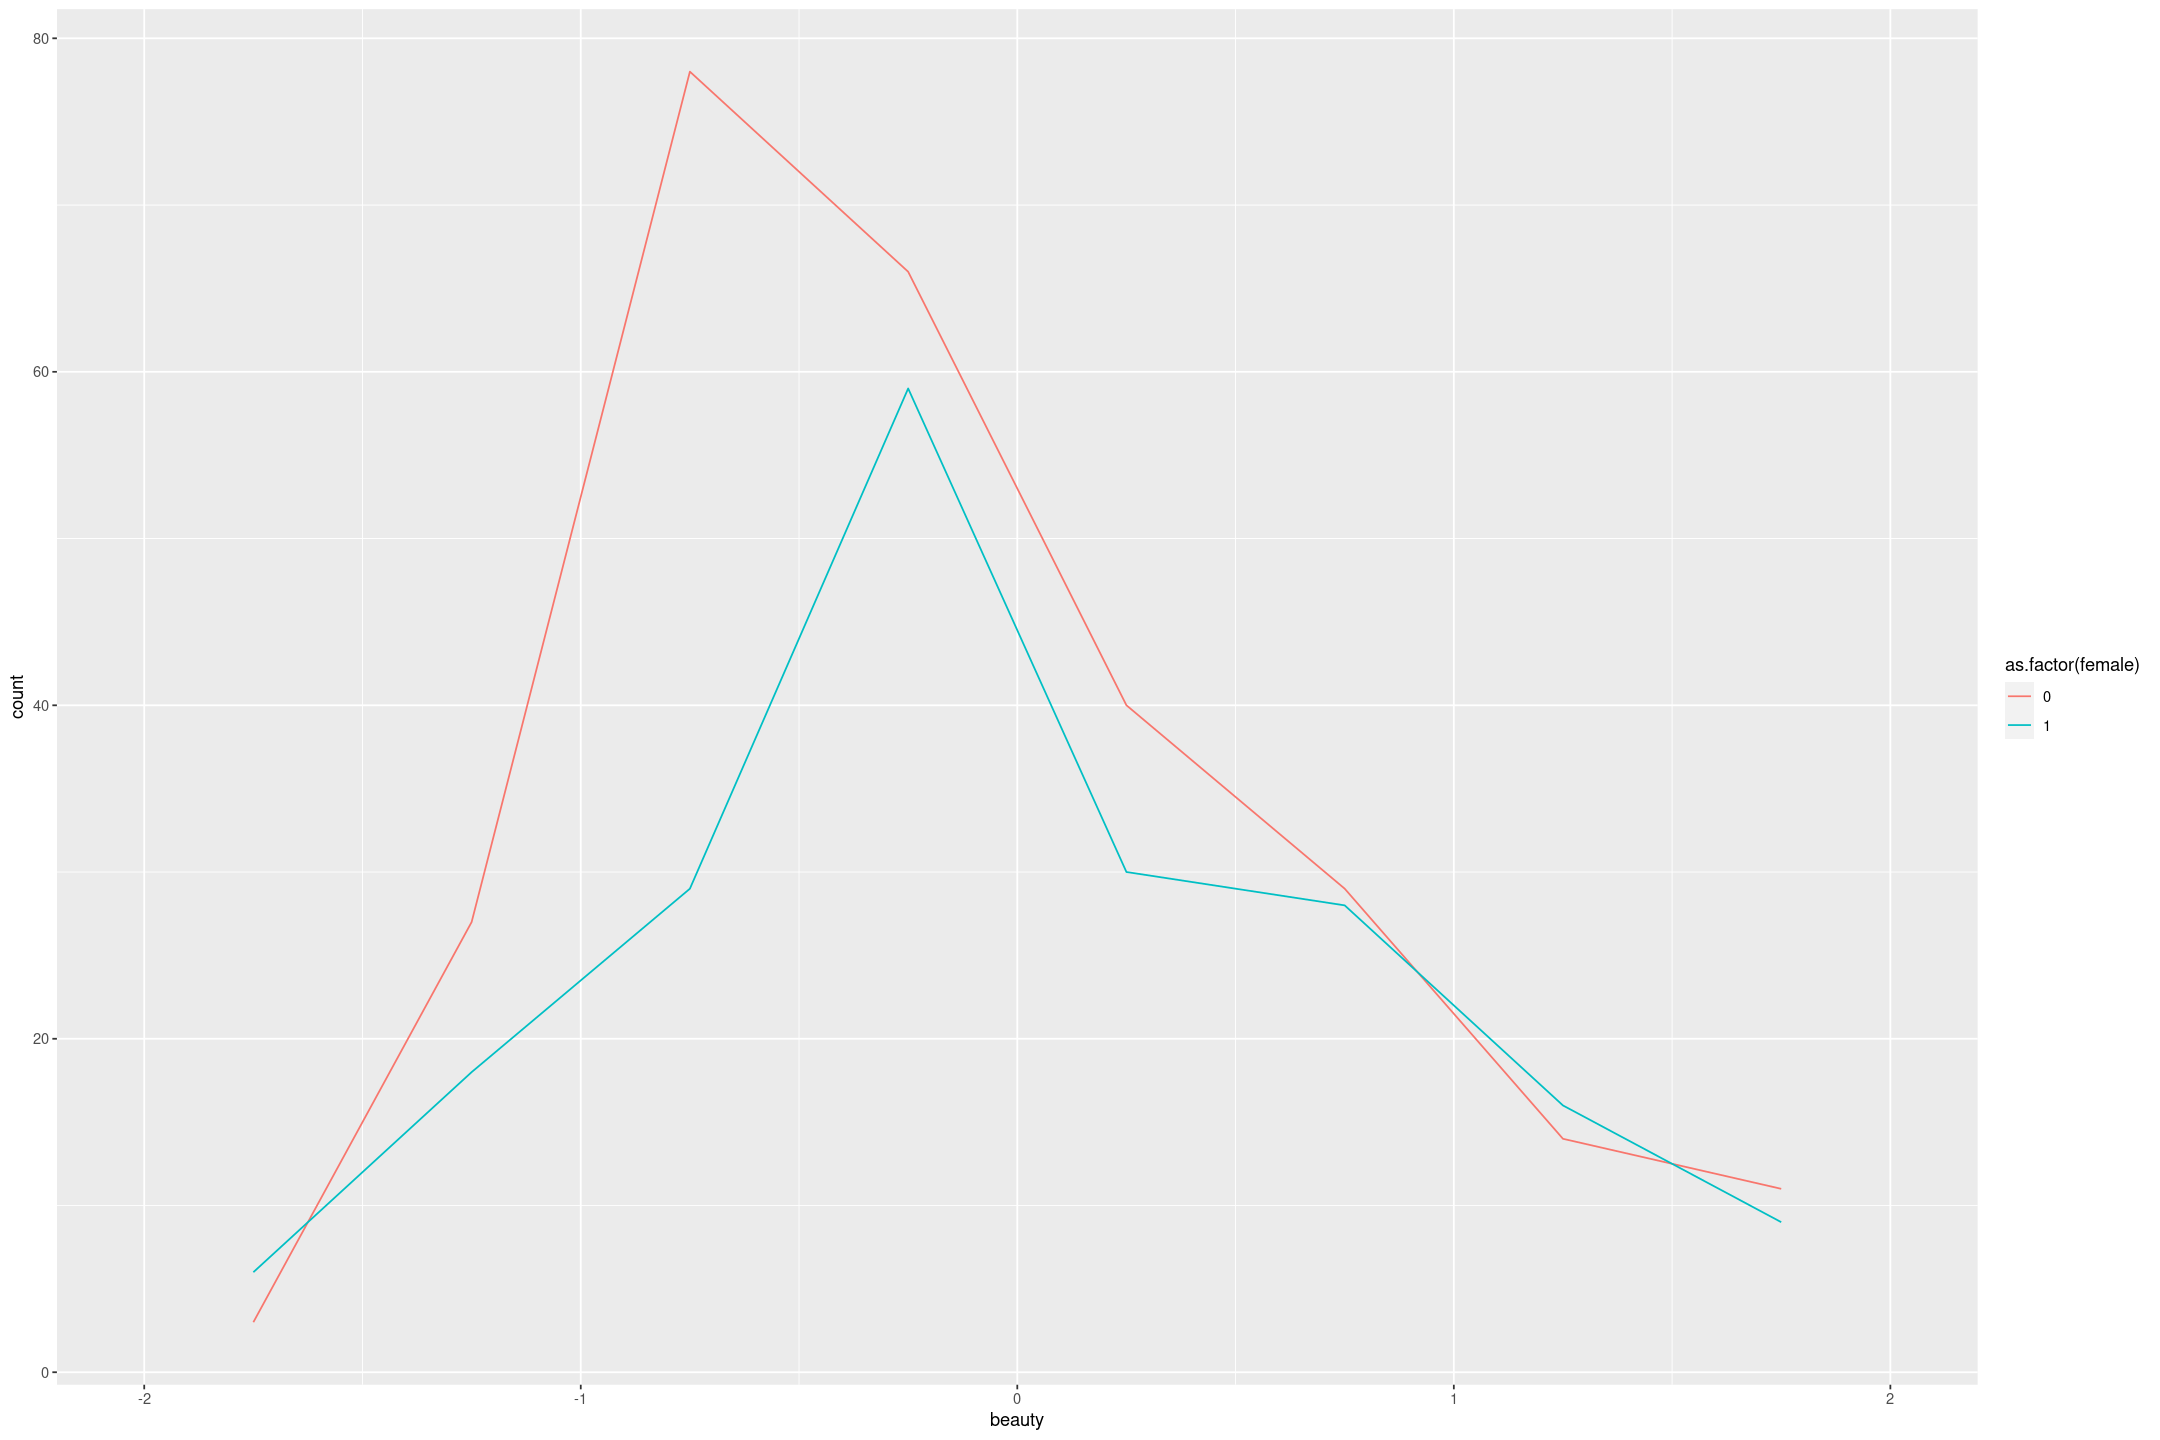

In [100]:
beauty %>% gf_freqpoly(~beauty, group=~female, col=~as.factor(female), breaks=seq(-2,2, by=0.5))

In [101]:
fit_beauty_interact_female <- stan_glm(eval ~ std_beauty + std_age + female + minority + nonenglish + lower + 
                              std_beauty:female + female:nonenglish,
                             data=beauty,
                             refresh=0)
print(fit_beauty_interact_female, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ std_beauty + std_age + female + minority + nonenglish + 
	   lower + std_beauty:female + female:nonenglish
 observations: 463
 predictors:   9
------
                  Median MAD_SD
(Intercept)        4.09   0.04 
std_beauty         0.30   0.07 
std_age           -0.04   0.06 
female            -0.21   0.05 
minority          -0.03   0.08 
nonenglish        -0.41   0.14 
lower              0.09   0.06 
std_beauty:female -0.16   0.10 
female:nonenglish  0.27   0.21 

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.53   0.02  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


It's not clear to me whether we should include `female:nonenglish` so let's compare the models using Leave-One-Out Cross Validation.

In [102]:
fit_beauty_interact_female_beauty <- stan_glm(eval ~ std_beauty + std_age + female + minority + nonenglish + lower + 
                              std_beauty:female,
                             data=beauty,
                             refresh=0)
print(fit_beauty_interact_female_beauty, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ std_beauty + std_age + female + minority + nonenglish + 
	   lower + std_beauty:female
 observations: 463
 predictors:   8
------
                  Median MAD_SD
(Intercept)        4.08   0.04 
std_beauty         0.30   0.07 
std_age           -0.04   0.05 
female            -0.19   0.05 
minority          -0.04   0.08 
nonenglish        -0.30   0.11 
lower              0.09   0.05 
std_beauty:female -0.16   0.10 

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.53   0.02  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


Comparing the Leave One Out cross valiations dropping the female:nonenglish interaction actually seems to improve the model.

In [103]:
loo_beauty_linear <- loo(fit_beauty_linear)
loo_beauty_interact <- loo(fit_beauty_interact)
loo_beauty_interact_female <- loo(fit_beauty_interact_female)
loo_beauty_interact_female_beauty <- loo(fit_beauty_interact_female_beauty)

loo_compare(loo_beauty_linear,
            loo_beauty_interact,
           loo_beauty_interact_female,
           loo_beauty_interact_female_beauty)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
fit_beauty_interact_female_beauty,0.0000000,0.000000,-368.2301,15.11184,8.865830,0.6876597,736.4602,30.22369
fit_beauty_interact_female,-0.1423307,1.137577,-368.3725,15.11195,9.609508,0.7592905,736.7449,30.22390
fit_beauty_linear,-0.3638083,1.588372,-368.5939,15.15511,7.966073,0.6207543,737.1879,30.31022
fit_beauty_interact,-1.1418613,1.270702,-369.3720,15.03101,10.394588,0.8806897,738.7440,30.06202


## Model Checking

So we've got our final model `fit_beauty_interact_female_beauty`

In [104]:
beauty$pred <- predict(fit_beauty_interact_female_beauty)
beauty$resid <- beauty$eval - beauty$pred

Again the residual plot looks reasonable

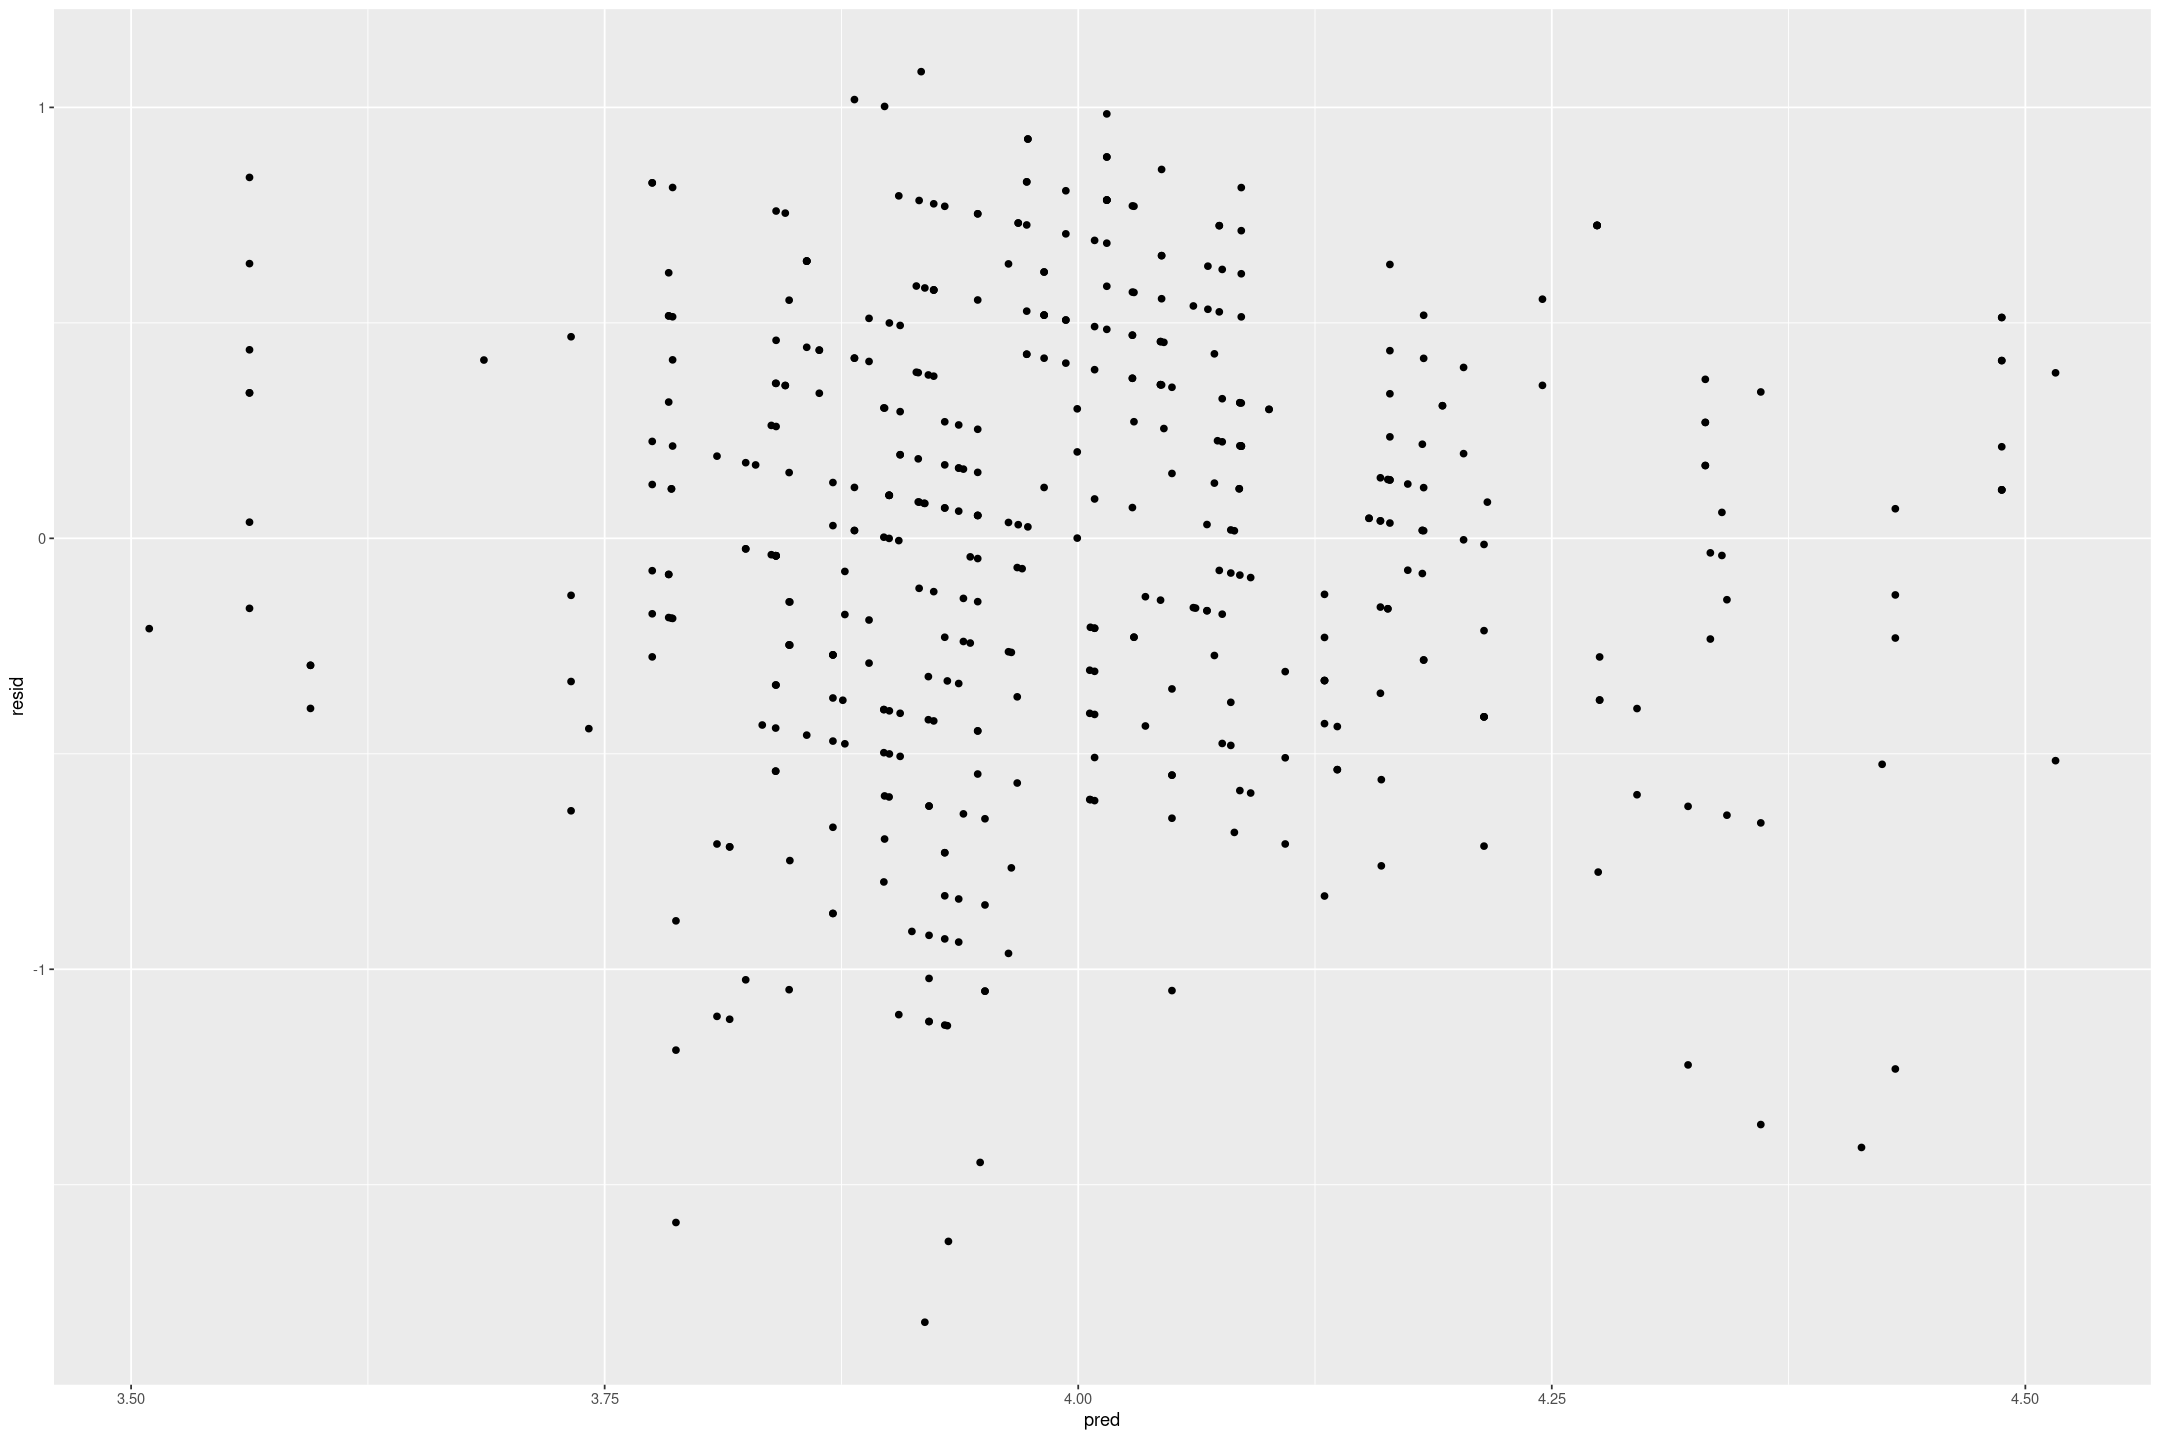

In [105]:
beauty %>% gf_point(resid ~ pred)

## Interpretation

In [106]:
fit_beauty_interact_female_beauty

stan_glm
 family:       gaussian [identity]
 formula:      eval ~ std_beauty + std_age + female + minority + nonenglish + 
	   lower + std_beauty:female
 observations: 463
 predictors:   8
------
                  Median MAD_SD
(Intercept)        4.1    0.0  
std_beauty         0.3    0.1  
std_age            0.0    0.1  
female            -0.2    0.1  
minority           0.0    0.1  
nonenglish        -0.3    0.1  
lower              0.1    0.1  
std_beauty:female -0.2    0.1  

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.5    0.0   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

Because we've standardised the predictors the intercept tells us that the average score for a male, non-minority who was educated in an English speaking country in the Upper division is 4.1.

In general females and those who were educated in a non-English speaking country have lower evaluations, by 0.2 and 0.3 points on average respectively.

A male who is two standard deviations more beautiful than average has an evalaution that is on average 0.3 points higher than a male of average beauty.
For females this effect is smaller - only 0.1 points, so even the female educators who are rated most beautiful have a lower average rating than an average male.

# Prediction from a fitted regression

Consider one of the fitted models for mesquite leaves, for example `fit_4`, in Section 12.6.
Suppose you wish to use this model to make inferences about the average mesquite yield in a new set of trees whose predictors are in data frame called `new_trees`.
Give R code to obtain an estimate and standard error for this population average.

You do not need to make the prediction; just give the code.

To make sure I give working code let's try it on the data

In [107]:
filename <- "./data/Mesquite/mesquite.dat"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Mesquite/data/mesquite.dat')
mesquite <- read.table(filename, header=TRUE)

mesquite <- mesquite %>%
mutate(canopy_volume = diam1 * diam2 * canopy_height,
       canopy_area = diam1 * diam2,
       canopy_shape = diam1 / diam2)

In [108]:
fit_4 <- stan_glm(formula=log(weight) ~ log(canopy_volume) + log(canopy_area) + log(canopy_shape) +
                                             log(total_height) + log(density) + group,
                  data=mesquite, refresh=0)

Take a random sample

In [109]:
new_trees_idx <- sample(1:nrow(mesquite), size=20, TRUE)

In [110]:
new_trees <- mesquite[new_trees_idx,1:ncol(mesquite)] %>% select(-weight)

We want to include all sources of error, both modelling and random, so we should use `posterior_predict`.

In [111]:
predictions <- posterior_predict(fit_4, newdata=new_trees)

In [112]:
dim(predictions)

[1] 4000   20

Now these are predictions of the *log* weight, so exponentiate and calculate the average yield for each simulation.

In [113]:
predictions_average_yield <- apply(exp(predictions), 1, mean)

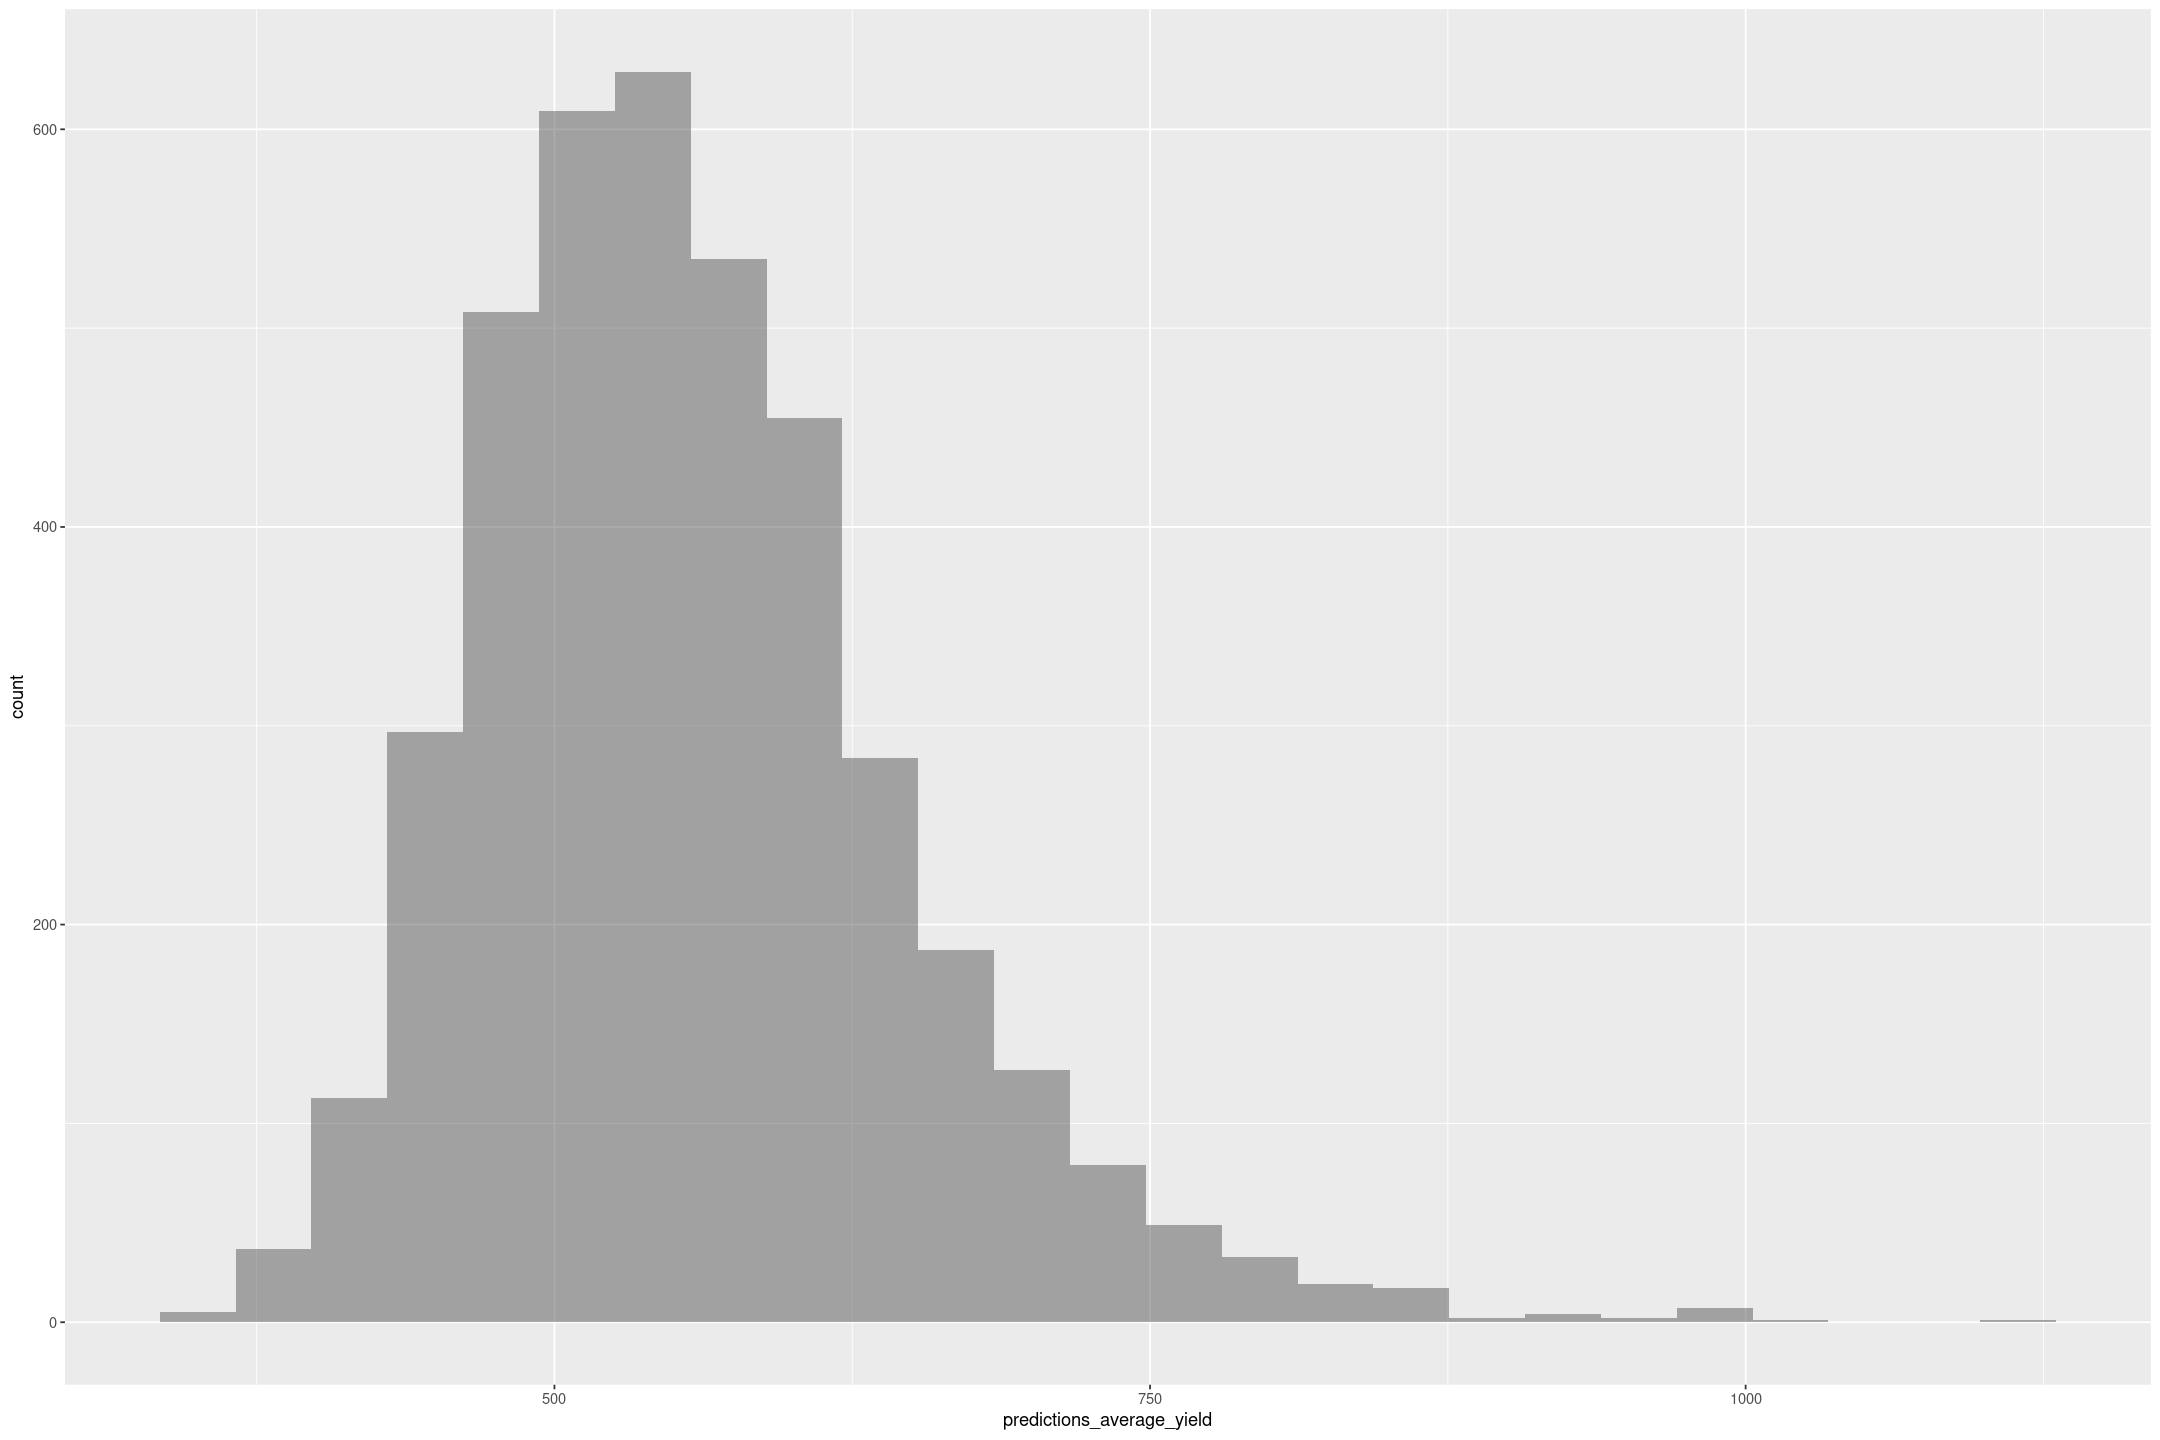

In [114]:
gf_histogram(~predictions_average_yield)

Then our prediction and standard error for the population average are:

In [115]:
c(mean=mean(predictions_average_yield), se=sd(predictions_average_yield))

mean        se 
558.16013  89.29809

# Models for regression coefficients

Using the Portugese student data from the [`Student`](https://github.com/avehtari/ROS-Examples/tree/master/Student) folder, repeat the analyses in Section 12.7 with the same predictors, but using as outcome the Poruguese language grade rather than the mathematics grade.

In [116]:
filename <- "./data/Student/student-merged.csv"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Student/data/student-merged.csv')
student <- read.csv(filename)

print(nrow(student))
student %>%head()

[1] 382


,G1mat,G2mat,G3mat,G1por,G2por,G3por,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,7,10,10,13,13,13,0,0,15,0,0,1,1,1,2,4,1,1,1,1,1,1,1,1,0,3,1,2,1,1,1,2
2,8,6,5,13,11,11,0,0,15,0,0,1,1,1,1,2,2,1,1,0,0,0,1,1,1,3,3,4,2,4,5,2
3,14,13,13,14,13,12,0,0,15,0,0,1,2,2,1,1,0,1,1,1,1,1,1,0,0,4,3,1,1,1,2,8
4,10,9,8,10,11,10,0,0,15,0,0,1,2,4,1,3,0,1,1,1,1,1,1,1,0,4,3,2,1,1,5,2
5,10,10,10,13,13,13,0,0,15,0,0,1,3,3,2,3,2,0,1,1,1,1,1,1,1,4,2,1,2,3,3,8
6,12,12,11,11,12,12,0,0,15,0,0,1,3,4,1,3,0,1,1,1,1,1,1,1,0,4,3,2,1,1,5,2


In [117]:
student_G3por <- student %>% select(-starts_with('G') | "G3por")
colnames(student_G3por)

[1] "school"     "sex"        "age"        "address"    "famsize"   
 [6] "Pstatus"    "Medu"       "Fedu"       "traveltime" "studytime" 
[11] "failures"   "schoolsup"  "famsup"     "paid"       "activities"
[16] "nursery"    "higher"     "internet"   "romantic"   "famrel"    
[21] "freetime"   "Dalc"       "Walc"       "health"     "absences"  
[26] "G3por"

## Fitting an unstandardised model

In [118]:
fit0 <- stan_glm(G3por ~ ., data=student_G3por, refresh=0)

In [119]:
fit0_coef <- as.matrix(fit0) %>% as.data.frame()

Unstandardised

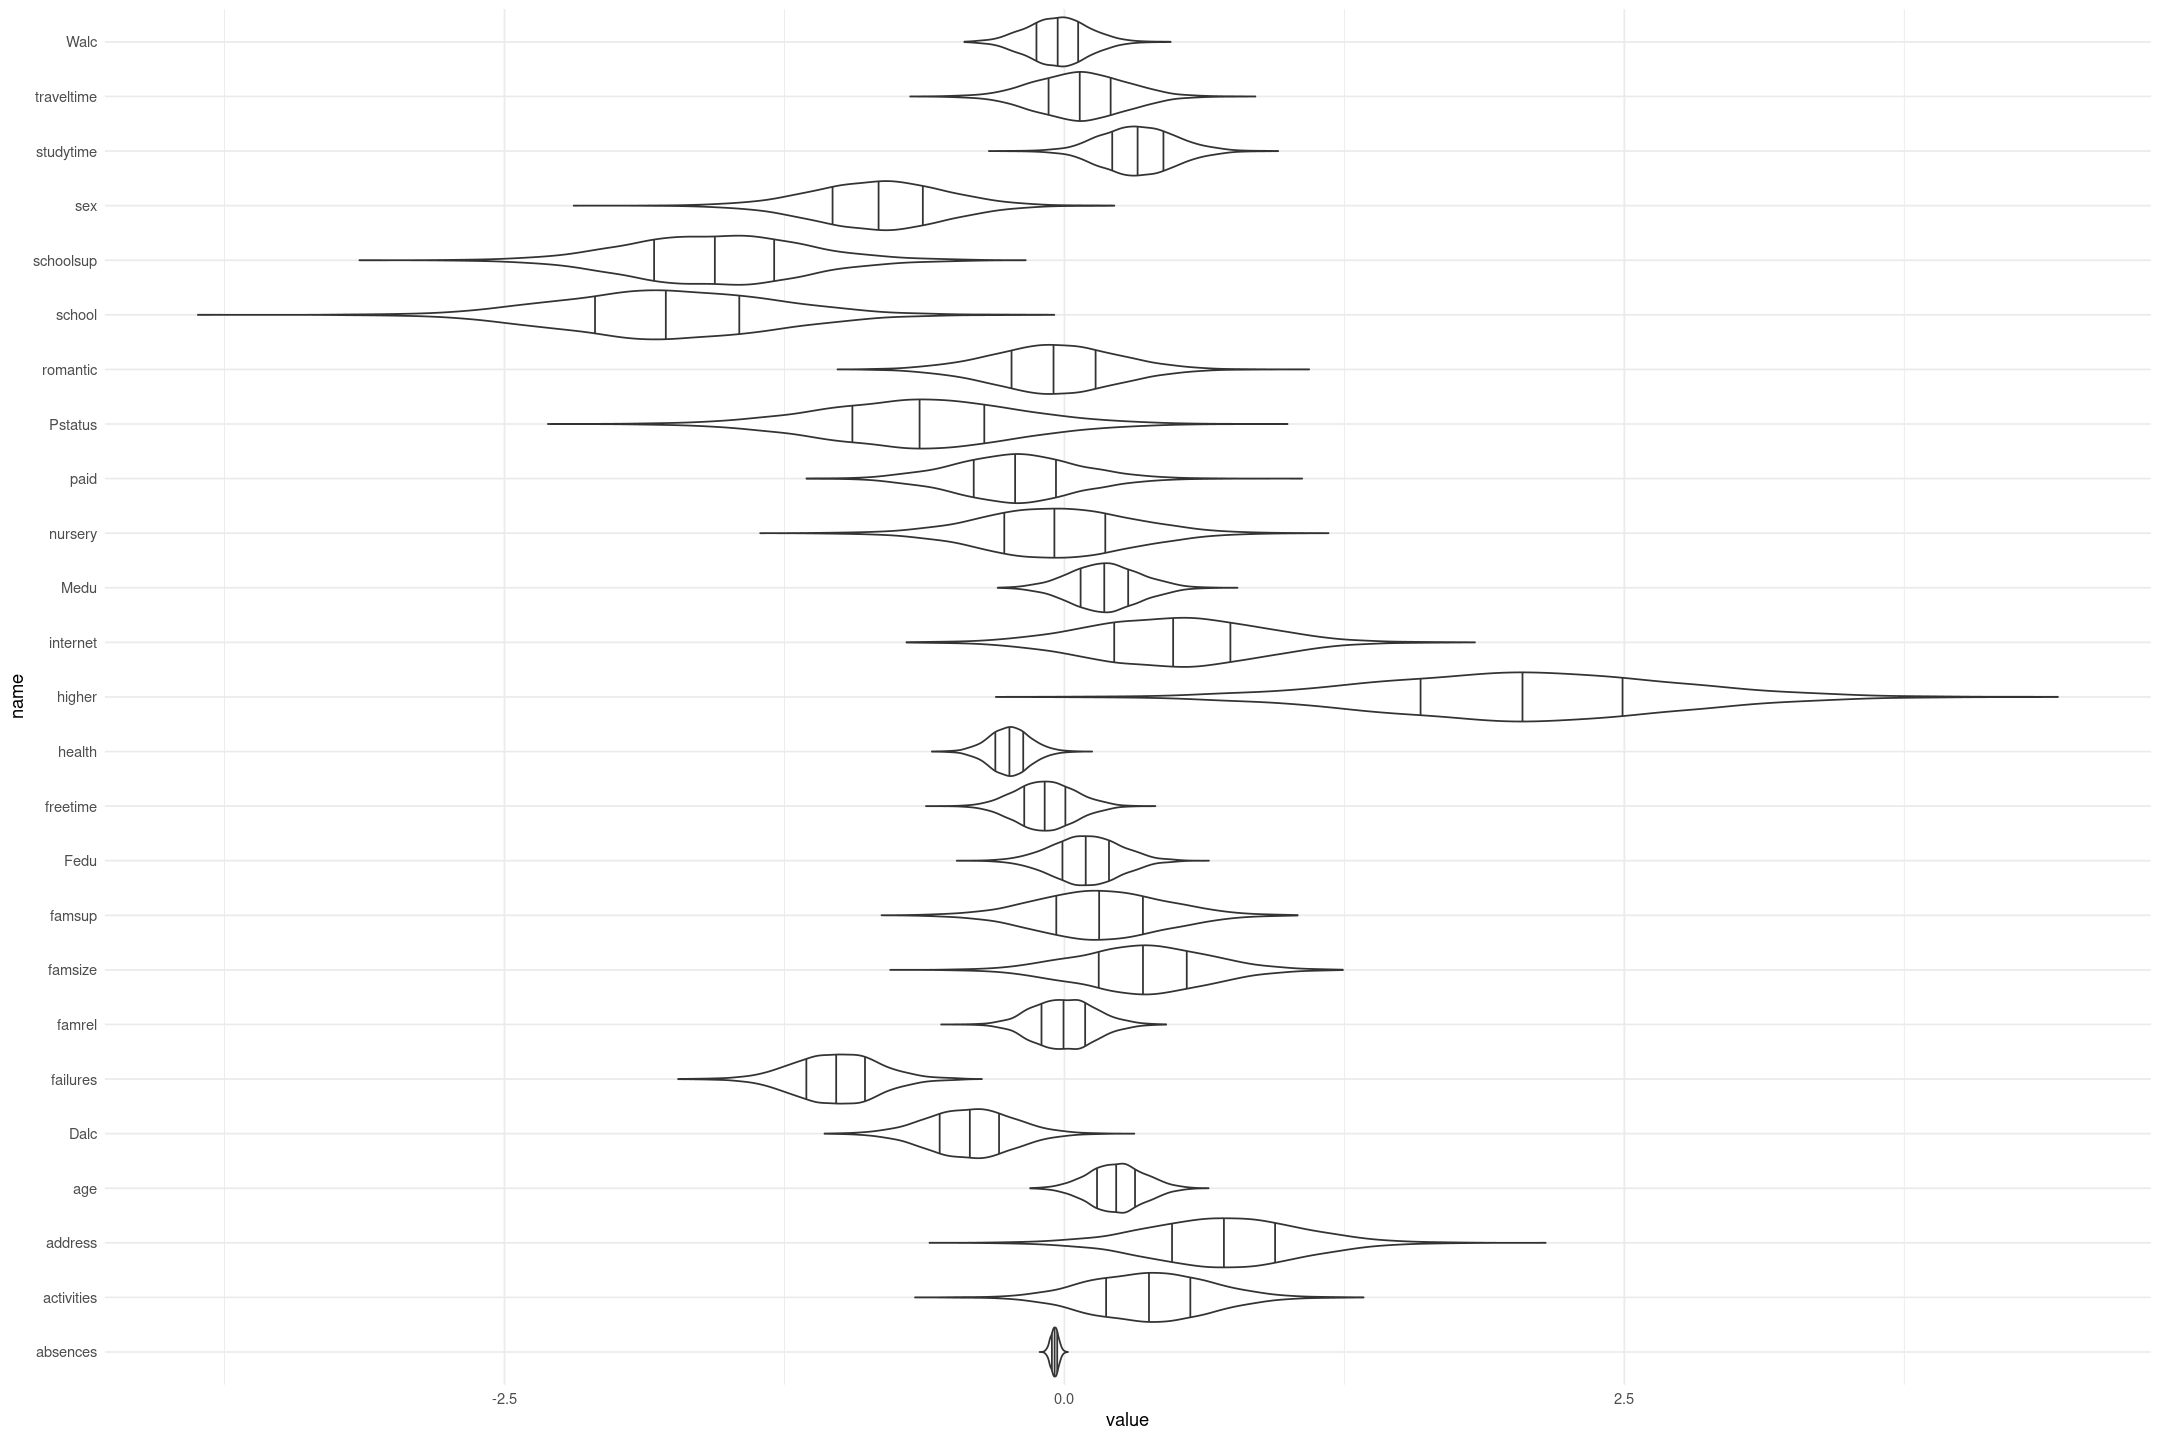

In [120]:
fit0_coef %>%
select(-`(Intercept)`, -`sigma`) %>%
pivot_longer(everything()) %>%
gf_violin(value~name, draw_quantiles=c(0.25, 0.5, 0.75), scale="width", bw="SJ") +
coord_flip() +
theme_minimal()

## Fitting a standardised model

In [121]:
student_std_G3por <- student_G3por %>%
mutate(across(-matches("G3por"), ~(. - mean(.))/sd(.)))

In [122]:
fit1 <- stan_glm(G3por ~ ., data=student_std_G3por, refresh=0)

In [123]:
fit1_coef <- as.matrix(fit1) %>% as.data.frame()

Upon standardisation we can see the coefficients have a more similar scale, and factors like `absences` can be seen to be more important.

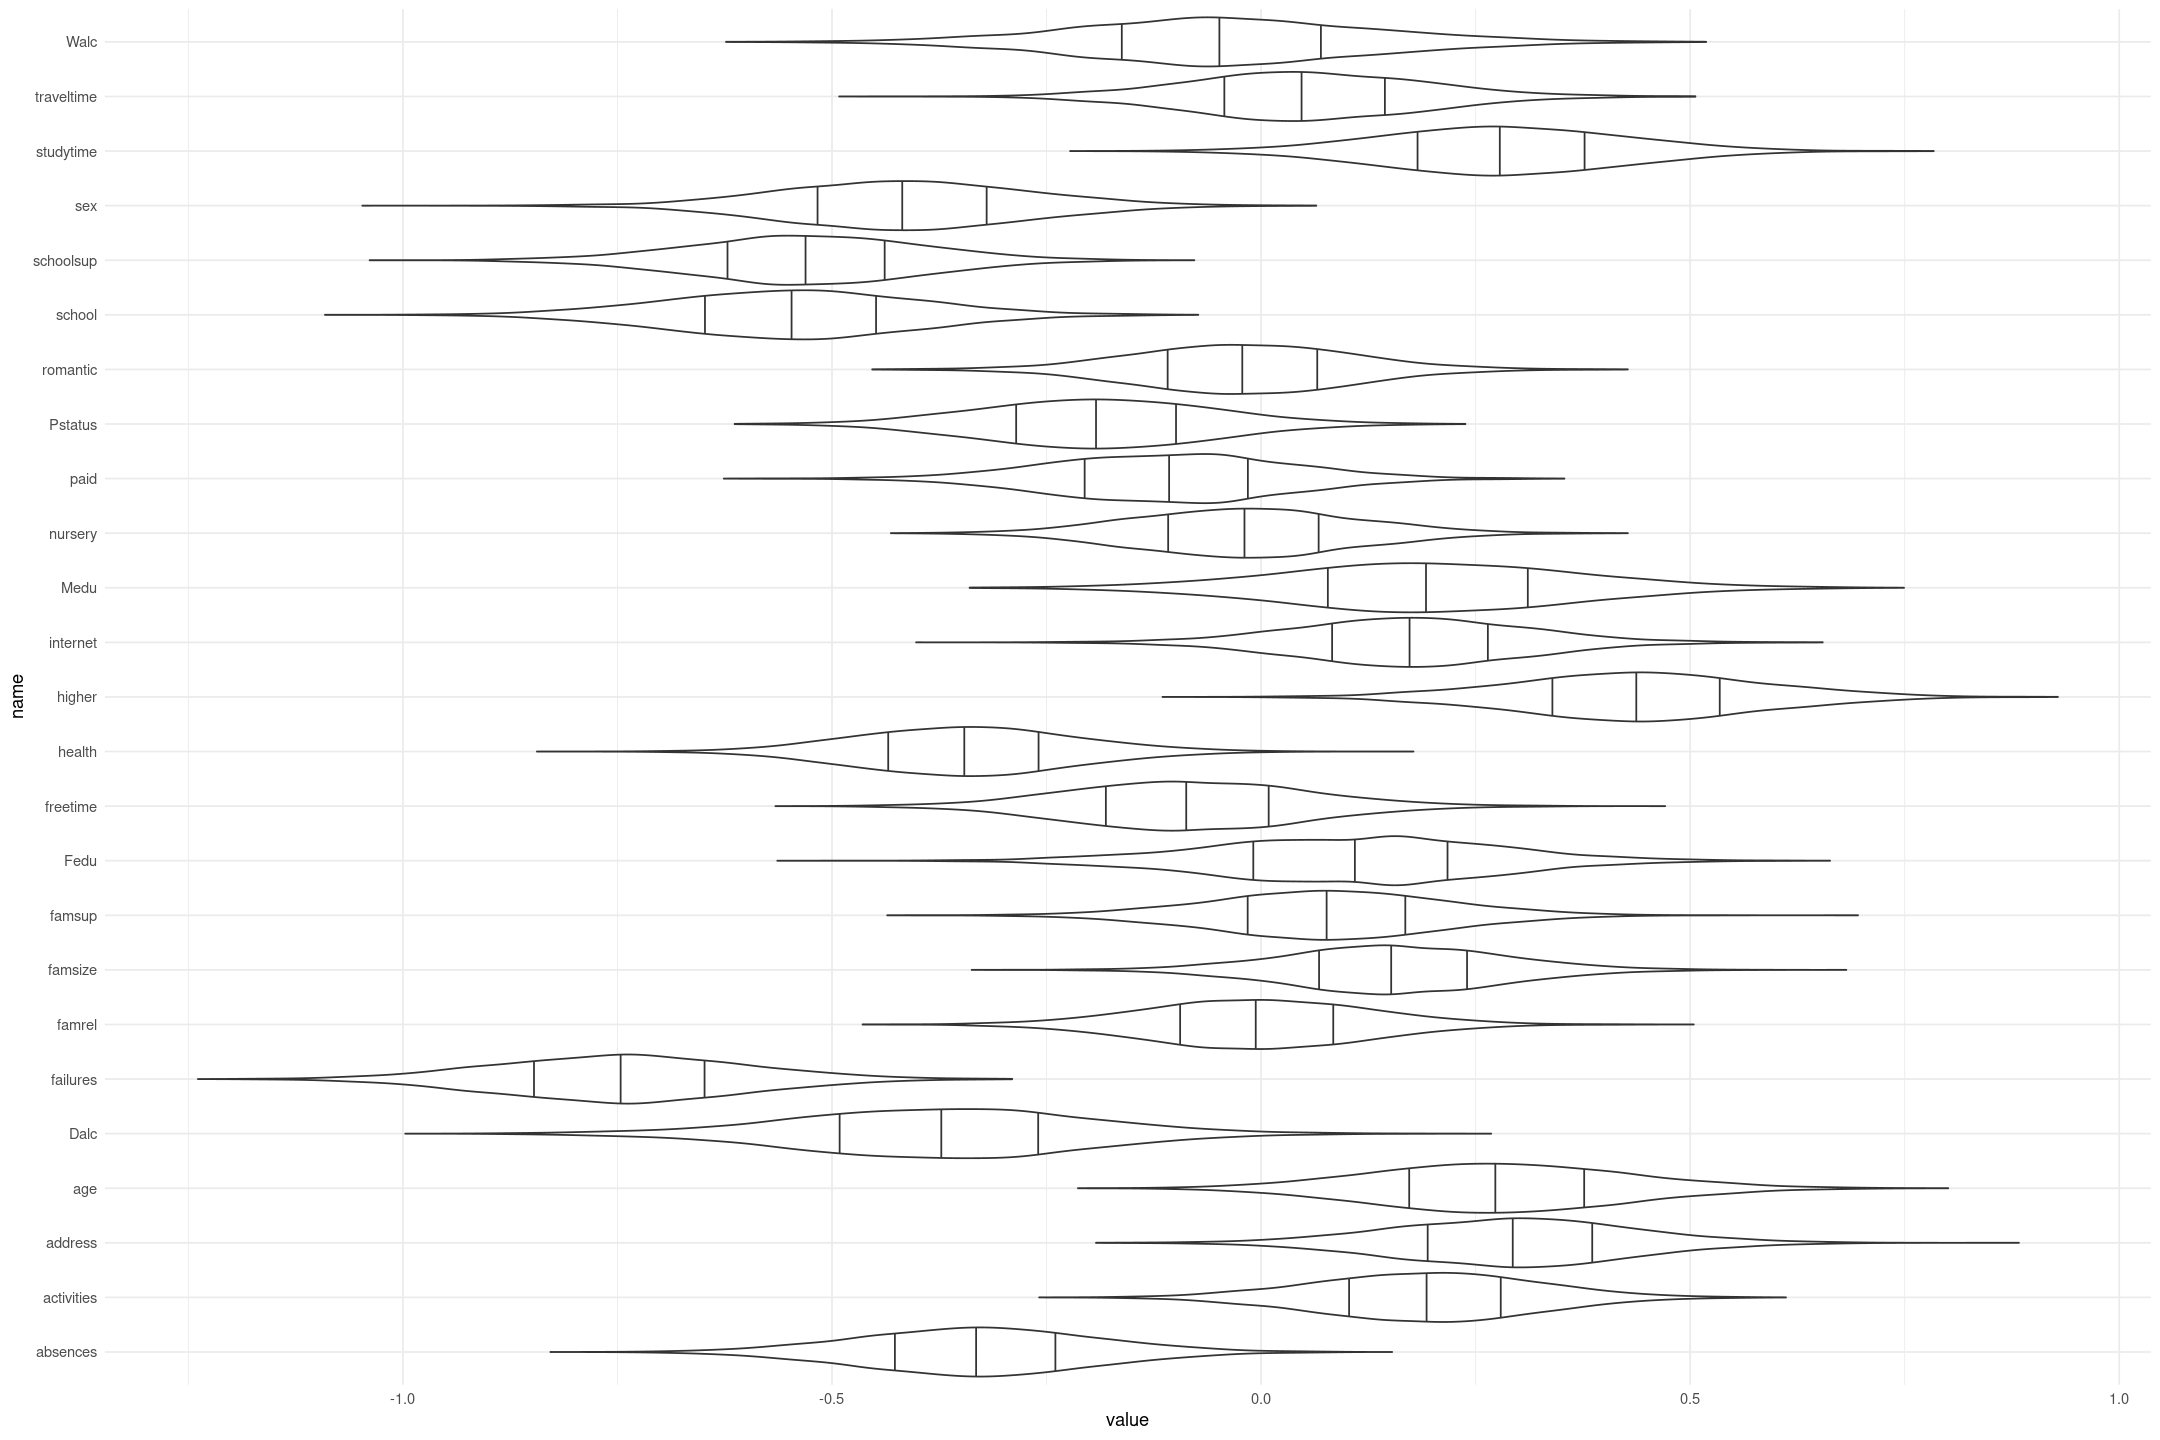

In [124]:
fit1_coef %>%
select(-`(Intercept)`,  -`sigma`) %>%
pivot_longer(everything()) %>%
gf_violin(value~name, draw_quantiles=c(0.25, 0.5, 0.75), scale="width", bw="SJ") +
coord_flip() +
theme_minimal()

## Calculating Bayesian $R^2$

Comparung LOO R2 and Bayes R2 shows overfitting (or so they say, I don't really understand why...)

In [125]:
c(loo=median(loo_R2(fit1)), bayes=median(bayes_R2(fit1)))

Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”


loo     bayes 
0.2684489 0.3826838

The esimtated parameters is 30+/- 4, which is a little bit higher than the actual number of 26.

In [126]:
loo(fit1)


Computed from 4000 by 382 log-likelihood matrix

         Estimate   SE
elpd_loo   -894.9 21.2
p_loo        30.0  4.1
looic      1789.7 42.5
------
Monte Carlo SE of elpd_loo is 0.1.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     381   99.7%   444       
 (0.5, 0.7]   (ok)         1    0.3%   227       
   (0.7, 1]   (bad)        0    0.0%   <NA>      
   (1, Inf)   (very bad)   0    0.0%   <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.

## Rescaling the prior

As in the text, let's assume as a prior 30% of the variance is explained by the model, distributed equally between the 26 parameters, and the other 70% is random variation.

In [127]:
fit2 <- stan_glm(G3por ~ ., data=student_std_G3por, prior=normal(scale=sd(student_std_G3por$G3por) / sqrt(0.3*26)), refresh=0)

In [128]:
fit2_coef <- as.matrix(fit2) %>% as.data.frame()

These look very similar, did I do something wrong??

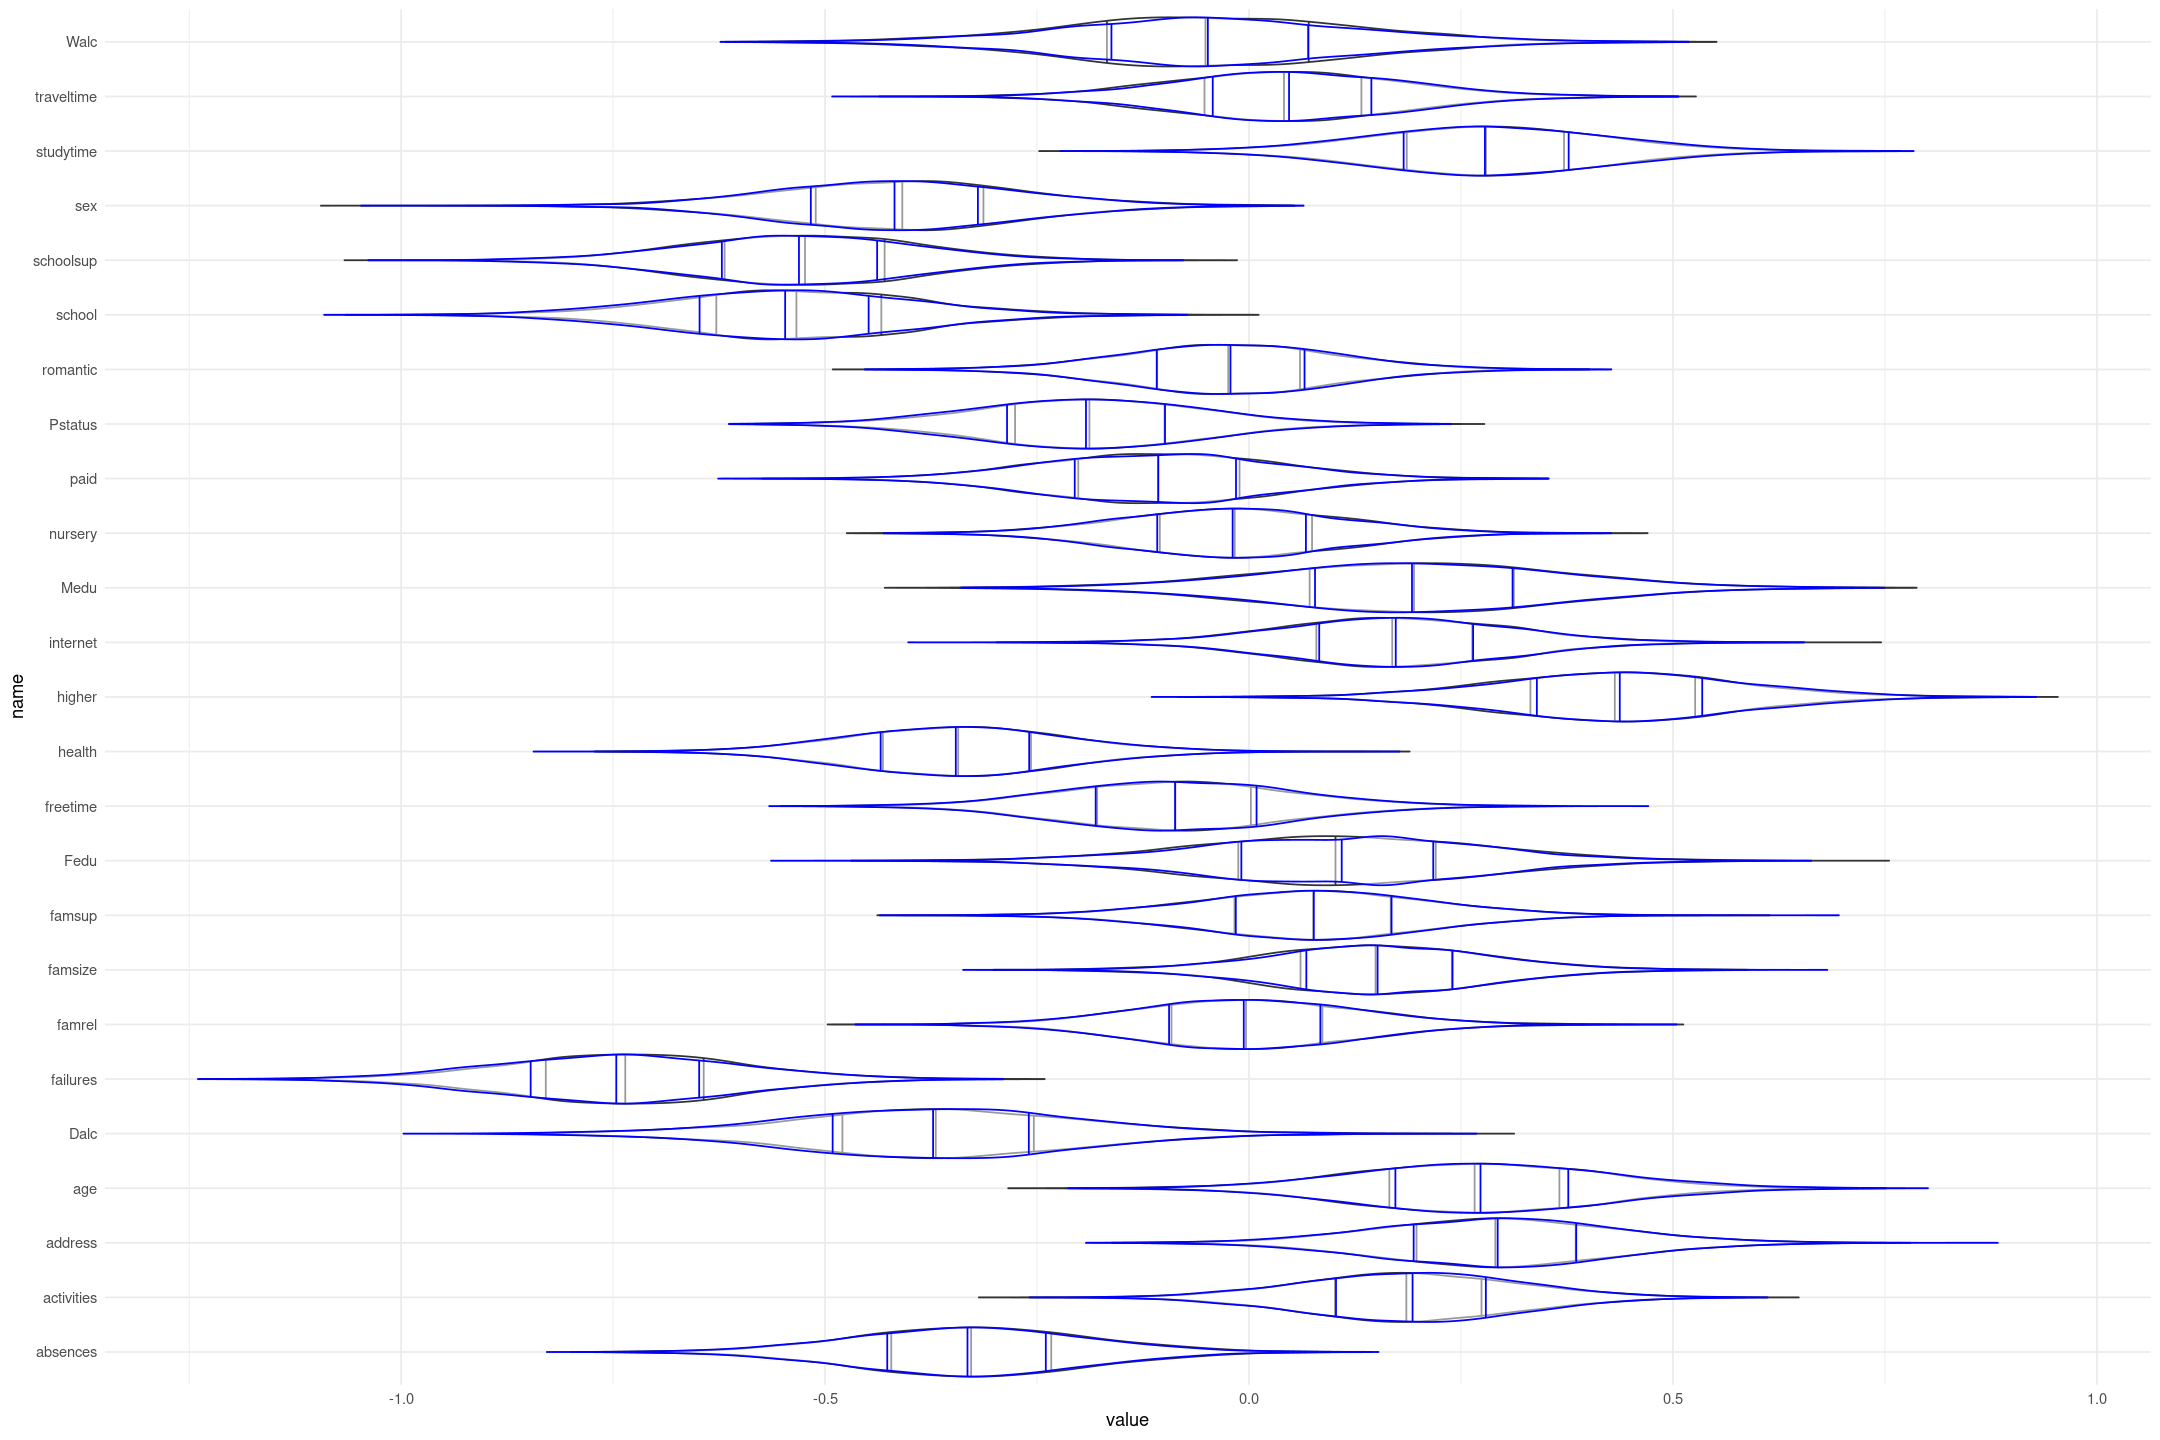

In [129]:
fit2_coef %>%
select(-`(Intercept)`,  -`sigma`) %>%
pivot_longer(everything()) %>%
gf_violin(value~name, draw_quantiles=c(0.25, 0.5, 0.75), scale="width", bw="SJ") %>%
gf_violin(value~name, data=fit1_coef %>% select(-`(Intercept)`,  -`sigma`) %>% pivot_longer(everything()), draw_quantiles=c(0.25, 0.5, 0.75), scale="width", bw="SJ", col="blue", alpha=0.5) +
coord_flip() +
theme_minimal()

## Horseshoe Prior

This is essentially magic to me, I'll have to read more into it.

In [130]:
(p <- ncol(student_std_G3por) - 1)

[1] 25

In [131]:
(n <- nrow(student_std_G3por))

[1] 382

In [132]:
p0 <- 6
(slab_scale <- sqrt(0.3/p0) * sd (student_std_G3por$G3por))

[1] 0.65862

In [133]:
(global_scale <- (p0/(p-p0))/ sqrt(n))

[1] 0.0161572

In [134]:
fit3 <- stan_glm(G3por ~ ., data=student_std_G3por, 
                 prior=hs(global_scale=global_scale, slab_scale=slab_scale),
                refresh=0)

In [135]:
fit3

stan_glm
 family:       gaussian [identity]
 formula:      G3por ~ .
 observations: 382
 predictors:   26
------
            Median MAD_SD
(Intercept) 12.5    0.1  
school      -0.4    0.1  
sex         -0.3    0.2  
age          0.1    0.1  
address      0.2    0.2  
famsize      0.1    0.1  
Pstatus     -0.1    0.1  
Medu         0.1    0.2  
Fedu         0.1    0.1  
traveltime   0.0    0.1  
studytime    0.3    0.2  
failures    -0.7    0.1  
schoolsup   -0.5    0.1  
famsup       0.0    0.1  
paid         0.0    0.1  
activities   0.1    0.1  
nursery      0.0    0.1  
higher       0.4    0.1  
internet     0.1    0.1  
romantic     0.0    0.1  
famrel       0.0    0.1  
freetime     0.0    0.1  
Dalc        -0.3    0.2  
Walc        -0.1    0.1  
health      -0.3    0.1  
absences    -0.2    0.1  

Auxiliary parameter(s):
      Median MAD_SD
sigma 2.4    0.1   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.s

In [136]:
fit3_coef <- as.matrix(fit3) %>% as.data.frame()

This has selected the variables:

1. studytime
2. sex
3. schoolsup
4. school
5. higher
6. health
7. failyres
8. Dalc
9. absences

For some reason we got more coefficients than we asked for in the prior - maybe the data was strong enough?

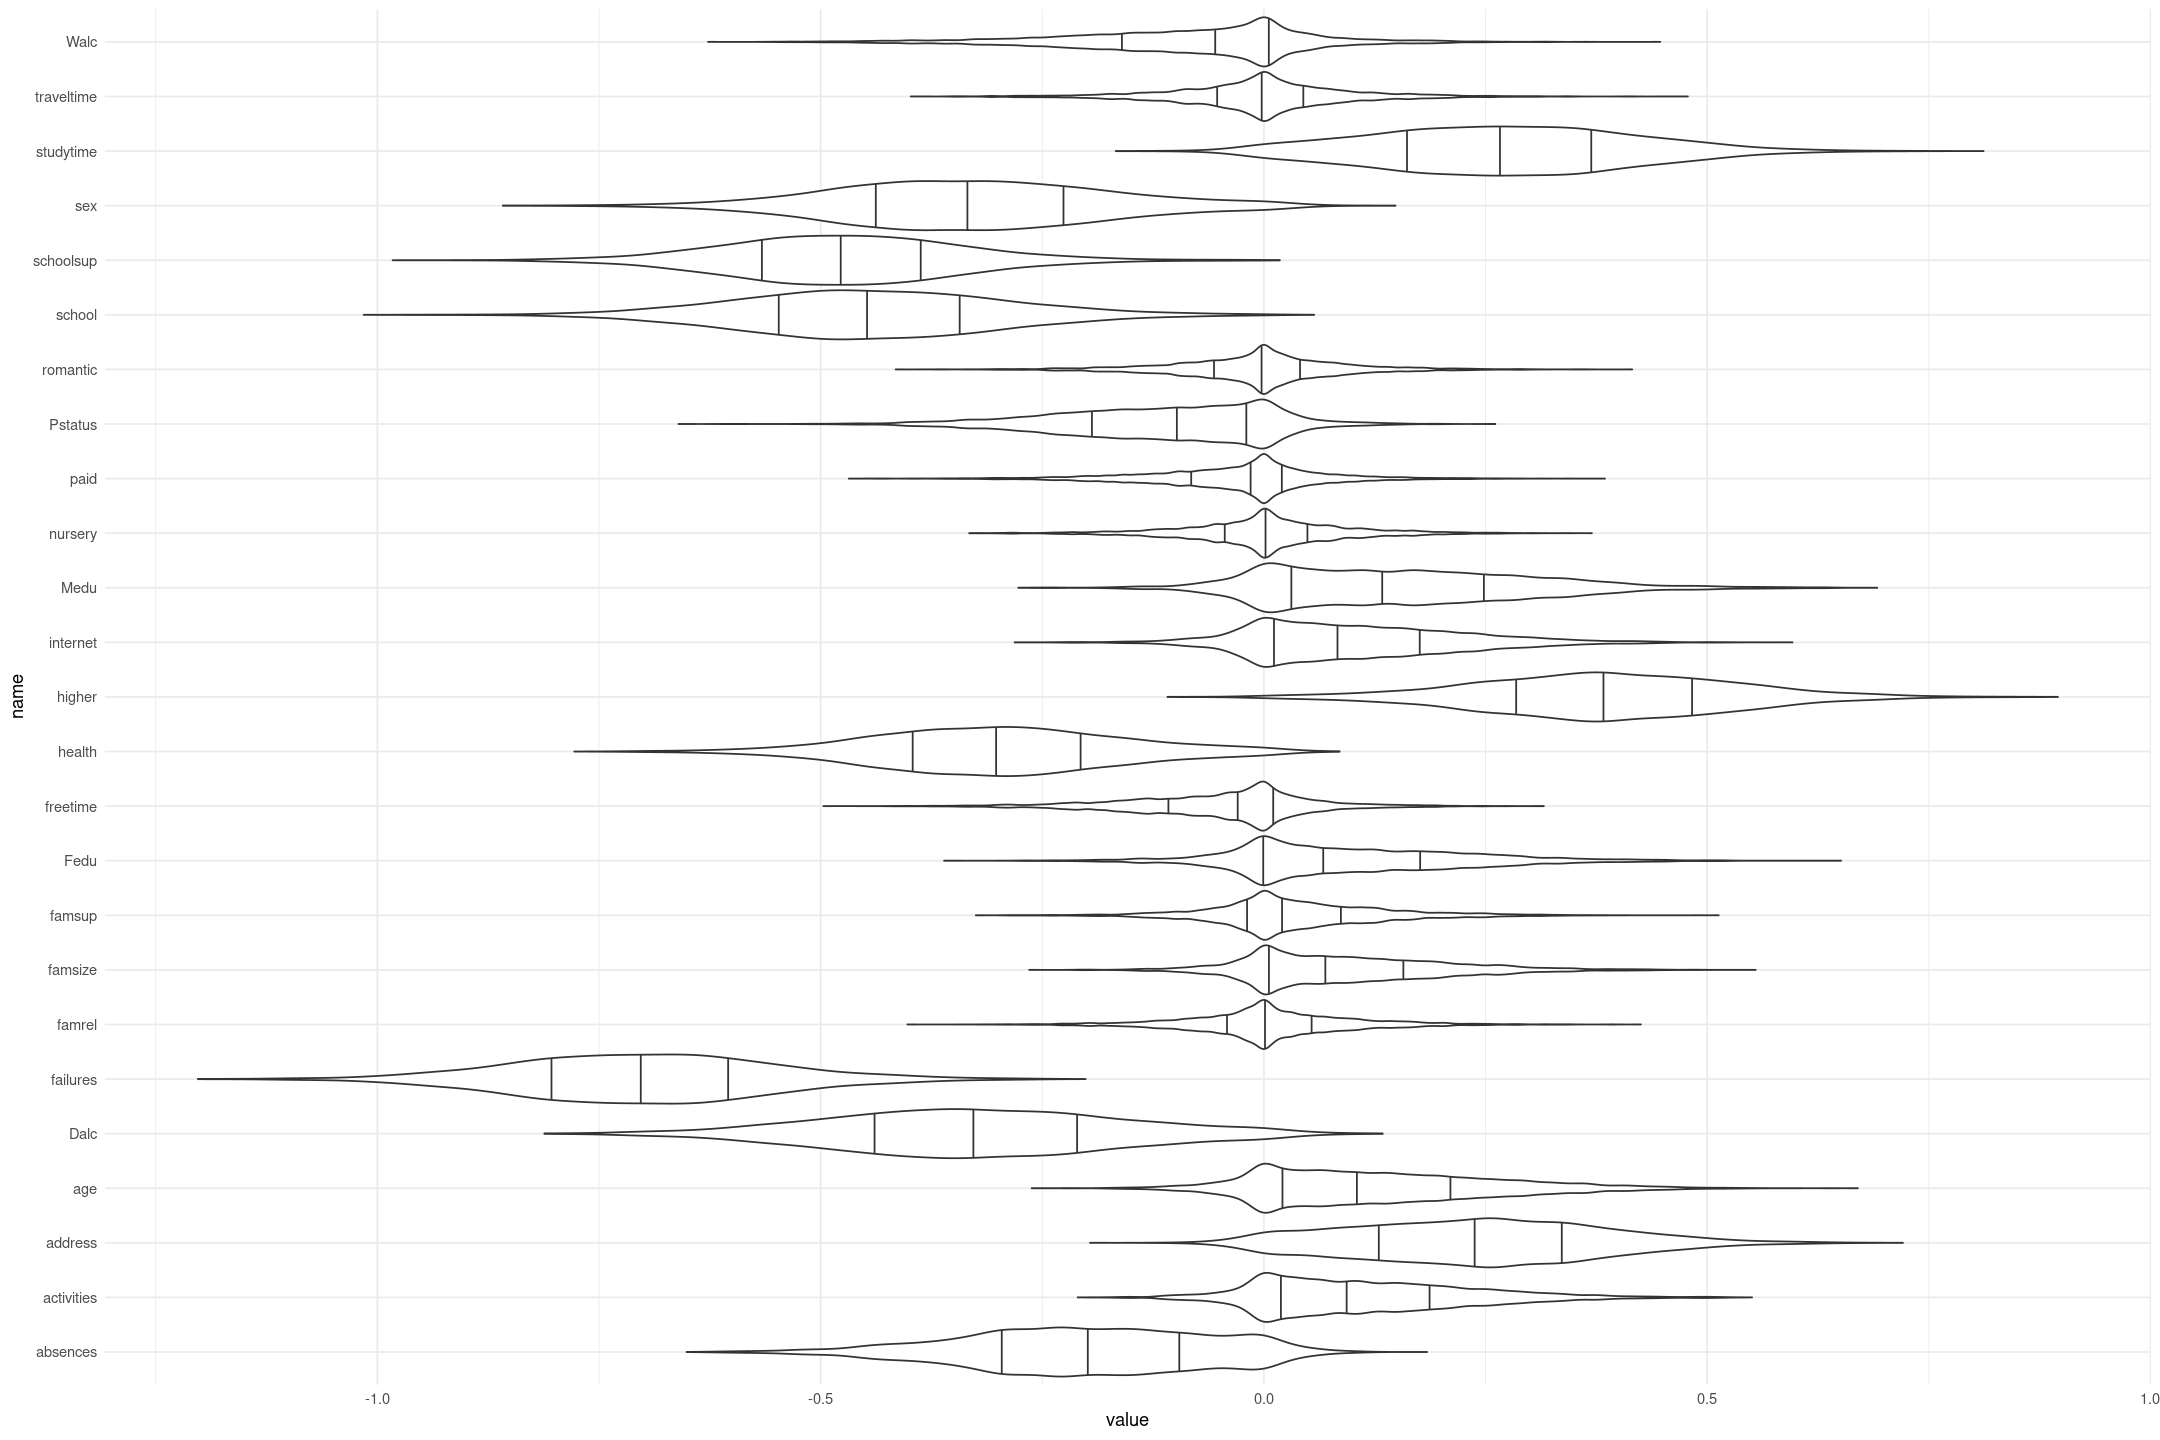

In [137]:
fit3_coef %>%
select(-`(Intercept)`,  -`sigma`) %>%
pivot_longer(everything()) %>%
gf_violin(value~name, draw_quantiles=c(0.25, 0.5, 0.75), scale="width", bw="SJ") +
#gf_violin(value~name, data=fit1_coef %>% select(-`(Intercept)`,  -`sigma`) %>% pivot_longer(everything()), draw_quantiles=c(0.25, 0.5, 0.75), scale="width", bw="SJ", col="blue", alpha=0.5) +
coord_flip() +
theme_minimal()

## Subset model

In [138]:
fit4 <- stan_glm(G3por ~ studytime + sex + schoolsup + school + higher + health + failures + Dalc + absences, 
                 data=student_std_G3por,
                refresh=0)

In [139]:
fit4

stan_glm
 family:       gaussian [identity]
 formula:      G3por ~ studytime + sex + schoolsup + school + higher + health + 
	   failures + Dalc + absences
 observations: 382
 predictors:   10
------
            Median MAD_SD
(Intercept) 12.5    0.1  
studytime    0.3    0.1  
sex         -0.4    0.1  
schoolsup   -0.6    0.1  
school      -0.6    0.1  
higher       0.4    0.1  
health      -0.4    0.1  
failures    -0.8    0.1  
Dalc        -0.4    0.1  
absences    -0.2    0.1  

Auxiliary parameter(s):
      Median MAD_SD
sigma 2.4    0.1   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

Fit 4 produces the best log score under Leave-One-Out cross validation.

In [140]:
loo_compare(
loo(fit1),
loo(fit2),
loo(fit3),
loo(fit4)
)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
fit4,0.000000,0.000000,-889.9170,20.99541,14.27954,2.415803,1779.834,41.99081
fit3,-2.986338,4.022672,-892.9033,22.17463,25.71222,3.800564,1785.807,44.34925
fit2,-4.375932,4.935873,-894.2929,21.32767,29.48192,4.017900,1788.586,42.65534
fit1,-4.946844,4.975980,-894.8638,21.23280,29.96438,4.096655,1789.728,42.46560


It's a closer fit between Bayes R2 and LOO R2 (before 0.27 and .38), but still potentially overfit?

In [141]:
c(loo=median(loo_R2(fit4)), bayes=median(bayes_R2(fit4)))

loo     bayes 
0.2885792 0.3356449

# Applying ideas of regression

Read a published article that uses regression modeling and is on a topic of interest to you.
Write a page or two evaluating and criticizing the article, addressing issues discussed in Chapters 1-12, such as measurement, data visualization, modeling, inference, simulation, regression, assumptions, model checking, interactions, and transformations.
The point of this exercise is not to come up with a comprehensive critique of the article but rather to review the key points of this book so far in the context of a live example.

[Pierre Chandon and Brian Wansink, “When Are Stockpiled Products Consumed Faster? A Convenience-Salience Framework of Postpurchase Consumption Incidence and Quantity,” *Journal of Marketing Research* 39, no. 3 (August 2002): 321–35.](https://faculty.insead.edu/pierre-chandon/documents/Article-When%20are%20stockpiled%20products%20consumed%20faster%20-%20A%20convenience%20salience%20framework%20of%20post%20purchase%20consumption%20incidence%20and%20quantity.pdf)

This article considers the impact of stockpiling and salience on whether people conusme a product, and how much they consume.
There are 4 studies; an observational study, a field study and 2 lab studies which can be considered separately.

## Study 1 - Observational from Scanner Data

### Summary

This is an observational study on household-level scanner data from a panel in a market-test zone in France in 1994.
There is no information about how representative this panel would be of a wider population in France, or other countries, so we should be careful about the generality of any inferences drawn.

From this they subset it for each of fruit juices, cookies and detergents:

> We select a random sample of households among those that had made at least four purchases in earch half-year period

I'm not sure if they're actually picking a random subsample here - that seems like a strange thing to do (why wouldn't you use all the available data).

For each household they compute the modal purchase quantity over the first 6 months of 1994.
How do you define the mode if it varies?

They define a purchase of a product category as:

* Exogenous if it consists entirely of promotional packs
* Endogenous if it is larger than the modal purchase size
* Regular otherwise

Then for each purchase they measure the Quantity (Q), the Interpurchase Days (IP), and the rate of consumption (Q/IP).

Sample sizes

| Product Category | Households | Average shopping trips |
| --- | --- | --- |
| Fruit Juice | 272 | 9.8 |
| Cookies | 393 | 11.1 |
| Laundry Detergent | 457 | 4.5 |

Here are the results of their regression

![Regression coefficients](images/impact_stockpiling_scanner_regression.png)

### Regression assumptions


#### Validity 

I think there are serious validity issues with how this is constructed.
The way the rate of consumption is calculated assumes that the whole quantity is consumed between purchases.
But for categories like Fruit Juice and Cookies a household may have several varities in stock, and purchase one variety without purchasing the other.
Given they have UPC level data this is something that could be verified or ruled out.
This asusmption seems more reasonable for detergent, which is closer to a commodity (although there are items like detergents specific for whites, or colours).

The way endogenous purchases have been defined seems a bit artificial.
If I normally purchase one box of biscuits, but once in a while when it's on special I buy two, then that is defined as an endogenous purchase.
I'm not sure why price data of purchase wasn't taken into account; discounting would likely have an effect on purchase.
Purchasing more than the modal amount is not a good heuristic for increased demand (and conversely with increased demand I may opt for the larger promotional packs, which would be classified as exogenous).
This takes away the larger purchases, comparing *exogenous* purchases (only promotional packs) to endogenous purchases.


#### Representativeness

They have picked 3 specific household products, fruit juice, cookies and detergent.
They are drawing inferences about consumption in general, but I think for items with different consumption patterns (e.g. paper towels) that would require more evidence.

By subselecting people who make at least 4 purchases in each six month period they are limiting to regular consumers of the item.
For the purposes of inferring the impact of promotional packages on regular consumers of the item this is a reasonable sample (and this is an interesting population for retailers).

#### Linearity and Additivity

The factors exogenous and endogenous are binary exclusive, and so linearity is not relevant.

There's a quantity called "Average Household Consumption" that isn't really explained.
A visualisation of the distribution of this would be useful to see whether the relationship is actually linear.

### Modeling

Looking at Table 1 all of purchase quantity, interpurchase period and daily consumption rate have a standard deviation of a similar magnitude to their mean.
Then since the data are non-negative, a normal distribution is a poor approximation and the outcome variables are long tailed.
Another way to see this is comparing the mean daily consumption rate with the ratio of the means of purchase quantity and interpurchase days; it's around double.

From this it's not clear to me whether averages are the right way to represent the data, maybe it should be transformed first (perhaps with a log transform?).

We can infer something about household consumption from the coefficients.
The binary variables are coded to -1/3 to 2/3, and so the average daily consumption for regular purchases is approximately `intercept - 1/3 exogenous_coef - 1/3 endogenous_coef + average_household_consumption_coef * average(household_consumption_coef)`.

For Juices it's 16, for cookies it's 32, and for detergents it's 0.5.
This seems to be the average daily quantities per household (in centiliters, grams and laundry loads respectively).

I'm guessing they must have added a household level variable of the average consumption over the whole period.
I'm not clear how much value this adds from a modeling perspective.
I suspect a better way to do this would be with a multilevel model, but given the fundamental validity issues it wouldn't be worth solving.

## Study Two - Field Study

### Summary

The hypothesis they are testing is:

> Exogenous product stockpiling increases consumption rates by increasing consumption quantities for both high- and low-convenience products and by increasing consumption incidence only for high-convenience products.

There's a lot packed in here!

In this study the authors recruited 60 households through four Parent Teacher Associations in New Hampshire and Vermont, giving a mild incentive. 56 completed the study.

There are six products: crackers, granola bars and fruit juice (considered high convenience) and noodles, oatmeal and popcorn (considered low convenience).
They gave 12 units of three products (called stockpiled), and 4 units of another three (called not stockpiled).
There's a complex setup around salience; they're told to track the frequency of consumption of two of the products on a diary on their fridge (distractor), photographs of a different two products are in the consumption tracking diary (high salience), and the other 2 are considered low salience.
At the end of 14 days they're asked to recall their daily usage (in units) of all products over the previous 14 days, but the distractor product is discarded.


For each product it will be a distractor 1/3 of the time, and so the data is discarded.
The remaining data (40 households) will be salient half the time, and stockpiled half the time, so there are 10 data points in each condition.
This will be slightly lower due to the 4 households that dropped out.

|  | Stockpiled | Not Stockpiled |
| --- | --- | --- |
| Salient  | 10 | 10 |
| Not-Salient  | 10 | 10 |

Each unit is converted into ounces to be comparable.

| Product | Convenience | Unit Size (Ounces) |
| --- | --- | --- |
| Crackers | High | .75 |
| Granola | Low | 1.0 |
| Fruit Juice | High | 6.75 |
| Noodles | Low | 1.5 |
| Oatmeal | Low | 1.2 |
| Popcorn | Low | 3.5 |

Then a giant regression is built out of the coefficients:

![Impact of Stockpiling Regression Coefficients](images/impact_stockpiling_field_regression.png)


### Interpreting the model

We're lucky they included every product in the regression; consider "Total Consumption" for All Products, because the Fruit Juice coefficient sticks out.

By assuming average values for the factors we can calculate typical consumption quantities in the non-salient, non-stockpiled condition.

In particular:

* Ignore the education factors (giving equal weight they average out to 0.3, small enough to be ignored)
* Assume the typical product evaluation on a 9 point scale is 4; giving weight 5.2 ounces
* Assume typical number of children is 2 (given on PTA it's at least 1); giving weight of 4 ounces

Then for the non-salient, non-stockpiled condition the average consumption over 14 days is in the table below:

| Product | Unit Size (Ounces) | Average Consumption (Ounces) | Average Consumption (Units) |
| --- | --- | --- | --- | 
| Crackers | .75 | 15 | 20 |
| Granola |  1.0 | 18.1 | 18.1 |
| Fruit Juice | 6.75 | 50.5 | 7.5 |
| Noodles | 1.5 | 2 | 1.3 |
| Oatmeal | 1.2 | 1.9 | 0.6 |
| Popcorn | 3.5 | 6.6 | 0.5 |


Note that they only supplied 4 units of each product to the group, but for the high salience products they consumed much more! Likely because they already had it in the house, and consumed it.
This is a vital pre-treatment condition they failed to identify - what the baseline consumption was before the study.
This could completely explain why the consumption incidence is much higher for high-salience items than for low (the second part of the hypothesis).

It would have been much better to log transform the consumption quantity, than to regress directly on weight of food.
If a household in a high stockpiling fruit juice condition drinks all the extra fruit juice provided, they consume an additional 54 ounces.
On the other hand if a household is in the high stockpiling oatmeal condition and consumes all the extra oatmeal provided, then they consume an additional 9.6 ounces.
The effect size is 5.6 bigger just due to the difference in unit size.
Because of this, and the baseline differences, I can't take the interaction between salience and convenience seriously.

A log transform would have been much more interpretable too.
The impact marketers would be interested in is the percentage increase from stockpiling.

It would be nice to have a table of number of children versus consumption to show whether this relationship actually is linear (or at least some information about the distribution of number of children).

However they have helpfully provided an image of consumption by day:

<img width="500" src="images/convenience_salience_daily_consumption.png"/>

Looking on a multiplicative scale the increase in consumption is about the same for both low and high convenience products (e.g around 1.5x on day 1).
The difference is high convenience products are probably already in people's kitchens (as can be seen in consuming more than they were given).
It would be interesting to know the stock levels of substitutes of the market products to know how much of the extra consumption in the first few days in high-convenience products is driven by further stockpiling.

In figure 3 the patterns look very clear because they've removed all uncertainty.
Adding some uncertainty (such as simulated lines drawn thinner) would make it clear how stong these effects really are.

There's a more to say here (I haven't written about the other 6 models in table 3 or studies 3 and 4), but in short, despite it's shortfalls I'm pretty convinced that stockpiling can increase consumption significantly (more by the line graphs above than anything else).